In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.compose import ColumnTransformer
import statsmodels.api as sma
from sklearn.model_selection import cross_val_score,GridSearchCV,RandomizedSearchCV
from sklearn import tree
from scipy.stats import randint
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

In [2]:
df1=pd.read_csv("df_trim.csv")
df1.head()

,product_id,time_id,customer_id,promotion_id,store_id,store_sales,store_cost,unit_sales,product_class_id,brand_name,...,houseowner,num_cars_owned,fullname,the_date,the_day,the_year,the_month,day_of_month,day_since_epoch,promotion_period
0,451,677,7366,207,3,7.12,2.2784,4,55,Red Wing,...,Y,4,Ann Smith,11/7/1997,Friday,1997,11,7,34279,4
1,1293,677,7366,207,3,5.76,1.7856,4,14,Booker,...,Y,4,Ann Smith,11/7/1997,Friday,1997,11,7,34279,4
2,738,677,7366,207,3,5.55,2.0535,3,39,Consolidated,...,Y,4,Ann Smith,11/7/1997,Friday,1997,11,7,34279,4
3,1426,677,8947,207,3,7.48,2.2440,2,61,Hermanos,...,Y,2,Robert Bell,11/7/1997,Friday,1997,11,7,34279,4
4,338,677,8947,207,3,2.28,1.0488,4,58,Better,...,Y,2,Robert Bell,11/7/1997,Friday,1997,11,7,34279,4


In [3]:
#Impute null values with median for specified columns
columns_to_impute = ['store_sqft', 'grocery_sqft', 'frozen_sqft', 'meat_sqft']
imputer = SimpleImputer(strategy='median')
df1[columns_to_impute] = imputer.fit_transform(df1[columns_to_impute])

In [4]:
# Check for remaining null values
df_null = df1.isnull().sum()
df_null

product_id          0
time_id             0
customer_id         0
promotion_id        0
store_id            0
                   ..
the_year            0
the_month           0
day_of_month        0
day_since_epoch     0
promotion_period    0
Length: 94, dtype: int64

In [5]:
# Remove specified columns
columns_to_remove = ["lname", "fname", "mi", "address1", "address2"]
df1 = df1.drop(columns=columns_to_remove)

In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70751 entries, 0 to 70750
Data columns (total 89 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   product_id             70751 non-null  int64  
 1   time_id                70751 non-null  int64  
 2   customer_id            70751 non-null  int64  
 3   promotion_id           70751 non-null  int64  
 4   store_id               70751 non-null  int64  
 5   store_sales            70751 non-null  float64
 6   store_cost             70751 non-null  float64
 7   unit_sales             70751 non-null  int64  
 8   product_class_id       70751 non-null  int64  
 9   brand_name             70751 non-null  object 
 10  product_name           70751 non-null  object 
 11  SKU                    70751 non-null  int64  
 12  SRP                    70751 non-null  float64
 13  gross_weight           70751 non-null  float64
 14  net_weight             70751 non-null  float64
 15  re

# trying model with 56 columns where id columns, date columns are removed.

In [7]:
df_old=df1[['store_sales', 'store_cost', 'unit_sales','brand_name', 'product_name','SRP', 'gross_weight',
       'net_weight', 'recyclable_package', 'low_fat', 'units_per_case',
       'cases_per_pallet', 'shelf_width', 'shelf_height', 'shelf_depth',
       'subcategory', 'category', 'department', 'family','promotion_name', 'media_type', 'cost','sales_city',
       'sales_state_province', 'sales_district', 'sales_region',
       'sales_country','store_type', 'store_name','store_city', 'store_state','store_country', 'store_manager','store_sqft',
       'grocery_sqft', 'frozen_sqft', 'meat_sqft', 'coffee_bar', 'video_store',
       'salad_bar', 'prepared_food', 'florist','city',
       'state_province','country','marital_status', 'yearly_income',
       'gender', 'total_children', 'num_children_at_home', 'education','member_card', 'occupation', 'houseowner',
       'num_cars_owned','promotion_period']]

In [8]:
le=LabelEncoder()
df_old_num=df_old.select_dtypes(include=np.number)
df_old_cat=df_old.select_dtypes(exclude=np.number)

In [9]:
df_old_cat

,brand_name,product_name,subcategory,category,department,family,promotion_name,media_type,sales_city,sales_state_province,...,city,state_province,country,marital_status,yearly_income,gender,education,member_card,occupation,houseowner
0,Red Wing,Red Wing Paper Cups,Paper Dishes,Paper Products,Household,Non-Consumable,Super Duper Savers,Cash Register Handout,Bremerton,WA,...,Port Orchard,WA,USA,M,$30K - $50K,F,High School Degree,Bronze,Skilled Manual,Y
1,Booker,Booker Low Fat Sour Cream,Sour Cream,Dairy,Dairy,Food,Super Duper Savers,Cash Register Handout,Bremerton,WA,...,Port Orchard,WA,USA,M,$30K - $50K,F,High School Degree,Bronze,Skilled Manual,Y
2,Consolidated,Consolidated Toothpaste,Personal Hygiene,Hygiene,Health and Hygiene,Non-Consumable,Super Duper Savers,Cash Register Handout,Bremerton,WA,...,Port Orchard,WA,USA,M,$30K - $50K,F,High School Degree,Bronze,Skilled Manual,Y
3,Hermanos,Hermanos Prepared Salad,Fresh Vegetables,Vegetables,Produce,Food,Super Duper Savers,Cash Register Handout,Bremerton,WA,...,Bremerton,WA,USA,S,$50K - $70K,M,High School Degree,Normal,Skilled Manual,Y
4,Better,Better Beef Soup,Soup,Canned Soup,Canned Foods,Food,Super Duper Savers,Cash Register Handout,Bremerton,WA,...,Bremerton,WA,USA,S,$50K - $70K,M,High School Degree,Normal,Skilled Manual,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70746,Tri-State,Tri-State Peaches,Fresh Fruit,Fruit,Produce,Food,Savings Galore,In-Store Coupon,Victoria,BC,...,Victoria,BC,Canada,S,$110K - $130K,M,High School Degree,Silver,Management,Y
70747,High Top,High Top Potatos,Fresh Vegetables,Vegetables,Produce,Food,Savings Galore,In-Store Coupon,Victoria,BC,...,Victoria,BC,Canada,S,$110K - $130K,M,High School Degree,Silver,Management,Y
70748,Sunset,Sunset Paper Towels,Paper Wipes,Paper Products,Household,Non-Consumable,Savings Galore,In-Store Coupon,Victoria,BC,...,Victoria,BC,Canada,S,$90K - $110K,M,Bachelors Degree,Golden,Professional,Y
70749,Tell Tale,Tell Tale Prepared Salad,Fresh Vegetables,Vegetables,Produce,Food,Savings Galore,In-Store Coupon,Victoria,BC,...,Victoria,BC,Canada,S,$90K - $110K,M,Bachelors Degree,Golden,Professional,Y


In [10]:
df_old_num

,store_sales,store_cost,unit_sales,SRP,gross_weight,net_weight,recyclable_package,low_fat,units_per_case,cases_per_pallet,...,meat_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,total_children,num_children_at_home,num_cars_owned,promotion_period
0,7.12,2.2784,4,1.78,13.40,11.30,1,0,25,11,...,6122.0,0,0,1,1,0,2,2,4,4
1,5.76,1.7856,4,1.44,8.25,5.25,0,1,22,6,...,6122.0,0,0,1,1,0,2,2,4,4
2,5.55,2.0535,3,1.85,7.12,4.11,1,0,34,8,...,6122.0,0,0,1,1,0,2,2,4,4
3,7.48,2.2440,2,3.74,13.10,12.10,0,1,21,13,...,6122.0,0,0,1,1,0,2,0,2,4
4,2.28,1.0488,4,0.57,16.90,14.80,1,0,6,10,...,6122.0,0,0,1,1,0,2,0,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70746,7.68,3.5328,3,2.56,10.50,8.50,0,1,12,13,...,2795.0,1,0,0,0,1,4,0,3,3
70747,2.85,0.8835,5,0.57,9.30,7.30,1,0,24,12,...,2795.0,1,0,0,0,1,4,0,3,3
70748,4.29,1.4586,3,1.43,10.20,7.19,0,0,5,7,...,2795.0,1,0,0,0,1,1,0,2,3
70749,5.18,2.0720,2,2.59,9.77,7.77,1,1,20,10,...,2795.0,1,0,0,0,1,1,0,2,3


In [11]:
for col in df_old_cat.columns:
    df_old_cat[col] = le.fit_transform(df_old_cat[col])

In [12]:
df_old_cat

,brand_name,product_name,subcategory,category,department,family,promotion_name,media_type,sales_city,sales_state_province,...,city,state_province,country,marital_status,yearly_income,gender,education,member_card,occupation,houseowner
0,88,1280,63,35,14,2,38,1,3,7,...,70,9,2,0,4,0,2,0,4,1
1,16,212,87,17,9,1,38,1,3,7,...,70,9,2,0,4,0,2,0,4,1
2,25,381,67,27,13,2,38,1,3,7,...,70,9,2,0,4,0,2,0,4,1
3,54,795,40,44,17,1,38,1,3,7,...,11,9,2,1,5,1,2,2,4,1
4,9,98,86,12,5,1,38,1,3,7,...,11,9,2,1,5,1,2,2,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70746,107,1521,39,24,17,1,35,5,20,0,...,99,0,0,1,1,1,2,3,1,1
70747,56,870,40,44,17,1,35,5,20,0,...,99,0,0,1,1,1,2,3,1,1
70748,96,1369,64,35,14,2,35,5,20,0,...,99,0,0,1,7,1,0,1,3,1
70749,100,1448,40,44,17,1,35,5,20,0,...,99,0,0,1,7,1,0,1,3,1


In [13]:
df_old=pd.concat([df_old_cat,df_old_num],axis=1)

In [14]:
df_old

,brand_name,product_name,subcategory,category,department,family,promotion_name,media_type,sales_city,sales_state_province,...,meat_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,total_children,num_children_at_home,num_cars_owned,promotion_period
0,88,1280,63,35,14,2,38,1,3,7,...,6122.0,0,0,1,1,0,2,2,4,4
1,16,212,87,17,9,1,38,1,3,7,...,6122.0,0,0,1,1,0,2,2,4,4
2,25,381,67,27,13,2,38,1,3,7,...,6122.0,0,0,1,1,0,2,2,4,4
3,54,795,40,44,17,1,38,1,3,7,...,6122.0,0,0,1,1,0,2,0,2,4
4,9,98,86,12,5,1,38,1,3,7,...,6122.0,0,0,1,1,0,2,0,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70746,107,1521,39,24,17,1,35,5,20,0,...,2795.0,1,0,0,0,1,4,0,3,3
70747,56,870,40,44,17,1,35,5,20,0,...,2795.0,1,0,0,0,1,4,0,3,3
70748,96,1369,64,35,14,2,35,5,20,0,...,2795.0,1,0,0,0,1,1,0,2,3
70749,100,1448,40,44,17,1,35,5,20,0,...,2795.0,1,0,0,0,1,1,0,2,3


In [15]:
X = df_old.drop(columns=['cost'])
y = df_old['cost']

In [16]:
X

,brand_name,product_name,subcategory,category,department,family,promotion_name,media_type,sales_city,sales_state_province,...,meat_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,total_children,num_children_at_home,num_cars_owned,promotion_period
0,88,1280,63,35,14,2,38,1,3,7,...,6122.0,0,0,1,1,0,2,2,4,4
1,16,212,87,17,9,1,38,1,3,7,...,6122.0,0,0,1,1,0,2,2,4,4
2,25,381,67,27,13,2,38,1,3,7,...,6122.0,0,0,1,1,0,2,2,4,4
3,54,795,40,44,17,1,38,1,3,7,...,6122.0,0,0,1,1,0,2,0,2,4
4,9,98,86,12,5,1,38,1,3,7,...,6122.0,0,0,1,1,0,2,0,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70746,107,1521,39,24,17,1,35,5,20,0,...,2795.0,1,0,0,0,1,4,0,3,3
70747,56,870,40,44,17,1,35,5,20,0,...,2795.0,1,0,0,0,1,4,0,3,3
70748,96,1369,64,35,14,2,35,5,20,0,...,2795.0,1,0,0,0,1,1,0,2,3
70749,100,1448,40,44,17,1,35,5,20,0,...,2795.0,1,0,0,0,1,1,0,2,3


In [17]:
y

0        12950
1        12950
2        12950
3        12950
4        12950
         ...  
70746    13006
70747    13006
70748    13006
70749    13006
70750    13006
Name: cost, Length: 70751, dtype: int64

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression

In [19]:
model_lr=sma.OLS(y_train,sma.add_constant(X_train)).fit()

In [20]:
model_lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   cost   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     53.05
Date:                Fri, 23 Feb 2024   Prob (F-statistic):               0.00
Time:                        13:07:44   Log-Likelihood:            -5.3159e+05
No. Observations:               56600   AIC:                         1.063e+06
Df Residuals:                   56548   BIC:                         1.064e+06
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1.492e+04    325.615     45.823      0.000    1.43e+04    1.56e+04
brand_name               5.3844      5.453      0.987      0.323      -5.303      16.072
product_name            -0.3780      0.375     -1.008      0.314      -1.113       0.357
subcategory             -0.6416      0.467     -1.375      0.169      -1.556       0.273
category                -0.6641      1.048     -0.634      0.526      -2.718       1.390
department              -1.7229      2.638     -0.653      0.514      -6.893       3.447
family                 -12.9581     25.982     -0.499      0.618     -63.883      37.967
promotion_name          -6.9363      0.933     -7.432      0.000      -8.766      -5.107
media_type             -21.6331      3.611     -5.992      0.000     -28.710     -14.556
sales_city            -132.2285     12.105    -10.923      0.000    -155.954    -108.503
sales_state_province    41.4225     17.705      2.340      0.019       6.720      76.125
sales_district         246.1678     23.777     10.353      0.000     199.565     292.770
sales_region          -352.9469     26.437    -13.350      0.000    -404.765    -301.129
sales_country           67.3850     23.281      2.894      0.004      21.754     113.016
store_type            -270.5321     41.030     -6.594      0.000    -350.951    -190.114
store_name             -12.5580      4.467     -2.811      0.005     -21.313      -3.803
store_city            -132.2285     12.105    -10.923      0.000    -155.954    -108.503
store_state             41.4225     17.705      2.340      0.019       6.720      76.125
store_country           67.3850     23.281      2.894      0.004      21.754     113.016
store_manager           -0.1725      4.137     -0.042      0.967      -8.280       7.935
city                     1.0544      0.525      2.009      0.045       0.026       2.083
state_province         -67.1009     27.872     -2.407      0.016    -121.731     -12.471
country                 67.3850     23.281      2.894      0.004      21.754     113.016
marital_status           7.6623     33.918      0.226      0.821     -58.818      74.142
yearly_income           -7.9682      7.918     -1.006      0.314     -23.487       7.550
gender                 -30.2085     24.557     -1.230      0.219     -78.341      17.924
education               -8.9351      9.821     -0.910      0.363     -28.185      10.315
member_card              4.1869     13.604      0.308      0.758     -22.478      30.852
occupation               2.1432     11.653      0.184      0.854     -20.697      24.983
houseowner              49.5537     26.151      1.895      0.058      -1.703     100.810
store_sales             -7.4753     19.288     -0.388      0.698     -45.281      30.330
store_cost              33.1801     28.065      1.182    

In [21]:

significant_pvalues = model_lr.pvalues[model_lr.pvalues < 0.05]

# Print the significant p-values
if not significant_pvalues.empty:
    print("Significant p-values:")
    print(significant_pvalues)
else:
    print("No significant p-values.")


Significant p-values:
const                    0.000000e+00
promotion_name           1.087986e-13
media_type               2.091216e-09
sales_city               9.489112e-28
sales_state_province     1.931114e-02
sales_district           4.255588e-25
sales_region             1.360408e-40
sales_country            3.800203e-03
store_type               4.331733e-11
store_name               4.934372e-03
store_city               9.489112e-28
store_state              1.931114e-02
store_country            3.800203e-03
city                     4.452817e-02
state_province           1.606804e-02
country                  3.800203e-03
store_sqft               7.362244e-05
grocery_sqft             7.824458e-06
coffee_bar               7.313185e-04
video_store             2.279769e-111
prepared_food            7.940871e-03
florist                  8.510472e-03
total_children           8.353369e-03
num_cars_owned           9.213320e-05
promotion_period         1.237881e-59
dtype: float64


In [22]:
len(significant_pvalues)

25

In [23]:
sig_pvalues_features=significant_pvalues.index

In [26]:
sig_pvalues_features.drop("const")

Index(['promotion_name', 'media_type', 'sales_city', 'sales_state_province',
       'sales_district', 'sales_region', 'sales_country', 'store_type',
       'store_name', 'store_city', 'store_state', 'store_country', 'city',
       'state_province', 'country', 'store_sqft', 'grocery_sqft', 'coffee_bar',
       'video_store', 'prepared_food', 'florist', 'total_children',
       'num_cars_owned', 'promotion_period'],
      dtype='object')

In [24]:
ypred_train=model_lr.predict(sma.add_constant(X_train))
ypred_test=model_lr.predict(sma.add_constant(X_test))

In [25]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 8419776.694956623
Mean squared error for test data: 8435861.799095424


In [26]:
from sklearn.model_selection import cross_val_score
model_lr=LinearRegression()
# Example: Cross-validation with 3 folds
scores = cross_val_score(model_lr, X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)


Cross-validated RMSE: [ 9682179.91772603 10037539.45782702  9605483.39551116]


In [27]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

9605483.395511163 10037539.457827019 9775067.590354739


* there is high variance across MSE scores.

In [28]:
lr=LinearRegression()
model_sfs=sfs(estimator=lr,k_features="best",forward=False,scoring="neg_mean_squared_error",cv=3,n_jobs=-1)
model_sfs.fit(X_train,y_train)
model_sfs.k_feature_names_

('department',
 'promotion_name',
 'media_type',
 'sales_city',
 'sales_district',
 'sales_region',
 'sales_country',
 'store_type',
 'store_name',
 'city',
 'country',
 'marital_status',
 'yearly_income',
 'gender',
 'education',
 'houseowner',
 'store_cost',
 'unit_sales',
 'store_sqft',
 'grocery_sqft',
 'frozen_sqft',
 'meat_sqft',
 'coffee_bar',
 'video_store',
 'salad_bar',
 'prepared_food',
 'florist',
 'total_children',
 'num_cars_owned',
 'promotion_period')

In [33]:
len(model_sfs.k_feature_names_)

30

# decision tree regressor

In [29]:
dtr=DecisionTreeRegressor(random_state=42)
model_dtr=dtr.fit(X_train,y_train)

In [34]:
df_imp_dt=pd.DataFrame({"feature":X_train.columns,"importance":model_dtr.feature_importances_})
df_imp_dt.sort_values(by="importance",ascending=False).head(30)

,feature,importance
7,media_type,2.515670e-01
6,promotion_name,2.465335e-01
54,promotion_period,1.144247e-01
14,store_name,5.640388e-02
18,store_manager,5.339252e-02
8,sales_city,5.204346e-02
20,state_province,4.187030e-02
43,grocery_sqft,2.989183e-02
11,sales_region,2.450509e-02
49,prepared_food,1.855992e-02


In [29]:
ypred_train=model_dtr.predict(X_train)
ypred_test=model_dtr.predict(X_test)

In [30]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 0.0
Mean squared error for test data: 0.0


In [31]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(DecisionTreeRegressor(random_state=42), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated MSE:", -scores)

Cross-validated MSE: [13601901.23855156 12812564.4270692  15326508.56294789]


In [32]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

12812564.4270692 15326508.562947886 13913658.076189548


[Text(0.8606820952668319, 0.9722222222222222, 'x[7] <= 10.5\nsquared_error = 8822654.652\nsamples = 56600\nvalue = 9958.445'),
 Text(0.7619761425169624, 0.9166666666666666, 'x[54] <= 16.5\nsquared_error = 8870095.479\nsamples = 50461\nvalue = 10106.411'),
 Text(0.6476474833637788, 0.8611111111111112, 'x[6] <= 43.5\nsquared_error = 8758019.97\nsamples = 49213\nvalue = 10172.741'),
 Text(0.44952252413883087, 0.8055555555555556, 'x[50] <= 0.5\nsquared_error = 8541583.338\nsamples = 44459\nvalue = 10262.422'),
 Text(0.3246550430584551, 0.75, 'x[7] <= 7.5\nsquared_error = 8016605.495\nsamples = 17925\nvalue = 10581.941'),
 Text(0.21503947025052192, 0.6944444444444444, 'x[18] <= 14.5\nsquared_error = 7730910.361\nsamples = 13508\nvalue = 10298.161'),
 Text(0.09833311586638831, 0.6388888888888888, 'x[7] <= 1.5\nsquared_error = 8079306.527\nsamples = 9863\nvalue = 10007.784'),
 Text(0.037056367432150315, 0.5833333333333334, 'x[54] <= 3.5\nsquared_error = 7897329.296\nsamples = 2621\nvalue = 11

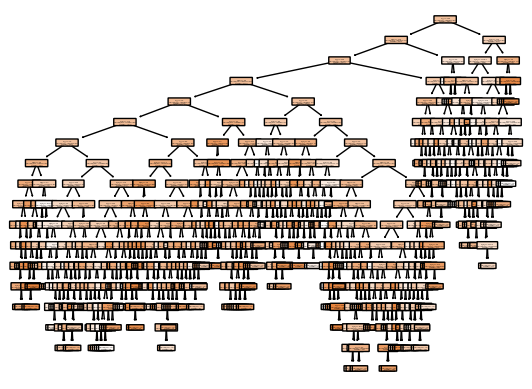

In [33]:
tree.plot_tree(model_dtr,filled=True, rounded=True)

# Regularization using Hyperparameter tuning

In [55]:
dtr = DecisionTreeRegressor(random_state=42)

# Define the hyperparameter grid to search
param_grid = {
    'max_depth': [5, 15, 25],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [2, 8, 12]
}

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=dtr, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)





KeyboardInterrupt: 

In [23]:
# Evaluate the model on the test set
dtr_gcv=DecisionTreeRegressor(random_state=42,**grid_search.best_params_)
model_dtr=dtr_gcv.fit(X_train,y_train)

In [24]:
ypred_train=dtr_gcv.predict(X_train)
ypred_test=dtr_gcv.predict(X_test)

In [25]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 1400363.9895034693
Mean squared error for test data: 1399686.6302196528


In [26]:
# Example: Cross-validation with 5 folds
scores = cross_val_score(dtr_gcv, X, y, cv=5, scoring='neg_mean_squared_error')
print("Cross-validated MSE:", -scores)

Cross-validated MSE: [ 9515777.03978463 12951244.86682166 11567435.09039036 11666715.79748654
 12182377.54642086]


In [27]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

9515777.03978463 12951244.866821663 11576710.06818081


In [28]:
dtr = DecisionTreeRegressor(random_state=42)

# Define the hyperparameter grid to search
param_grid = {
    'max_depth': [15, 25,35],
    'min_samples_split': [3,5,7],
    'min_samples_leaf': [1,2,3]
}

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=dtr, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'max_depth': 35, 'min_samples_leaf': 1, 'min_samples_split': 3}


In [29]:
# Evaluate the model on the test set
dtr_gcv=DecisionTreeRegressor(random_state=42,**grid_search.best_params_)
model_dtr=dtr_gcv.fit(X_train,y_train)

In [30]:
ypred_train=dtr_gcv.predict(X_train)
ypred_test=dtr_gcv.predict(X_test)

In [31]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 170083.7819072488
Mean squared error for test data: 176404.0630097663


In [32]:
# Example: Cross-validation with 5 folds
scores = cross_val_score(dtr_gcv, X, y, cv=5, scoring='neg_mean_squared_error')
print("Cross-validated MSE:", -scores)

Cross-validated MSE: [10645236.41834218 11451570.03223477 12422227.6194688  12943488.98785798
 12760127.98567791]


In [33]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

10645236.41834218 12943488.98785798 12044530.20871633


In [34]:
dtr = DecisionTreeRegressor(random_state=42)

# Define the hyperparameter grid to search
param_grid = {
    'max_depth': [25,35,45],
    'min_samples_split': [2,3,4],
    'min_samples_leaf': [0,1,2]
}

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=dtr, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
27 fits failed out of a total of 81.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
27 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 1247, in fit
    super().fit(
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 177, in fit
    self._validate_params()
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\base.py", line 

Best Hyperparameters: {'max_depth': 45, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [35]:
# Evaluate the model on the test set
dtr_gcv=DecisionTreeRegressor(random_state=42,**grid_search.best_params_)
model_dtr=dtr_gcv.fit(X_train,y_train)

In [36]:
ypred_train=dtr_gcv.predict(X_train)
ypred_test=dtr_gcv.predict(X_test)

In [37]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 7961.35123001932
Mean squared error for test data: 9352.212985420627


In [38]:
# Example: Cross-validation with 5 folds
scores = cross_val_score(dtr_gcv, X, y, cv=5, scoring='neg_mean_squared_error')
print("Cross-validated MSE:", -scores)

Cross-validated MSE: [10887694.85407392 11872594.00939929 12169680.26699647 12071853.13618375
 12815870.77540636]


In [39]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

10887694.854073917 12815870.77540636 11963538.608411957


# Random Forest Regressor

In [35]:
rfr=RandomForestRegressor(random_state=42,n_jobs=-1)
model_rfr=rfr.fit(X_train,y_train)

In [36]:
df_imp_rfr=pd.DataFrame({"feature":X_train.columns,"importance":model_rfr.feature_importances_})
df_imp_rfr.sort_values(by="importance",ascending=False).head(30)

,feature,importance
6,promotion_name,0.298262
7,media_type,0.234996
54,promotion_period,0.116607
18,store_manager,0.055062
43,grocery_sqft,0.039133
14,store_name,0.035716
42,store_sqft,0.019289
9,sales_state_province,0.019208
16,store_state,0.018294
20,state_province,0.017175


In [35]:
ypred_train=model_rfr.predict(X_train)
ypred_test=model_rfr.predict(X_test)

In [36]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 16.98282033392224
Mean squared error for test data: 63.14963190587241


In [38]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(RandomForestRegressor(random_state=42,n_jobs=-1), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [ 8105812.79609714  9772652.91621477 13292620.3736763 ]


In [39]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

8105812.796097141 13292620.3736763 10390362.02866274


# Regularization using Hyperparameter tuning

rfr=RandomForestRegressor(random_state=42,n_jobs=-1)

# Define the hyperparameter grid to search
param_grid = {"n_estimators":[50,100,150],
    'max_depth': [15,25,35],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [2,8,12]
}

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=rfr, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)


In [42]:
sample_size = 14000
X_train_sample = X_train.sample(n=sample_size, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]

In [43]:
rfr=RandomForestRegressor(random_state=42,n_jobs=-1)

# Define the hyperparameter grid to search
param_grid = {'max_depth': [15,25,35], 'min_samples_split': [5, 10, 15], 'min_samples_leaf': [2,8,12] }

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=rfr, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
grid_search.fit(X_train_sample, y_train_sample)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

KeyboardInterrupt: 

In [ ]:
# Evaluate the model on the test set
rfr_gcv=RandomForestRegressor(random_state=42,**grid_search.best_params_,n_jobs=-1)
model_rfr=rfr.fit(X_train,y_train)

In [ ]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

In [ ]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(rfr_gcv, X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

In [ ]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

# Ada Boost regressor

In [38]:
abr=AdaBoostRegressor(random_state=42)
model_abr=abr.fit(X_train,y_train)

In [39]:
df_imp_abr=pd.DataFrame({"feature":X_train.columns,"importance":model_abr.feature_importances_})
df_imp_abr.sort_values(by="importance",ascending=False).head(30)

,feature,importance
6,promotion_name,0.407110
7,media_type,0.189553
54,promotion_period,0.076447
11,sales_region,0.071779
42,store_sqft,0.050930
43,grocery_sqft,0.048154
18,store_manager,0.031176
20,state_province,0.024378
13,store_type,0.022182
45,meat_sqft,0.021251


In [41]:
ypred_train=model_abr.predict(X_train)
ypred_test=model_abr.predict(X_test)

In [42]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 7958533.26504906
Mean squared error for test data: 7999864.4087512335


In [43]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(AdaBoostRegressor(random_state=42), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [8949020.13438939 9924858.42296576 9476868.72953188]


In [44]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

8949020.134389387 9924858.422965761 9450249.09562901


In [33]:
abr_dt=AdaBoostRegressor(estimator=dtr,random_state=42)
model_abr_dt=abr_dt.fit(X_train,y_train)

In [34]:
ypred_train=model_abr_dt.predict(X_train)
ypred_test=model_abr_dt.predict(X_test)

In [35]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 0.0
Mean squared error for test data: 0.0


# Gradient boost regressor

In [40]:
gbr=GradientBoostingRegressor(random_state=42)
model_gbr=gbr.fit(X_train,y_train)

In [41]:
df_imp_gbr=pd.DataFrame({"feature":X_train.columns,"importance":model_gbr.feature_importances_})
df_imp_gbr.sort_values(by="importance",ascending=False).head(30)

,feature,importance
6,promotion_name,3.674277e-01
7,media_type,2.154790e-01
54,promotion_period,8.036705e-02
14,store_name,6.111561e-02
18,store_manager,4.652774e-02
43,grocery_sqft,3.679427e-02
10,sales_district,1.896038e-02
47,video_store,1.803858e-02
42,store_sqft,1.757873e-02
45,meat_sqft,1.688275e-02


In [46]:
ypred_train=model_gbr.predict(X_train)
ypred_test=model_gbr.predict(X_test)

In [47]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 4140035.635026965
Mean squared error for test data: 4150712.4784872187


In [48]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(GradientBoostingRegressor(random_state=42), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [ 8390458.52320344 10860116.2224136  10044801.40239494]


In [49]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

8390458.52320344 10860116.2224136 9765125.382670658


# XGBoost Regressor

In [42]:
xgbr=XGBRegressor(random_state=42)
model_xgbr=xgbr.fit(X_train,y_train)

In [43]:
df_imp_xgbr=pd.DataFrame({"feature":X_train.columns,"importance":model_xgbr.feature_importances_})
df_imp_xgbr.sort_values(by="importance",ascending=False).head(30)

,feature,importance
50,florist,0.109503
43,grocery_sqft,0.089531
47,video_store,0.078304
9,sales_state_province,0.074581
48,salad_bar,0.071347
11,sales_region,0.070888
18,store_manager,0.065442
14,store_name,0.055694
42,store_sqft,0.051072
54,promotion_period,0.050045


In [51]:
ypred_train=model_xgbr.predict(X_train)
ypred_test=model_xgbr.predict(X_test)

In [52]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 3477.0061092274686
Mean squared error for test data: 3845.830099981974


In [53]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(XGBRegressor(random_state=42), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [ 7872092.78152468 10559546.58145546 12804865.64500776]


In [54]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

7872092.781524678 12804865.645007756 10412168.335995963


# StackingRegressor

In [55]:
base_estimators=[
    ("XGBoostRegressor", XGBRegressor(random_state=42)),
    ("RandomForestRegressor", RandomForestRegressor(random_state=42, n_jobs=-1))
]
sr=StackingRegressor(estimators=base_estimators,final_estimator=DecisionTreeRegressor(random_state=42))
model_sr=sr.fit(X_train,y_train)

In [56]:
ypred_train=model_sr.predict(X_train)
ypred_test=model_sr.predict(X_test)

In [57]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 48.11651943462898
Mean squared error for test data: 103.15285138859444


In [58]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(sr, X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [17146864.06623134 16632501.63390434 17041971.32506467]


In [59]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

16632501.633904342 17146864.066231344 16940445.675066784


In [60]:
base_estimators=[
    ("DecisionTreeRegressor", DecisionTreeRegressor(random_state=42)),
    ("RandomForestRegressor", RandomForestRegressor(random_state=42, n_jobs=-1))
]
sr=StackingRegressor(estimators=base_estimators,final_estimator=XGBRegressor(random_state=42))
model_sr=sr.fit(X_train,y_train)

In [61]:
ypred_train=model_sr.predict(X_train)
ypred_test=model_sr.predict(X_test)

In [62]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 231.43773428805724
Mean squared error for test data: 228.72363007579978


In [63]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(StackingRegressor(estimators=[
    ("DecisionTreeRegressor", DecisionTreeRegressor(random_state=42)),
    ("RandomForestRegressor", RandomForestRegressor(random_state=42, n_jobs=-1))
],final_estimator=XGBRegressor(random_state=42)), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [11872345.94876856 10466749.42208176 15074702.52335143]


In [64]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

10466749.422081763 15074702.52335143 12471265.96473392


# keeping 43 columns where names are removed

In [75]:
#Taking columns that are needed
df_new=df1[['recyclable_package', 'low_fat', 'department', 'family', 'promotion_name', 'media_type', 'sales_district', 'sales_region', 'store_type', 'coffee_bar', 'video_store', 'salad_bar', 'prepared_food', 'florist', 'state_province', 'country', 'marital_status', 'yearly_income', 'gender', 'education','member_card', 'occupation', 'houseowner','store_sales', 'store_cost', 'unit_sales', 'SRP', 'gross_weight', 'net_weight', 'units_per_case', 'cases_per_pallet', 'shelf_width', 'shelf_height', 'shelf_depth', 'cost', 'store_sqft', 'grocery_sqft', 'frozen_sqft', 'meat_sqft', 'total_children', 'num_children_at_home', 'num_cars_owned', 'promotion_period']]

In [76]:
le=LabelEncoder()
df_new_num=df_new.select_dtypes(include=np.number)
df_new_cat=df_new.select_dtypes(exclude=np.number)

In [77]:
df_new_num

,recyclable_package,low_fat,coffee_bar,video_store,salad_bar,prepared_food,florist,store_sales,store_cost,unit_sales,...,shelf_depth,cost,store_sqft,grocery_sqft,frozen_sqft,meat_sqft,total_children,num_children_at_home,num_cars_owned,promotion_period
0,1,0,0,0,1,1,0,7.12,2.2784,4,...,19.90,12950,39696.0,24390.0,9184.0,6122.0,2,2,4,4
1,0,1,0,0,1,1,0,5.76,1.7856,4,...,11.00,12950,39696.0,24390.0,9184.0,6122.0,2,2,4,4
2,1,0,0,0,1,1,0,5.55,2.0535,3,...,5.17,12950,39696.0,24390.0,9184.0,6122.0,2,2,4,4
3,0,1,0,0,1,1,0,7.48,2.2440,2,...,10.40,12950,39696.0,24390.0,9184.0,6122.0,2,0,2,4
4,1,0,0,0,1,1,0,2.28,1.0488,4,...,8.98,12950,39696.0,24390.0,9184.0,6122.0,2,0,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70746,0,1,1,0,0,0,1,7.68,3.5328,3,...,20.70,13006,34452.0,27463.0,4193.0,2795.0,4,0,3,3
70747,1,0,1,0,0,0,1,2.85,0.8835,5,...,4.14,13006,34452.0,27463.0,4193.0,2795.0,4,0,3,3
70748,0,0,1,0,0,0,1,4.29,1.4586,3,...,21.10,13006,34452.0,27463.0,4193.0,2795.0,1,0,2,3
70749,1,1,1,0,0,0,1,5.18,2.0720,2,...,16.10,13006,34452.0,27463.0,4193.0,2795.0,1,0,2,3


In [78]:
df_new_cat

,department,family,promotion_name,media_type,sales_district,sales_region,store_type,state_province,country,marital_status,yearly_income,gender,education,member_card,occupation,houseowner
0,Household,Non-Consumable,Super Duper Savers,Cash Register Handout,Bremerton,North West,Supermarket,WA,USA,M,$30K - $50K,F,High School Degree,Bronze,Skilled Manual,Y
1,Dairy,Food,Super Duper Savers,Cash Register Handout,Bremerton,North West,Supermarket,WA,USA,M,$30K - $50K,F,High School Degree,Bronze,Skilled Manual,Y
2,Health and Hygiene,Non-Consumable,Super Duper Savers,Cash Register Handout,Bremerton,North West,Supermarket,WA,USA,M,$30K - $50K,F,High School Degree,Bronze,Skilled Manual,Y
3,Produce,Food,Super Duper Savers,Cash Register Handout,Bremerton,North West,Supermarket,WA,USA,S,$50K - $70K,M,High School Degree,Normal,Skilled Manual,Y
4,Canned Foods,Food,Super Duper Savers,Cash Register Handout,Bremerton,North West,Supermarket,WA,USA,S,$50K - $70K,M,High School Degree,Normal,Skilled Manual,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70746,Produce,Food,Savings Galore,In-Store Coupon,Victoria,Canada West,Mid-Size Grocery,BC,Canada,S,$110K - $130K,M,High School Degree,Silver,Management,Y
70747,Produce,Food,Savings Galore,In-Store Coupon,Victoria,Canada West,Mid-Size Grocery,BC,Canada,S,$110K - $130K,M,High School Degree,Silver,Management,Y
70748,Household,Non-Consumable,Savings Galore,In-Store Coupon,Victoria,Canada West,Mid-Size Grocery,BC,Canada,S,$90K - $110K,M,Bachelors Degree,Golden,Professional,Y
70749,Produce,Food,Savings Galore,In-Store Coupon,Victoria,Canada West,Mid-Size Grocery,BC,Canada,S,$90K - $110K,M,Bachelors Degree,Golden,Professional,Y


In [79]:
for col in df_new_cat.columns:
    df_new_cat[col] = le.fit_transform(df_new_cat[col])

In [80]:
df_new_cat

,department,family,promotion_name,media_type,sales_district,sales_region,store_type,state_province,country,marital_status,yearly_income,gender,education,member_card,occupation,houseowner
0,14,2,38,1,2,5,4,9,2,0,4,0,2,0,4,1
1,9,1,38,1,2,5,4,9,2,0,4,0,2,0,4,1
2,13,2,38,1,2,5,4,9,2,0,4,0,2,0,4,1
3,17,1,38,1,2,5,4,9,2,1,5,1,2,2,4,1
4,5,1,38,1,2,5,4,9,2,1,5,1,2,2,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70746,17,1,35,5,18,0,2,0,0,1,1,1,2,3,1,1
70747,17,1,35,5,18,0,2,0,0,1,1,1,2,3,1,1
70748,14,2,35,5,18,0,2,0,0,1,7,1,0,1,3,1
70749,17,1,35,5,18,0,2,0,0,1,7,1,0,1,3,1


In [81]:
df_new=pd.concat([df_new_cat,df_new_num],axis=1)

In [82]:
df_new

,department,family,promotion_name,media_type,sales_district,sales_region,store_type,state_province,country,marital_status,...,shelf_depth,cost,store_sqft,grocery_sqft,frozen_sqft,meat_sqft,total_children,num_children_at_home,num_cars_owned,promotion_period
0,14,2,38,1,2,5,4,9,2,0,...,19.90,12950,39696.0,24390.0,9184.0,6122.0,2,2,4,4
1,9,1,38,1,2,5,4,9,2,0,...,11.00,12950,39696.0,24390.0,9184.0,6122.0,2,2,4,4
2,13,2,38,1,2,5,4,9,2,0,...,5.17,12950,39696.0,24390.0,9184.0,6122.0,2,2,4,4
3,17,1,38,1,2,5,4,9,2,1,...,10.40,12950,39696.0,24390.0,9184.0,6122.0,2,0,2,4
4,5,1,38,1,2,5,4,9,2,1,...,8.98,12950,39696.0,24390.0,9184.0,6122.0,2,0,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70746,17,1,35,5,18,0,2,0,0,1,...,20.70,13006,34452.0,27463.0,4193.0,2795.0,4,0,3,3
70747,17,1,35,5,18,0,2,0,0,1,...,4.14,13006,34452.0,27463.0,4193.0,2795.0,4,0,3,3
70748,14,2,35,5,18,0,2,0,0,1,...,21.10,13006,34452.0,27463.0,4193.0,2795.0,1,0,2,3
70749,17,1,35,5,18,0,2,0,0,1,...,16.10,13006,34452.0,27463.0,4193.0,2795.0,1,0,2,3


In [83]:
#Setting target variable
X = df_new.drop(columns=['cost'])
y = df_new['cost']

In [84]:
#Splitting train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# linear regression

In [54]:
model_lr=sma.OLS(y_train,sma.add_constant(X_train)).fit()

In [55]:
model_lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   cost   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     59.04
Date:                Fri, 23 Feb 2024   Prob (F-statistic):               0.00
Time:                        17:12:12   Log-Likelihood:            -5.3169e+05
No. Observations:               56600   AIC:                         1.063e+06
Df Residuals:                   56557   BIC:                         1.064e+06
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1.599e+04    296.287     53.970      0.000    1.54e+04    1.66e+04
department              -2.0917      2.162     -0.967      0.333      -6.330       2.146
family                 -14.7290     25.553     -0.576      0.564     -64.812      35.354
promotion_name          -6.5221      0.932     -6.999      0.000      -8.349      -4.696
media_type             -20.3915      3.613     -5.644      0.000     -27.474     -13.310
sales_district         -21.3252      3.560     -5.991      0.000     -28.302     -14.348
sales_region          -219.2287     24.107     -9.094      0.000    -266.479    -171.978
store_type            -477.1799     28.159    -16.946      0.000    -532.372    -421.988
state_province         -48.4061      4.709    -10.280      0.000     -57.635     -39.177
country                 99.0202     66.051      1.499      0.134     -30.440     228.480
marital_status          10.0752     33.972      0.297      0.767     -56.511      76.661
yearly_income           -7.4193      7.927     -0.936      0.349     -22.957       8.118
gender                 -30.8149     24.595     -1.253      0.210     -79.022      17.392
education              -11.5289      9.834     -1.172      0.241     -30.803       7.745
member_card              2.6607     13.608      0.196      0.845     -24.011      29.333
occupation               1.7066     11.669      0.146      0.884     -21.165      24.578
houseowner              44.0724     26.161      1.685      0.092      -7.203      95.348
recyclable_package       1.7132     24.789      0.069      0.945     -46.874      50.300
low_fat                  4.1245     26.090      0.158      0.874     -47.012      55.261
coffee_bar            -472.2916     61.023     -7.740      0.000    -591.897    -352.686
video_store          -1248.1285     55.967    -22.301      0.000   -1357.823   -1138.434
salad_bar             1229.2643    157.926      7.784      0.000     919.728    1538.800
prepared_food        -1361.6154    151.264     -9.002      0.000   -1658.094   -1065.137
florist              -1099.1826     70.851    -15.514      0.000   -1238.050    -960.315
store_sales             -7.6892     19.322     -0.398      0.691     -45.559      30.181
store_cost              35.6233     28.113      1.267      0.205     -19.478      90.724
unit_sales              -7.3043     36.483     -0.200      0.841     -78.811      64.202
SRP                    -10.6515     50.284     -0.212      0.832    -109.209      87.906
gross_weight             7.6242     17.833      0.428      0.669     -27.328      42.576
net_weight              -8.6159     17.610     -0.489      0.625     -43.132      25.900
units_per_case           0.6283      1.196      0.525      0.599      -1.716       2.973
cases_per_pallet         0.5590      4.958      0.113    

In [56]:

significant_pvalues = model_lr.pvalues[model_lr.pvalues < 0.05]

# Print the significant p-values
if not significant_pvalues.empty:
    print("Significant p-values:")
    print(significant_pvalues)
else:
    print("No significant p-values.")

Significant p-values:
const                0.000000e+00
promotion_name       2.607811e-12
media_type           1.673703e-08
sales_district       2.098773e-09
sales_region         9.858535e-20
store_type           2.976763e-64
state_province       9.139738e-25
coffee_bar           1.014166e-14
video_store         1.068144e-109
salad_bar            7.157048e-15
prepared_food        2.292198e-19
florist              3.604813e-54
store_sqft           5.551037e-06
grocery_sqft         1.352897e-04
frozen_sqft          1.022572e-24
meat_sqft            1.091686e-24
total_children       8.290218e-03
num_cars_owned       9.742003e-05
promotion_period     1.141910e-76
dtype: float64


In [58]:
sig_pvalues_features=significant_pvalues.index

In [59]:
sig_pvalues_features.drop("const")

Index(['promotion_name', 'media_type', 'sales_district', 'sales_region',
       'store_type', 'state_province', 'coffee_bar', 'video_store',
       'salad_bar', 'prepared_food', 'florist', 'store_sqft', 'grocery_sqft',
       'frozen_sqft', 'meat_sqft', 'total_children', 'num_cars_owned',
       'promotion_period'],
      dtype='object')

In [60]:
len(significant_pvalues)

19

In [80]:
ypred_train=model_lr.predict(sma.add_constant(X_train))
ypred_test=model_lr.predict(sma.add_constant(X_test))

In [81]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 8452095.582594551
Mean squared error for test data: 8462043.020750405


In [82]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(LinearRegression(), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [10057177.55303104  9625478.74028105  8965429.92867728]


In [83]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

8965429.92867728 10057177.55303104 9549362.073996456


In [62]:
lr=LinearRegression()
model_sfs=sfs(estimator=lr,k_features="best",forward=False,scoring="neg_mean_squared_error",cv=3,n_jobs=-1)
model_sfs.fit(X_train,y_train)
model_sfs.k_feature_names_

('department',
 'promotion_name',
 'media_type',
 'sales_district',
 'sales_region',
 'store_type',
 'state_province',
 'marital_status',
 'yearly_income',
 'gender',
 'education',
 'houseowner',
 'coffee_bar',
 'video_store',
 'salad_bar',
 'prepared_food',
 'florist',
 'store_sales',
 'store_cost',
 'store_sqft',
 'grocery_sqft',
 'frozen_sqft',
 'meat_sqft',
 'total_children',
 'num_cars_owned',
 'promotion_period')

In [63]:
len(model_sfs.k_feature_names_)

26

# decision tree regressor
    

In [61]:
dtr=DecisionTreeRegressor(random_state=42)
model_dtr=dtr.fit(X_train,y_train)

In [64]:
df_imp_dt=pd.DataFrame({"feature":X_train.columns,"importance":model_dtr.feature_importances_})
df_imp_dt.sort_values(by="importance",ascending=False).head(30)

,feature,importance
3,media_type,0.279430
2,promotion_name,0.270229
41,promotion_period,0.099582
4,sales_district,0.068801
7,state_province,0.055318
35,grocery_sqft,0.046122
5,sales_region,0.043046
34,store_sqft,0.025651
37,meat_sqft,0.025602
36,frozen_sqft,0.025308


In [85]:
ypred_train=model_dtr.predict(X_train)
ypred_test=model_dtr.predict(X_test)

In [86]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 0.0
Mean squared error for test data: 316.30499611334886


In [87]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(DecisionTreeRegressor(random_state=42), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [11081855.73884837 12543754.30804783 13417923.89556036]


In [88]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

11081855.738848371 13417923.895560361 12347844.647485519


# regularization - hyperparameter tuning

In [75]:
dtr = DecisionTreeRegressor(random_state=42)

# Define the hyperparameter grid to search
param_grid = {
    'max_depth': [5, 15, 25],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [2, 8, 12]
}

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=dtr, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'max_depth': 25, 'min_samples_leaf': 2, 'min_samples_split': 5}


In [76]:
dtr_gcv=DecisionTreeRegressor(random_state=42,**grid_search.best_params_)
model_dtr=dtr_gcv.fit(X_train,y_train)

In [77]:
ypred_train=model_dtr.predict(X_train)
ypred_test=model_dtr.predict(X_test)

In [78]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 0.0
Mean squared error for test data: 316.30499611334886


In [79]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(dtr_gcv, X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [11081855.73884837 12543754.30804783 13417923.89556036]


In [80]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

11081855.738848371 13417923.895560361 12347844.647485519


In [ ]:
dtr=DecisionTreeRegressor(random_state=42,max_depth=5)
model_dtr=dtr.fit(X_train,y_train)

In [ ]:
ypred_train=model_dtr.predict(X_train)
ypred_test=model_dtr.predict(X_test)

In [ ]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

# random forest regressor

In [65]:
rfr=RandomForestRegressor(random_state=42,n_jobs=-1)
model_rfr=rfr.fit(X_train,y_train)

In [66]:
df_imp_rf=pd.DataFrame({"feature":X_train.columns,"importance":model_rfr.feature_importances_})
df_imp_rf.sort_values(by="importance",ascending=False).head(30)

,feature,importance
2,promotion_name,0.325029
3,media_type,0.230134
41,promotion_period,0.121500
7,state_province,0.053087
35,grocery_sqft,0.050512
4,sales_district,0.044453
34,store_sqft,0.035129
37,meat_sqft,0.023667
36,frozen_sqft,0.023436
6,store_type,0.021714


In [90]:
ypred_train=model_rfr.predict(X_train)
ypred_test=model_rfr.predict(X_test)

In [91]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 9.408211150176635
Mean squared error for test data: 114.98170595717616


In [92]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(RandomForestRegressor(random_state=42,n_jobs=-1), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [ 8257699.91146861 10205817.74534336 11730875.76960075]


In [93]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

8257699.911468615 11730875.76960075 10064797.808804244


# Ada Boost regressor

In [67]:
abr=AdaBoostRegressor(random_state=42)
model_abr=abr.fit(X_train,y_train)

In [68]:
df_imp_abr=pd.DataFrame({"feature":X_train.columns,"importance":model_abr.feature_importances_})
df_imp_abr.sort_values(by="importance",ascending=False).head(30)

,feature,importance
2,promotion_name,0.405924
3,media_type,0.155664
41,promotion_period,0.095319
34,store_sqft,0.083554
5,sales_region,0.061526
7,state_province,0.057103
4,sales_district,0.042853
35,grocery_sqft,0.038981
37,meat_sqft,0.022715
19,video_store,0.020405


In [95]:
ypred_train=model_abr.predict(X_train)
ypred_test=model_abr.predict(X_test)

In [96]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 7978446.901048294
Mean squared error for test data: 8001445.335676345


In [97]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(AdaBoostRegressor(random_state=42), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [8949076.835955   9601003.82935371 8909614.31643351]


In [98]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

8909614.316433514 9601003.829353709 9153231.66058074


In [99]:
abr_dt=AdaBoostRegressor(estimator=dtr,random_state=42)
model_abr_dt=abr_dt.fit(X_train,y_train)

In [100]:
ypred_train=model_abr_dt.predict(X_train)
ypred_test=model_abr_dt.predict(X_test)

In [101]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 0.0
Mean squared error for test data: 0.0


In [102]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(abr_dt, X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [13962331.07971506 12820982.84095149 15856301.93906628]


In [103]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

12820982.840951493 15856301.939066276 14213205.28657761


# Gradient boost regressor

In [69]:
gbr=GradientBoostingRegressor(random_state=42)
model_gbr=gbr.fit(X_train,y_train)

In [70]:
df_imp_gbr=pd.DataFrame({"feature":X_train.columns,"importance":model_gbr.feature_importances_})
df_imp_gbr.sort_values(by="importance",ascending=False).head(30)

,feature,importance
2,promotion_name,3.959946e-01
3,media_type,1.836820e-01
41,promotion_period,1.032872e-01
35,grocery_sqft,6.246996e-02
4,sales_district,4.429981e-02
7,state_province,3.487891e-02
36,frozen_sqft,3.030724e-02
34,store_sqft,2.475981e-02
37,meat_sqft,2.386799e-02
6,store_type,2.384405e-02


In [105]:
ypred_train=model_gbr.predict(X_train)
ypred_test=model_gbr.predict(X_test)

In [106]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 4207268.794215593
Mean squared error for test data: 4228130.378786204


In [107]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(GradientBoostingRegressor(random_state=42), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [ 8750951.73045077 10802401.32753941  9690007.08023583]


In [108]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

8750951.730450772 10802401.32753941 9747786.712742003


# XGBoost Regressor

In [85]:
xgbr=XGBRegressor(random_state=42)
model_xgbr=xgbr.fit(X_train,y_train)

In [87]:
df_imp_xgbr=pd.DataFrame({"feature":X_train.columns,"importance":model_xgbr.feature_importances_})
df_imp_xgbr.sort_values(by="importance",ascending=False).head(30)

,feature,importance
35,grocery_sqft,0.104881
19,video_store,0.099568
7,state_province,0.085715
18,coffee_bar,0.077479
41,promotion_period,0.074666
6,store_type,0.071994
22,florist,0.071492
34,store_sqft,0.070915
20,salad_bar,0.055764
36,frozen_sqft,0.054548


In [89]:
df_imp_xgbr.sort_values(by="importance",ascending=False).head(30)["feature"].values

array(['grocery_sqft', 'video_store', 'state_province', 'coffee_bar',
       'promotion_period', 'store_type', 'florist', 'store_sqft',
       'salad_bar', 'frozen_sqft', 'media_type', 'promotion_name',
       'sales_district', 'sales_region', 'prepared_food', 'country',
       'unit_sales', 'total_children', 'occupation', 'gender',
       'num_children_at_home', 'gross_weight', 'shelf_depth',
       'net_weight', 'education', 'num_cars_owned', 'store_cost',
       'department', 'shelf_height', 'shelf_width'], dtype=object)

In [110]:
ypred_train=model_xgbr.predict(X_train)
ypred_test=model_xgbr.predict(X_test)

In [111]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 2415.7261467506146
Mean squared error for test data: 2828.5818319325226


In [112]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(XGBRegressor(random_state=42), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [ 7410031.6417764  11054396.81941441 10880615.85761521]


In [113]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

7410031.6417764 11054396.819414413 9781681.439602008


# StackingRegressor

In [73]:
base_estimators=[
    ("XGBoostRegressor", XGBRegressor(random_state=42)),
    ("RandomForestRegressor", RandomForestRegressor(random_state=42, n_jobs=-1))
]
sr=StackingRegressor(estimators=base_estimators,final_estimator=DecisionTreeRegressor(random_state=42))
model_sr=sr.fit(X_train,y_train)

In [115]:
ypred_train=model_sr.predict(X_train)
ypred_test=model_sr.predict(X_test)

In [116]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 16.059010600706713
Mean squared error for test data: 129.87704049183804


In [117]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(StackingRegressor(estimators=[
    ("XGBoostRegressor", XGBRegressor(random_state=42)),
    ("RandomForestRegressor", RandomForestRegressor(random_state=42, n_jobs=-1))
],final_estimator=DecisionTreeRegressor(random_state=42)), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [16954506.69771879 13807924.84417402 15874684.27044905]


In [118]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

13807924.844174016 16954506.69771879 15545705.270780621


In [119]:
base_estimators=[
    ("DecisionTreeRegressor", DecisionTreeRegressor(random_state=42)),
    ("RandomForestRegressor", RandomForestRegressor(random_state=42, n_jobs=-1))
]
sr=StackingRegressor(estimators=base_estimators,final_estimator=XGBRegressor(random_state=42))
model_sr=sr.fit(X_train,y_train)

In [120]:
ypred_train=model_sr.predict(X_train)
ypred_test=model_sr.predict(X_test)

In [121]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 217.2821901652122
Mean squared error for test data: 525.9256105643516


In [122]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(StackingRegressor(estimators=[
    ("DecisionTreeRegressor", DecisionTreeRegressor(random_state=42)),
    ("RandomForestRegressor", RandomForestRegressor(random_state=42, n_jobs=-1))
],final_estimator=XGBRegressor(random_state=42)), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [14861228.81604248 10457188.53272925 17298525.47242135]


In [132]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

10848837.448836202 12867344.990813788 12162850.568679482


In [ ]:
df1.columns

In [81]:
li=['store_sales', 'store_cost', 'unit_sales','brand_name', 'product_name','SRP', 'gross_weight',
       'net_weight', 'recyclable_package', 'low_fat', 'units_per_case',
       'cases_per_pallet', 'shelf_width', 'shelf_height', 'shelf_depth',
       'subcategory', 'category', 'department', 'family','promotion_name', 'media_type', 'cost','sales_city',
       'sales_state_province', 'sales_district', 'sales_region',
       'sales_country','store_type', 'store_name','store_city', 'store_state','store_country', 'store_manager','store_sqft',
       'grocery_sqft', 'frozen_sqft', 'meat_sqft', 'coffee_bar', 'video_store',
       'salad_bar', 'prepared_food', 'florist','city',
       'state_province','country','marital_status', 'yearly_income',
       'gender', 'total_children', 'num_children_at_home', 'education','member_card', 'occupation', 'houseowner',
       'num_cars_owned','promotion_period']

In [82]:
len(li)

56

In [ ]:
['recyclable_package', 'low_fat', 'department', 'family', 'promotion_name', 'media_type', 'sales_district', 
'sales_region', 'store_type', 'coffee_bar', 'video_store', 'salad_bar', 'prepared_food', 'florist', 'state_province',
'country', 'marital_status', 'yearly_income', 'gender', 'education','member_card', 'occupation', 'houseowner','store_sales',
'store_cost', 'unit_sales', 'SRP', 'gross_weight', 'net_weight', 'units_per_case', 'cases_per_pallet', 'shelf_width',
'shelf_height', 'shelf_depth', 'cost', 'store_sqft', 'grocery_sqft', 'frozen_sqft', 'meat_sqft', 'total_children',
'num_children_at_home', 'num_cars_owned', 'promotion_period']

# selecting 31 columns based on domain

In [84]:
df1['sales_district']

0        Bremerton
1        Bremerton
2        Bremerton
3        Bremerton
4        Bremerton
           ...    
70746     Victoria
70747     Victoria
70748     Victoria
70749     Victoria
70750     Victoria
Name: sales_district, Length: 70751, dtype: object

In [86]:
df1['sales_region']

0         North West
1         North West
2         North West
3         North West
4         North West
            ...     
70746    Canada West
70747    Canada West
70748    Canada West
70749    Canada West
70750    Canada West
Name: sales_region, Length: 70751, dtype: object

In [87]:
df1['state_province']

0        WA
1        WA
2        WA
3        WA
4        WA
         ..
70746    BC
70747    BC
70748    BC
70749    BC
70750    BC
Name: state_province, Length: 70751, dtype: object

* selecting a few out of the location columns, omitting few store space related, shelf related,consumer related and cases related columns

In [92]:
l=['recyclable_package', 'low_fat', 'department', 'family', 'promotion_name', 'media_type', 'sales_district', 
'store_type', 'coffee_bar', 'video_store', 'salad_bar', 'prepared_food', 'florist',
'country', 'marital_status', 'yearly_income', 'gender', 'education','member_card', 'occupation', 'store_sales',
'store_cost', 'unit_sales', 'SRP', 'gross_weight', 'net_weight', 'cost', 'store_sqft', 'grocery_sqft', 'total_children',
'promotion_period']

In [93]:
len(l)

31

In [95]:
df_fresh=df1[['recyclable_package', 'low_fat', 'department', 'family', 'promotion_name', 'media_type', 'sales_district', 
'store_type', 'coffee_bar', 'video_store', 'salad_bar', 'prepared_food', 'florist',
'country', 'marital_status', 'yearly_income', 'gender', 'education','member_card', 'occupation', 'store_sales',
'store_cost', 'unit_sales', 'SRP', 'gross_weight', 'net_weight', 'cost', 'store_sqft', 'grocery_sqft', 'total_children',
'promotion_period']]

In [96]:
le=LabelEncoder()
df_fresh_num=df_fresh.select_dtypes(include=np.number)
df_fresh_cat=df_fresh.select_dtypes(exclude=np.number)

In [97]:
df_fresh_num

,recyclable_package,low_fat,coffee_bar,video_store,salad_bar,prepared_food,florist,store_sales,store_cost,unit_sales,SRP,gross_weight,net_weight,cost,store_sqft,grocery_sqft,total_children,promotion_period
0,1,0,0,0,1,1,0,7.12,2.2784,4,1.78,13.40,11.30,12950,39696.0,24390.0,2,4
1,0,1,0,0,1,1,0,5.76,1.7856,4,1.44,8.25,5.25,12950,39696.0,24390.0,2,4
2,1,0,0,0,1,1,0,5.55,2.0535,3,1.85,7.12,4.11,12950,39696.0,24390.0,2,4
3,0,1,0,0,1,1,0,7.48,2.2440,2,3.74,13.10,12.10,12950,39696.0,24390.0,2,4
4,1,0,0,0,1,1,0,2.28,1.0488,4,0.57,16.90,14.80,12950,39696.0,24390.0,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70746,0,1,1,0,0,0,1,7.68,3.5328,3,2.56,10.50,8.50,13006,34452.0,27463.0,4,3
70747,1,0,1,0,0,0,1,2.85,0.8835,5,0.57,9.30,7.30,13006,34452.0,27463.0,4,3
70748,0,0,1,0,0,0,1,4.29,1.4586,3,1.43,10.20,7.19,13006,34452.0,27463.0,1,3
70749,1,1,1,0,0,0,1,5.18,2.0720,2,2.59,9.77,7.77,13006,34452.0,27463.0,1,3


In [98]:
df_fresh_cat

,department,family,promotion_name,media_type,sales_district,store_type,country,marital_status,yearly_income,gender,education,member_card,occupation
0,Household,Non-Consumable,Super Duper Savers,Cash Register Handout,Bremerton,Supermarket,USA,M,$30K - $50K,F,High School Degree,Bronze,Skilled Manual
1,Dairy,Food,Super Duper Savers,Cash Register Handout,Bremerton,Supermarket,USA,M,$30K - $50K,F,High School Degree,Bronze,Skilled Manual
2,Health and Hygiene,Non-Consumable,Super Duper Savers,Cash Register Handout,Bremerton,Supermarket,USA,M,$30K - $50K,F,High School Degree,Bronze,Skilled Manual
3,Produce,Food,Super Duper Savers,Cash Register Handout,Bremerton,Supermarket,USA,S,$50K - $70K,M,High School Degree,Normal,Skilled Manual
4,Canned Foods,Food,Super Duper Savers,Cash Register Handout,Bremerton,Supermarket,USA,S,$50K - $70K,M,High School Degree,Normal,Skilled Manual
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70746,Produce,Food,Savings Galore,In-Store Coupon,Victoria,Mid-Size Grocery,Canada,S,$110K - $130K,M,High School Degree,Silver,Management
70747,Produce,Food,Savings Galore,In-Store Coupon,Victoria,Mid-Size Grocery,Canada,S,$110K - $130K,M,High School Degree,Silver,Management
70748,Household,Non-Consumable,Savings Galore,In-Store Coupon,Victoria,Mid-Size Grocery,Canada,S,$90K - $110K,M,Bachelors Degree,Golden,Professional
70749,Produce,Food,Savings Galore,In-Store Coupon,Victoria,Mid-Size Grocery,Canada,S,$90K - $110K,M,Bachelors Degree,Golden,Professional


In [99]:
for col in df_fresh_cat.columns:
    df_fresh_cat[col] = le.fit_transform(df_fresh_cat[col])

In [100]:
df_fresh_cat

,department,family,promotion_name,media_type,sales_district,store_type,country,marital_status,yearly_income,gender,education,member_card,occupation
0,14,2,38,1,2,4,2,0,4,0,2,0,4
1,9,1,38,1,2,4,2,0,4,0,2,0,4
2,13,2,38,1,2,4,2,0,4,0,2,0,4
3,17,1,38,1,2,4,2,1,5,1,2,2,4
4,5,1,38,1,2,4,2,1,5,1,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70746,17,1,35,5,18,2,0,1,1,1,2,3,1
70747,17,1,35,5,18,2,0,1,1,1,2,3,1
70748,14,2,35,5,18,2,0,1,7,1,0,1,3
70749,17,1,35,5,18,2,0,1,7,1,0,1,3


In [101]:
df_fresh=pd.concat([df_fresh_cat,df_fresh_num],axis=1)

In [102]:
#Setting target variable
X = df_fresh.drop(columns=['cost'])
y = df_fresh['cost']

In [103]:
#Splitting train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression

In [170]:
model_lr=sma.OLS(y_train,sma.add_constant(X_train)).fit()

In [171]:
model_lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   cost   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     73.72
Date:                Sat, 24 Feb 2024   Prob (F-statistic):               0.00
Time:                        00:35:59   Log-Likelihood:            -5.3182e+05
No. Observations:               56600   AIC:                         1.064e+06
Df Residuals:                   56569   BIC:                         1.064e+06
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.451e+04    216.366     67.074      0.000    1.41e+04    1.49e+04
department            -2.2204      2.165     -1.026      0.305      -6.464       2.023
family               -11.8472     25.549     -0.464      0.643     -61.924      38.230
promotion_name        -6.2498      0.932     -6.704      0.000      -8.077      -4.423
media_type           -23.6974      3.591     -6.599      0.000     -30.735     -16.659
sales_district       -36.6850      2.882    -12.727      0.000     -42.335     -31.035
store_type          -302.2070     19.268    -15.684      0.000    -339.973    -264.441
country             -352.1794     25.760    -13.671      0.000    -402.670    -301.689
marital_status        24.1756     24.635      0.981      0.326     -24.108      72.460
yearly_income         -0.0801      7.515     -0.011      0.991     -14.810      14.650
gender               -21.8974     24.610     -0.890      0.374     -70.133      26.338
education            -13.0830      9.831     -1.331      0.183     -32.352       6.186
member_card           -1.6775     13.421     -0.125      0.901     -27.982      24.627
occupation            -3.3513     11.680     -0.287      0.774     -26.244      19.541
recyclable_package     1.8089     24.747      0.073      0.942     -46.696      50.313
low_fat                4.2928     26.110      0.164      0.869     -46.883      55.469
coffee_bar          -210.3232     46.970     -4.478      0.000    -302.385    -118.261
video_store         -983.3648     41.386    -23.761      0.000   -1064.481    -902.248
salad_bar            225.1297     86.571      2.601      0.009      55.451     394.809
prepared_food       -387.3659     85.218     -4.546      0.000    -554.393    -220.338
florist             -691.7149     52.555    -13.162      0.000    -794.723    -588.707
store_sales           -7.2238     19.362     -0.373      0.709     -45.173      30.725
store_cost            34.1704     28.169      1.213      0.225     -21.042      89.383
unit_sales           -19.9253     36.514     -0.546      0.585     -91.492      51.641
SRP                  -10.9456     50.383     -0.217      0.828    -109.696      87.805
gross_weight           8.9156     17.861      0.499      0.618     -26.093      43.924
net_weight            -9.9158     17.638     -0.562      0.574     -44.486      24.655
store_sqft            -0.0153      0.007     -2.325      0.020      -0.028      -0.002
grocery_sqft          -0.0508      0.010     -5.322      0.000      -0.070      -0.032
total_children       -26.3057      8.355     -3.148      0.002     -42.682      -9.929
promotion_period     -65.9853      3.316    -19.899      0.000     -72.485     -59.486
==============================================================================
Omnibus:                    28080.526   Durbin

In [105]:
significant_pvalues = model_lr.pvalues[model_lr.pvalues < 0.05]

# Print the significant p-values
if not significant_pvalues.empty:
    print("Significant p-values:")
    print(significant_pvalues)
else:
    print("No significant p-values.")

Significant p-values:
const                0.000000e+00
promotion_name       2.048596e-11
media_type           4.165130e-11
sales_district       4.714483e-37
store_type           2.534865e-55
country              1.758398e-42
coffee_bar           7.556942e-06
video_store         3.456866e-124
salad_bar            9.310282e-03
prepared_food        5.489285e-06
florist              1.665190e-39
store_sqft           2.007729e-02
grocery_sqft         1.030361e-07
total_children       1.642595e-03
promotion_period     8.292755e-88
dtype: float64


In [106]:
sig_pvalues_features=significant_pvalues.index

In [107]:
sig_pvalues_features.drop("const")

Index(['promotion_name', 'media_type', 'sales_district', 'store_type',
       'country', 'coffee_bar', 'video_store', 'salad_bar', 'prepared_food',
       'florist', 'store_sqft', 'grocery_sqft', 'total_children',
       'promotion_period'],
      dtype='object')

In [108]:
len(significant_pvalues)

15

In [109]:
ypred_train=model_lr.predict(sma.add_constant(X_train))
ypred_test=model_lr.predict(sma.add_constant(X_test))

In [110]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 8490699.114305213
Mean squared error for test data: 8505294.514988376


In [111]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(LinearRegression(), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [9054454.67748693 9672431.24210726 8894258.62711911]


In [112]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

8894258.627119115 9672431.242107257 9207048.182237769


In [ ]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

In [113]:
lr=LinearRegression()
model_sfs=sfs(estimator=lr,k_features="best",forward=False,scoring="neg_mean_squared_error",cv=3,n_jobs=-1)
model_sfs.fit(X_train,y_train)
model_sfs.k_feature_names_

('department',
 'promotion_name',
 'media_type',
 'sales_district',
 'store_type',
 'country',
 'marital_status',
 'gender',
 'education',
 'coffee_bar',
 'video_store',
 'salad_bar',
 'prepared_food',
 'florist',
 'store_cost',
 'unit_sales',
 'grocery_sqft',
 'total_children',
 'promotion_period')

In [114]:
len(model_sfs.k_feature_names_)

19

# Decision Tree Regressor

In [115]:
dtr=DecisionTreeRegressor(random_state=42)
model_dtr=dtr.fit(X_train,y_train)

In [117]:
df_imp_dt=pd.DataFrame({"feature":X_train.columns,"importance":model_dtr.feature_importances_})
df_imp_dt.sort_values(by="importance",ascending=False).head(15)

,feature,importance
2,promotion_name,0.265918
3,media_type,0.265079
4,sales_district,0.134083
29,promotion_period,0.112658
26,store_sqft,0.060747
27,grocery_sqft,0.052237
5,store_type,0.036166
16,video_store,0.031451
6,country,0.025321
15,coffee_bar,0.007200


In [118]:
ypred_train=model_dtr.predict(X_train)
ypred_test=model_dtr.predict(X_test)

In [119]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 0.0
Mean squared error for test data: 0.0


In [120]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(DecisionTreeRegressor(random_state=42), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [14601138.14866011 13084890.14221506 12940479.12021371]


In [121]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

12940479.120213713 14601138.148660108 13542169.137029627


# Random Forest Regressor

In [122]:
rfr=RandomForestRegressor(random_state=42,n_jobs=-1)
model_rfr=rfr.fit(X_train,y_train)

In [123]:
df_imp_rf=pd.DataFrame({"feature":X_train.columns,"importance":model_rfr.feature_importances_})
df_imp_rf.sort_values(by="importance",ascending=False).head(15)

,feature,importance
2,promotion_name,0.324090
3,media_type,0.233484
29,promotion_period,0.117063
4,sales_district,0.079093
27,grocery_sqft,0.075436
26,store_sqft,0.057672
5,store_type,0.027606
16,video_store,0.022149
6,country,0.017119
15,coffee_bar,0.016431


In [124]:
ypred_train=model_rfr.predict(X_train)
ypred_test=model_rfr.predict(X_test)

In [125]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 5.597642413427544
Mean squared error for test data: 14.158298431206253


In [126]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(RandomForestRegressor(random_state=42,n_jobs=-1), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [11141282.00222328 10208442.92919033 11544818.40958847]


In [127]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

10208442.929190326 11544818.409588465 10964847.780334024


# Ada Boost Regressor

In [128]:
abr=AdaBoostRegressor(random_state=42)
model_abr=abr.fit(X_train,y_train)

In [129]:
df_imp_abr=pd.DataFrame({"feature":X_train.columns,"importance":model_abr.feature_importances_})
df_imp_abr.sort_values(by="importance",ascending=False).head(15)

,feature,importance
2,promotion_name,0.279964
3,media_type,0.245057
26,store_sqft,0.177014
29,promotion_period,0.149245
27,grocery_sqft,0.119880
4,sales_district,0.015502
17,salad_bar,0.013337
28,total_children,0.000000
25,net_weight,0.000000
24,gross_weight,0.000000


In [130]:
ypred_train=model_abr.predict(X_train)
ypred_test=model_abr.predict(X_test)

In [131]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 8237221.683612272
Mean squared error for test data: 8261774.628594911


In [132]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(AdaBoostRegressor(random_state=42), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [ 8992450.15116215 10767431.8937672   8579365.67037786]


In [133]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

8579365.67037786 10767431.893767199 9446415.905102402


# Gradient Boost Regressor

In [134]:
gbr=GradientBoostingRegressor(random_state=42)
model_gbr=gbr.fit(X_train,y_train)

In [135]:
df_imp_gbr=pd.DataFrame({"feature":X_train.columns,"importance":model_gbr.feature_importances_})
df_imp_gbr.sort_values(by="importance",ascending=False).head(15)

,feature,importance
2,promotion_name,4.013069e-01
3,media_type,2.111452e-01
29,promotion_period,9.278036e-02
4,sales_district,7.442763e-02
27,grocery_sqft,7.373691e-02
26,store_sqft,6.175715e-02
5,store_type,2.176787e-02
16,video_store,1.745707e-02
19,florist,1.182239e-02
18,prepared_food,1.122123e-02


In [136]:
ypred_train=model_gbr.predict(X_train)
ypred_test=model_gbr.predict(X_test)

In [137]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 4264215.251894146
Mean squared error for test data: 4305355.978510106


In [138]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(GradientBoostingRegressor(random_state=42), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [ 9071956.62426872 10812837.7095963   9680339.12938766]


In [139]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

9071956.624268716 10812837.709596297 9855044.487750892


# XGBoostRegressor

In [104]:
xgbr=XGBRegressor(random_state=42)
model_xgbr=xgbr.fit(X_train,y_train)

In [105]:
df_imp_xgbr=pd.DataFrame({"feature":X_train.columns,"importance":model_xgbr.feature_importances_})
df_imp_xgbr.sort_values(by="importance",ascending=False).head(15)

,feature,importance
16,video_store,0.158815
27,grocery_sqft,0.102522
26,store_sqft,0.092425
19,florist,0.081471
4,sales_district,0.079101
2,promotion_name,0.074719
3,media_type,0.073806
29,promotion_period,0.073075
18,prepared_food,0.061866
17,salad_bar,0.054998


In [106]:
ypred_train=model_xgbr.predict(X_train)
ypred_test=model_xgbr.predict(X_test)

In [107]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 1958.955681383635
Mean squared error for test data: 2119.228434980973


In [108]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(XGBRegressor(random_state=42), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [10350739.94889473 11981253.48804456 10959968.71717643]


In [109]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

10350739.948894726 11981253.488044564 11097320.718038574


# Stacking Regressor

In [110]:
base_estimators=[
    ("XGBoostRegressor", XGBRegressor(random_state=42)),
    ("RandomForestRegressor", RandomForestRegressor(random_state=42, n_jobs=-1))
]
sr=StackingRegressor(estimators=base_estimators,final_estimator=DecisionTreeRegressor(random_state=42))
model_sr=sr.fit(X_train,y_train)

In [111]:
ypred_train=model_sr.predict(X_train)
ypred_test=model_sr.predict(X_test)

In [112]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 18.538303886925796
Mean squared error for test data: 32.807080771676915


In [113]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(StackingRegressor(estimators=[
    ("XGBoostRegressor", XGBRegressor(random_state=42)),
    ("RandomForestRegressor", RandomForestRegressor(random_state=42, n_jobs=-1))
],final_estimator=DecisionTreeRegressor(random_state=42)), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [14298714.62856174 15206998.36741011 13148282.66751474]


In [114]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

13148282.667514736 15206998.367410108 14217998.554495526


In [150]:
base_estimators=[
    ("DecisionTreeRegressor", DecisionTreeRegressor(random_state=42)),
    ("RandomForestRegressor", RandomForestRegressor(random_state=42, n_jobs=-1))
]
sr=StackingRegressor(estimators=base_estimators,final_estimator=XGBRegressor(random_state=42))
model_sr=sr.fit(X_train,y_train)

In [151]:
ypred_train=model_sr.predict(X_train)
ypred_test=model_sr.predict(X_test)

In [152]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 235.85996235024382
Mean squared error for test data: 232.54514891394842


In [153]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(StackingRegressor(estimators=[
    ("DecisionTreeRegressor", DecisionTreeRegressor(random_state=42)),
    ("RandomForestRegressor", RandomForestRegressor(random_state=42, n_jobs=-1))
],final_estimator=XGBRegressor(random_state=42)), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [13720935.79363335 12412020.54968856 16234849.78301016]


In [154]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

12412020.54968856 16234849.783010159 14122602.042110687


# selecting 31 columns using SFS

In [11]:
df_fresh_sfs=df1[['department',
 'promotion_name',
 'media_type',
 'sales_city',
 'sales_district',
 'sales_region',
 'sales_country',
 'store_type',
 'store_name',
 'city',
 'country',
 'marital_status',
 'yearly_income',
 'gender',
 'education',
 'houseowner',
 'store_cost',
 'unit_sales',
 'store_sqft',
 'grocery_sqft',
 'frozen_sqft',
 'meat_sqft',
 'coffee_bar',
 'video_store',
 'salad_bar',
 'prepared_food',
 'florist',
 'total_children',
 'num_cars_owned',
 'promotion_period',"cost"]]

In [12]:
df_fresh_sfs

,department,promotion_name,media_type,sales_city,sales_district,sales_region,sales_country,store_type,store_name,city,...,meat_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,total_children,num_cars_owned,promotion_period,cost
0,Household,Super Duper Savers,Cash Register Handout,Bremerton,Bremerton,North West,USA,Supermarket,Store 3,Port Orchard,...,6122.0,0,0,1,1,0,2,4,4,12950
1,Dairy,Super Duper Savers,Cash Register Handout,Bremerton,Bremerton,North West,USA,Supermarket,Store 3,Port Orchard,...,6122.0,0,0,1,1,0,2,4,4,12950
2,Health and Hygiene,Super Duper Savers,Cash Register Handout,Bremerton,Bremerton,North West,USA,Supermarket,Store 3,Port Orchard,...,6122.0,0,0,1,1,0,2,4,4,12950
3,Produce,Super Duper Savers,Cash Register Handout,Bremerton,Bremerton,North West,USA,Supermarket,Store 3,Bremerton,...,6122.0,0,0,1,1,0,2,2,4,12950
4,Canned Foods,Super Duper Savers,Cash Register Handout,Bremerton,Bremerton,North West,USA,Supermarket,Store 3,Bremerton,...,6122.0,0,0,1,1,0,2,2,4,12950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70746,Produce,Savings Galore,In-Store Coupon,Victoria,Victoria,Canada West,Canada,Mid-Size Grocery,Store 20,Victoria,...,2795.0,1,0,0,0,1,4,3,3,13006
70747,Produce,Savings Galore,In-Store Coupon,Victoria,Victoria,Canada West,Canada,Mid-Size Grocery,Store 20,Victoria,...,2795.0,1,0,0,0,1,4,3,3,13006
70748,Household,Savings Galore,In-Store Coupon,Victoria,Victoria,Canada West,Canada,Mid-Size Grocery,Store 20,Victoria,...,2795.0,1,0,0,0,1,1,2,3,13006
70749,Produce,Savings Galore,In-Store Coupon,Victoria,Victoria,Canada West,Canada,Mid-Size Grocery,Store 20,Victoria,...,2795.0,1,0,0,0,1,1,2,3,13006


In [13]:
le=LabelEncoder()
df_fresh_sfs_num=df_fresh_sfs.select_dtypes(include=np.number)
df_fresh_sfs_cat=df_fresh_sfs.select_dtypes(exclude=np.number)

In [14]:
df_fresh_sfs_num

,store_cost,unit_sales,store_sqft,grocery_sqft,frozen_sqft,meat_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,total_children,num_cars_owned,promotion_period,cost
0,2.2784,4,39696.0,24390.0,9184.0,6122.0,0,0,1,1,0,2,4,4,12950
1,1.7856,4,39696.0,24390.0,9184.0,6122.0,0,0,1,1,0,2,4,4,12950
2,2.0535,3,39696.0,24390.0,9184.0,6122.0,0,0,1,1,0,2,4,4,12950
3,2.2440,2,39696.0,24390.0,9184.0,6122.0,0,0,1,1,0,2,2,4,12950
4,1.0488,4,39696.0,24390.0,9184.0,6122.0,0,0,1,1,0,2,2,4,12950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70746,3.5328,3,34452.0,27463.0,4193.0,2795.0,1,0,0,0,1,4,3,3,13006
70747,0.8835,5,34452.0,27463.0,4193.0,2795.0,1,0,0,0,1,4,3,3,13006
70748,1.4586,3,34452.0,27463.0,4193.0,2795.0,1,0,0,0,1,1,2,3,13006
70749,2.0720,2,34452.0,27463.0,4193.0,2795.0,1,0,0,0,1,1,2,3,13006


In [15]:
df_fresh_sfs_cat

,department,promotion_name,media_type,sales_city,sales_district,sales_region,sales_country,store_type,store_name,city,country,marital_status,yearly_income,gender,education,houseowner
0,Household,Super Duper Savers,Cash Register Handout,Bremerton,Bremerton,North West,USA,Supermarket,Store 3,Port Orchard,USA,M,$30K - $50K,F,High School Degree,Y
1,Dairy,Super Duper Savers,Cash Register Handout,Bremerton,Bremerton,North West,USA,Supermarket,Store 3,Port Orchard,USA,M,$30K - $50K,F,High School Degree,Y
2,Health and Hygiene,Super Duper Savers,Cash Register Handout,Bremerton,Bremerton,North West,USA,Supermarket,Store 3,Port Orchard,USA,M,$30K - $50K,F,High School Degree,Y
3,Produce,Super Duper Savers,Cash Register Handout,Bremerton,Bremerton,North West,USA,Supermarket,Store 3,Bremerton,USA,S,$50K - $70K,M,High School Degree,Y
4,Canned Foods,Super Duper Savers,Cash Register Handout,Bremerton,Bremerton,North West,USA,Supermarket,Store 3,Bremerton,USA,S,$50K - $70K,M,High School Degree,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70746,Produce,Savings Galore,In-Store Coupon,Victoria,Victoria,Canada West,Canada,Mid-Size Grocery,Store 20,Victoria,Canada,S,$110K - $130K,M,High School Degree,Y
70747,Produce,Savings Galore,In-Store Coupon,Victoria,Victoria,Canada West,Canada,Mid-Size Grocery,Store 20,Victoria,Canada,S,$110K - $130K,M,High School Degree,Y
70748,Household,Savings Galore,In-Store Coupon,Victoria,Victoria,Canada West,Canada,Mid-Size Grocery,Store 20,Victoria,Canada,S,$90K - $110K,M,Bachelors Degree,Y
70749,Produce,Savings Galore,In-Store Coupon,Victoria,Victoria,Canada West,Canada,Mid-Size Grocery,Store 20,Victoria,Canada,S,$90K - $110K,M,Bachelors Degree,Y


In [16]:
for col in df_fresh_sfs_cat.columns:
    df_fresh_sfs_cat[col] = le.fit_transform(df_fresh_sfs_cat[col])

In [17]:
  df_fresh_sfs_cat

,department,promotion_name,media_type,sales_city,sales_district,sales_region,sales_country,store_type,store_name,city,country,marital_status,yearly_income,gender,education,houseowner
0,14,38,1,3,2,5,2,4,17,70,2,0,4,0,2,1
1,9,38,1,3,2,5,2,4,17,70,2,0,4,0,2,1
2,13,38,1,3,2,5,2,4,17,70,2,0,4,0,2,1
3,17,38,1,3,2,5,2,4,17,11,2,1,5,1,2,1
4,5,38,1,3,2,5,2,4,17,11,2,1,5,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70746,17,35,5,20,18,0,0,2,12,99,0,1,1,1,2,1
70747,17,35,5,20,18,0,0,2,12,99,0,1,1,1,2,1
70748,14,35,5,20,18,0,0,2,12,99,0,1,7,1,0,1
70749,17,35,5,20,18,0,0,2,12,99,0,1,7,1,0,1


In [18]:
df_fresh_sfs=pd.concat([df_fresh_sfs_cat,df_fresh_sfs_num],axis=1)

In [19]:
#Setting target variable
X = df_fresh_sfs.drop(columns=['cost'])
y = df_fresh_sfs['cost']

In [20]:
#Splitting train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression

In [21]:
df_fresh_sfs

,department,promotion_name,media_type,sales_city,sales_district,sales_region,sales_country,store_type,store_name,city,...,meat_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,total_children,num_cars_owned,promotion_period,cost
0,14,38,1,3,2,5,2,4,17,70,...,6122.0,0,0,1,1,0,2,4,4,12950
1,9,38,1,3,2,5,2,4,17,70,...,6122.0,0,0,1,1,0,2,4,4,12950
2,13,38,1,3,2,5,2,4,17,70,...,6122.0,0,0,1,1,0,2,4,4,12950
3,17,38,1,3,2,5,2,4,17,11,...,6122.0,0,0,1,1,0,2,2,4,12950
4,5,38,1,3,2,5,2,4,17,11,...,6122.0,0,0,1,1,0,2,2,4,12950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70746,17,35,5,20,18,0,0,2,12,99,...,2795.0,1,0,0,0,1,4,3,3,13006
70747,17,35,5,20,18,0,0,2,12,99,...,2795.0,1,0,0,0,1,4,3,3,13006
70748,14,35,5,20,18,0,0,2,12,99,...,2795.0,1,0,0,0,1,1,2,3,13006
70749,17,35,5,20,18,0,0,2,12,99,...,2795.0,1,0,0,0,1,1,2,3,13006


In [22]:
model_lr=sma.OLS(y_train,sma.add_constant(X_train)).fit()

In [23]:
model_lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   cost   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     92.80
Date:                Sat, 24 Feb 2024   Prob (F-statistic):               0.00
Time:                        09:28:27   Log-Likelihood:            -5.3159e+05
No. Observations:               56600   AIC:                         1.063e+06
Df Residuals:                   56570   BIC:                         1.064e+06
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1.484e+04    265.463     55.897      0.000    1.43e+04    1.54e+04
department          -2.6403      2.000     -1.320      0.187      -6.560       1.279
promotion_name      -6.9763      0.933     -7.480      0.000      -8.804      -5.148
media_type         -21.7029      3.594     -6.038      0.000     -28.748     -14.658
sales_city        -263.9817     17.476    -15.105      0.000    -298.235    -229.729
sales_district     244.6514     17.470     14.004      0.000     210.411     278.892
sales_region      -363.7849     25.358    -14.346      0.000    -413.488    -314.082
sales_country      118.5788     33.869      3.501      0.000      52.195     184.963
store_type        -274.3080     30.082     -9.119      0.000    -333.270    -215.347
store_name         -11.6988      3.834     -3.051      0.002     -19.214      -4.184
city                 1.0773      0.512      2.105      0.035       0.074       2.080
country            118.5788     33.869      3.501      0.000      52.195     184.963
marital_status      40.4580     25.539      1.584      0.113      -9.599      90.515
yearly_income       -9.2362      7.418     -1.245      0.213     -23.776       5.304
gender             -30.4881     24.520     -1.243      0.214     -78.548      17.571
education           -9.5107      9.786     -0.972      0.331     -28.691       9.670
houseowner          45.7189     26.081      1.753      0.080      -5.400      96.838
store_cost          11.3669      9.563      1.189      0.235      -7.377      30.111
unit_sales          10.0662     17.173      0.586      0.558     -23.593      43.726
store_sqft           0.6582      0.142      4.645      0.000       0.380       0.936
grocery_sqft        -0.7433      0.140     -5.327      0.000      -1.017      -0.470
frozen_sqft         82.5889     52.808      1.564      0.118     -20.915     186.093
meat_sqft         -125.4215     79.041     -1.587      0.113    -280.343      29.500
coffee_bar        -254.4043     63.875     -3.983      0.000    -379.599    -129.210
video_store      -1370.3828     56.701    -24.168      0.000   -1481.518   -1259.248
salad_bar          214.9788    185.768      1.157      0.247    -149.128     579.085
prepared_food     -604.4417    166.530     -3.630      0.000    -930.841    -278.043
florist           -331.1778     84.522     -3.918      0.000    -496.842    -165.514
total_children     -31.4981      8.343     -3.775      0.000     -47.850     -15.146
num_cars_owned      48.0734     12.760      3.767      0.000      23.063      73.083
promotion_period   -57.1173      3.440    -16.604      0.000     -63.860     -50.375
==============================================================================
Omnibus:                    27160.228   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.0

In [24]:
significant_pvalues = model_lr.pvalues[model_lr.pvalues < 0.05]

# Print the significant p-values
if not significant_pvalues.empty:
    print("Significant p-values:")
    print(significant_pvalues)
else:
    print("No significant p-values.")

Significant p-values:
const                0.000000e+00
promotion_name       7.516519e-14
media_type           1.568329e-09
sales_city           1.880116e-51
sales_district       1.742060e-44
sales_region         1.368056e-46
sales_country        4.637446e-04
store_type           7.853096e-20
store_name           2.280094e-03
city                 3.531328e-02
country              4.637446e-04
store_sqft           3.407534e-06
grocery_sqft         1.001889e-07
coffee_bar           6.817379e-05
video_store         2.148150e-128
prepared_food        2.840717e-04
florist              8.930581e-05
total_children       1.598823e-04
num_cars_owned       1.650883e-04
promotion_period     9.138059e-62
dtype: float64


In [25]:
sig_pvalues_features=significant_pvalues.index

In [26]:
sig_pvalues_features.drop("const")

Index(['promotion_name', 'media_type', 'sales_city', 'sales_district',
       'sales_region', 'sales_country', 'store_type', 'store_name', 'city',
       'country', 'store_sqft', 'grocery_sqft', 'coffee_bar', 'video_store',
       'prepared_food', 'florist', 'total_children', 'num_cars_owned',
       'promotion_period'],
      dtype='object')

In [27]:
len(significant_pvalues)

20

In [28]:
ypred_train=model_lr.predict(sma.add_constant(X_train))
ypred_test=model_lr.predict(sma.add_constant(X_test))

In [29]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 8422009.18689583
Mean squared error for test data: 8435206.91674767


In [30]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(LinearRegression(), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [9679340.21575491 9619289.5282621  9283534.42608161]


In [31]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

9283534.426081613 9679340.215754906 9527388.056699539


In [32]:
lr=LinearRegression()
model_sfs=sfs(estimator=lr,k_features="best",forward=False,scoring="neg_mean_squared_error",cv=3,n_jobs=-1)
model_sfs.fit(X_train,y_train)
model_sfs.k_feature_names_

('department',
 'promotion_name',
 'media_type',
 'sales_city',
 'sales_district',
 'sales_region',
 'sales_country',
 'store_type',
 'store_name',
 'city',
 'country',
 'marital_status',
 'yearly_income',
 'gender',
 'education',
 'houseowner',
 'store_cost',
 'unit_sales',
 'store_sqft',
 'grocery_sqft',
 'frozen_sqft',
 'meat_sqft',
 'coffee_bar',
 'video_store',
 'salad_bar',
 'prepared_food',
 'florist',
 'total_children',
 'num_cars_owned',
 'promotion_period')

In [33]:
len(model_sfs.k_feature_names_)

30

# Decision Tree Regressor

In [34]:
dtr=DecisionTreeRegressor(random_state=42)
model_dtr=dtr.fit(X_train,y_train)

In [35]:
df_imp_dt=pd.DataFrame({"feature":X_train.columns,"importance":model_dtr.feature_importances_})
df_imp_dt.sort_values(by="importance",ascending=False).head(15)

,feature,importance
1,promotion_name,0.283151
2,media_type,0.243507
29,promotion_period,0.105295
3,sales_city,0.064335
4,sales_district,0.054459
21,meat_sqft,0.051240
20,frozen_sqft,0.035813
8,store_name,0.032841
7,store_type,0.032693
18,store_sqft,0.023795


In [36]:
ypred_train=model_dtr.predict(X_train)
ypred_test=model_dtr.predict(X_test)

In [37]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 0.0
Mean squared error for test data: 0.0


In [38]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(DecisionTreeRegressor(random_state=42), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [12008750.94670115 13295021.93097015 13387728.87151762]


In [39]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

12008750.946701154 13387728.87151762 12897167.24972964


# Random Forest Regressor

In [68]:
rfr=RandomForestRegressor(random_state=42,n_jobs=-1)
model_rfr=rfr.fit(X_train,y_train)

In [69]:
df_imp_rf=pd.DataFrame({"feature":X_train.columns,"importance":model_rfr.feature_importances_})
df_imp_rf.sort_values(by="importance",ascending=False).head(15)

,feature,importance
1,promotion_name,0.317505
2,media_type,0.228818
29,promotion_period,0.114865
19,grocery_sqft,0.038362
8,store_name,0.038105
3,sales_city,0.035833
18,store_sqft,0.035669
4,sales_district,0.032513
21,meat_sqft,0.030763
20,frozen_sqft,0.028089


In [70]:
ypred_train=model_rfr.predict(X_train)
ypred_test=model_rfr.predict(X_test)

In [71]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 8.541233157243813
Mean squared error for test data: 17.715085605257627


In [72]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(RandomForestRegressor(random_state=42,n_jobs=-1), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [ 8106507.32104633 10440974.37564309 12009489.9189809 ]


In [73]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

8106507.321046327 12009489.918980902 10185657.205223441


# Ada Boost Regressor

In [40]:
abr=AdaBoostRegressor(random_state=42)
model_abr=abr.fit(X_train,y_train)

In [41]:
df_imp_abr=pd.DataFrame({"feature":X_train.columns,"importance":model_abr.feature_importances_})
df_imp_abr.sort_values(by="importance",ascending=False).head(15)

,feature,importance
1,promotion_name,0.399771
2,media_type,0.163665
29,promotion_period,0.107747
18,store_sqft,0.077828
5,sales_region,0.059676
19,grocery_sqft,0.056678
23,video_store,0.029686
21,meat_sqft,0.028184
8,store_name,0.024778
7,store_type,0.022011


In [42]:
ypred_train=model_abr.predict(X_train)
ypred_test=model_abr.predict(X_test)

In [43]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 7986274.940324954
Mean squared error for test data: 8021081.839212535


In [44]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(AdaBoostRegressor(random_state=42), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [ 8885384.30171449 10144146.42539854  8939983.93311368]


In [45]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

8885384.301714495 10144146.425398543 9323171.553408906


# Gradient Boost Regressor

In [46]:
gbr=GradientBoostingRegressor(random_state=42)
model_gbr=gbr.fit(X_train,y_train)

In [47]:
df_imp_gbr=pd.DataFrame({"feature":X_train.columns,"importance":model_gbr.feature_importances_})
df_imp_gbr.sort_values(by="importance",ascending=False).head(15)

,feature,importance
1,promotion_name,0.386621
2,media_type,0.189945
29,promotion_period,0.093623
19,grocery_sqft,0.063096
8,store_name,0.047399
20,frozen_sqft,0.036110
3,sales_city,0.024264
7,store_type,0.023947
21,meat_sqft,0.023287
5,sales_region,0.022785


In [48]:
ypred_train=model_gbr.predict(X_train)
ypred_test=model_gbr.predict(X_test)

In [49]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 4182387.797204578
Mean squared error for test data: 4202776.583774607


In [50]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(GradientBoostingRegressor(random_state=42), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [ 8992910.60539955 10867666.05747109  9879684.20117461]


In [51]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

8992910.605399555 10867666.057471087 9913420.288015084


# XGBoost Regressor

In [52]:
xgbr=XGBRegressor(random_state=42)
model_xgbr=xgbr.fit(X_train,y_train)

In [53]:
df_imp_xgbr=pd.DataFrame({"feature":X_train.columns,"importance":model_xgbr.feature_importances_})
df_imp_xgbr.sort_values(by="importance",ascending=False).head(15)

,feature,importance
25,prepared_food,0.137447
26,florist,0.107655
23,video_store,0.105444
24,salad_bar,0.085665
20,frozen_sqft,0.066563
19,grocery_sqft,0.065201
8,store_name,0.064447
22,coffee_bar,0.059550
18,store_sqft,0.057368
29,promotion_period,0.041914


In [54]:
ypred_train=model_xgbr.predict(X_train)
ypred_test=model_xgbr.predict(X_test)

In [55]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 3809.543657064105
Mean squared error for test data: 4388.6927883565895


In [56]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(XGBRegressor(random_state=42), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [ 7904795.44419697 11431427.57014345 12139866.81003144]


In [57]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

7904795.444196974 12139866.810031444 10492029.941457288


# Stacking Regressor

In [58]:
base_estimators=[
    ("XGBoostRegressor", XGBRegressor(random_state=42)),
    ("RandomForestRegressor", RandomForestRegressor(random_state=42, n_jobs=-1))
]
sr=StackingRegressor(estimators=base_estimators,final_estimator=DecisionTreeRegressor(random_state=42))
model_sr=sr.fit(X_train,y_train)

In [59]:
ypred_train=model_sr.predict(X_train)
ypred_test=model_sr.predict(X_test)

In [60]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 14.183992932862191
Mean squared error for test data: 18.997314677407957


In [61]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(StackingRegressor(estimators=[
    ("XGBoostRegressor", XGBRegressor(random_state=42)),
    ("RandomForestRegressor", RandomForestRegressor(random_state=42, n_jobs=-1))
],final_estimator=DecisionTreeRegressor(random_state=42)), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [16230410.25330733 14465861.97998643 19705432.40334139]


In [62]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

14465861.979986431 19705432.40334139 16800568.212211717


In [63]:
base_estimators=[
    ("DecisionTreeRegressor", DecisionTreeRegressor(random_state=42)),
    ("RandomForestRegressor", RandomForestRegressor(random_state=42, n_jobs=-1))
]
sr=StackingRegressor(estimators=base_estimators,final_estimator=XGBRegressor(random_state=42))
model_sr=sr.fit(X_train,y_train)

In [64]:
ypred_train=model_sr.predict(X_train)
ypred_test=model_sr.predict(X_test)

In [65]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 234.73157269149283
Mean squared error for test data: 230.3665367387881


In [66]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(StackingRegressor(estimators=[
    ("DecisionTreeRegressor", DecisionTreeRegressor(random_state=42)),
    ("RandomForestRegressor", RandomForestRegressor(random_state=42, n_jobs=-1))
],final_estimator=XGBRegressor(random_state=42)), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [15239949.88117826 10835811.56270503 16354649.38698745]


In [67]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

10835811.562705034 16354649.386987446 14143470.276956914


# selecting 31 columns using rel imp of xgb model for 43 columns

In [91]:
df_fresh_xgb=df1[['grocery_sqft', 'video_store', 'state_province', 'coffee_bar',
       'promotion_period', 'store_type', 'florist', 'store_sqft',
       'salad_bar', 'frozen_sqft', 'media_type', 'promotion_name',
       'sales_district', 'sales_region', 'prepared_food', 'country',
       'unit_sales', 'total_children', 'occupation', 'gender',
       'num_children_at_home', 'gross_weight', 'shelf_depth',
       'net_weight', 'education', 'num_cars_owned', 'store_cost',
       'department', 'shelf_height', 'shelf_width',"cost"]]

In [92]:
df_fresh_xgb

,grocery_sqft,video_store,state_province,coffee_bar,promotion_period,store_type,florist,store_sqft,salad_bar,frozen_sqft,...,gross_weight,shelf_depth,net_weight,education,num_cars_owned,store_cost,department,shelf_height,shelf_width,cost
0,24390.0,0,WA,0,4,Supermarket,0,39696.0,1,9184.0,...,13.40,19.90,11.30,High School Degree,4,2.2784,Household,18.70,22.70,12950
1,24390.0,0,WA,0,4,Supermarket,0,39696.0,1,9184.0,...,8.25,11.00,5.25,High School Degree,4,1.7856,Dairy,16.20,17.30,12950
2,24390.0,0,WA,0,4,Supermarket,0,39696.0,1,9184.0,...,7.12,5.17,4.11,High School Degree,4,2.0535,Health and Hygiene,19.50,16.70,12950
3,24390.0,0,WA,0,4,Supermarket,0,39696.0,1,9184.0,...,13.10,10.40,12.10,High School Degree,2,2.2440,Produce,11.40,4.99,12950
4,24390.0,0,WA,0,4,Supermarket,0,39696.0,1,9184.0,...,16.90,8.98,14.80,High School Degree,2,1.0488,Canned Foods,18.00,11.30,12950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70746,27463.0,0,BC,1,3,Mid-Size Grocery,1,34452.0,0,4193.0,...,10.50,20.70,8.50,High School Degree,3,3.5328,Produce,12.40,7.34,13006
70747,27463.0,0,BC,1,3,Mid-Size Grocery,1,34452.0,0,4193.0,...,9.30,4.14,7.30,High School Degree,3,0.8835,Produce,8.03,11.40,13006
70748,27463.0,0,BC,1,3,Mid-Size Grocery,1,34452.0,0,4193.0,...,10.20,21.10,7.19,Bachelors Degree,2,1.4586,Household,18.10,17.10,13006
70749,27463.0,0,BC,1,3,Mid-Size Grocery,1,34452.0,0,4193.0,...,9.77,16.10,7.77,Bachelors Degree,2,2.0720,Produce,8.41,14.40,13006


In [93]:
le=LabelEncoder()
df_fresh_xgb_num=df_fresh_xgb.select_dtypes(include=np.number)
df_fresh_xgb_cat=df_fresh_xgb.select_dtypes(exclude=np.number)

In [94]:
df_fresh_xgb_num

,grocery_sqft,video_store,coffee_bar,promotion_period,florist,store_sqft,salad_bar,frozen_sqft,prepared_food,unit_sales,total_children,num_children_at_home,gross_weight,shelf_depth,net_weight,num_cars_owned,store_cost,shelf_height,shelf_width,cost
0,24390.0,0,0,4,0,39696.0,1,9184.0,1,4,2,2,13.40,19.90,11.30,4,2.2784,18.70,22.70,12950
1,24390.0,0,0,4,0,39696.0,1,9184.0,1,4,2,2,8.25,11.00,5.25,4,1.7856,16.20,17.30,12950
2,24390.0,0,0,4,0,39696.0,1,9184.0,1,3,2,2,7.12,5.17,4.11,4,2.0535,19.50,16.70,12950
3,24390.0,0,0,4,0,39696.0,1,9184.0,1,2,2,0,13.10,10.40,12.10,2,2.2440,11.40,4.99,12950
4,24390.0,0,0,4,0,39696.0,1,9184.0,1,4,2,0,16.90,8.98,14.80,2,1.0488,18.00,11.30,12950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70746,27463.0,0,1,3,1,34452.0,0,4193.0,0,3,4,0,10.50,20.70,8.50,3,3.5328,12.40,7.34,13006
70747,27463.0,0,1,3,1,34452.0,0,4193.0,0,5,4,0,9.30,4.14,7.30,3,0.8835,8.03,11.40,13006
70748,27463.0,0,1,3,1,34452.0,0,4193.0,0,3,1,0,10.20,21.10,7.19,2,1.4586,18.10,17.10,13006
70749,27463.0,0,1,3,1,34452.0,0,4193.0,0,2,1,0,9.77,16.10,7.77,2,2.0720,8.41,14.40,13006


In [95]:
df_fresh_xgb_cat

,state_province,store_type,media_type,promotion_name,sales_district,sales_region,country,occupation,gender,education,department
0,WA,Supermarket,Cash Register Handout,Super Duper Savers,Bremerton,North West,USA,Skilled Manual,F,High School Degree,Household
1,WA,Supermarket,Cash Register Handout,Super Duper Savers,Bremerton,North West,USA,Skilled Manual,F,High School Degree,Dairy
2,WA,Supermarket,Cash Register Handout,Super Duper Savers,Bremerton,North West,USA,Skilled Manual,F,High School Degree,Health and Hygiene
3,WA,Supermarket,Cash Register Handout,Super Duper Savers,Bremerton,North West,USA,Skilled Manual,M,High School Degree,Produce
4,WA,Supermarket,Cash Register Handout,Super Duper Savers,Bremerton,North West,USA,Skilled Manual,M,High School Degree,Canned Foods
...,...,...,...,...,...,...,...,...,...,...,...
70746,BC,Mid-Size Grocery,In-Store Coupon,Savings Galore,Victoria,Canada West,Canada,Management,M,High School Degree,Produce
70747,BC,Mid-Size Grocery,In-Store Coupon,Savings Galore,Victoria,Canada West,Canada,Management,M,High School Degree,Produce
70748,BC,Mid-Size Grocery,In-Store Coupon,Savings Galore,Victoria,Canada West,Canada,Professional,M,Bachelors Degree,Household
70749,BC,Mid-Size Grocery,In-Store Coupon,Savings Galore,Victoria,Canada West,Canada,Professional,M,Bachelors Degree,Produce


In [96]:
for col in df_fresh_xgb_cat.columns:
    df_fresh_xgb_cat[col] = le.fit_transform(df_fresh_xgb_cat[col])

In [97]:
df_fresh_xgb_cat

,state_province,store_type,media_type,promotion_name,sales_district,sales_region,country,occupation,gender,education,department
0,9,4,1,38,2,5,2,4,0,2,14
1,9,4,1,38,2,5,2,4,0,2,9
2,9,4,1,38,2,5,2,4,0,2,13
3,9,4,1,38,2,5,2,4,1,2,17
4,9,4,1,38,2,5,2,4,1,2,5
...,...,...,...,...,...,...,...,...,...,...,...
70746,0,2,5,35,18,0,0,1,1,2,17
70747,0,2,5,35,18,0,0,1,1,2,17
70748,0,2,5,35,18,0,0,3,1,0,14
70749,0,2,5,35,18,0,0,3,1,0,17


In [98]:
df_fresh_xgb=pd.concat([df_fresh_xgb_cat,df_fresh_xgb_num],axis=1)

In [99]:
#Setting target variable
X = df_fresh_xgb.drop(columns=['cost'])
y = df_fresh_xgb['cost']

In [100]:
#Splitting train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression

In [101]:
model_lr=sma.OLS(y_train,sma.add_constant(X_train)).fit()

In [102]:
model_lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   cost   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     78.79
Date:                Sat, 24 Feb 2024   Prob (F-statistic):               0.00
Time:                        17:21:10   Log-Likelihood:            -5.3175e+05
No. Observations:               56600   AIC:                         1.064e+06
Df Residuals:                   56569   BIC:                         1.064e+06
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1.439e+04    217.796     66.061      0.000     1.4e+04    1.48e+04
state_province         -39.9555      4.631     -8.628      0.000     -49.032     -30.879
store_type            -315.6896     23.421    -13.479      0.000    -361.595    -269.784
media_type             -20.9094      3.615     -5.784      0.000     -27.995     -13.824
promotion_name          -6.0192      0.931     -6.463      0.000      -7.845      -4.194
sales_district         -42.1740      2.923    -14.427      0.000     -47.904     -36.444
sales_region          -166.9353     23.598     -7.074      0.000    -213.188    -120.683
country                150.9074     65.878      2.291      0.022      21.786     280.029
occupation              -1.1205     11.629     -0.096      0.923     -23.913      21.672
gender                 -30.6258     24.593     -1.245      0.213     -78.828      17.576
education               -3.7367      8.461     -0.442      0.659     -20.320      12.846
department              -2.6924      2.016     -1.336      0.182      -6.643       1.258
grocery_sqft             0.1259      0.098      1.286      0.199      -0.066       0.318
video_store           -957.2992     48.290    -19.824      0.000   -1051.948    -862.650
coffee_bar            -183.3554     54.293     -3.377      0.001    -289.770     -76.940
promotion_period       -68.7003      3.321    -20.687      0.000     -75.209     -62.191
florist               -738.2284     61.502    -12.003      0.000    -858.774    -617.683
store_sqft              -0.1814      0.100     -1.821      0.069      -0.377       0.014
salad_bar              254.9227    126.764      2.011      0.044       6.464     503.382
frozen_sqft              0.2833      0.166      1.706      0.088      -0.042       0.609
prepared_food         -457.1633    123.505     -3.702      0.000    -699.234    -215.093
unit_sales               2.6310     17.192      0.153      0.878     -31.065      36.327
total_children         -23.6004      9.027     -2.614      0.009     -41.294      -5.907
num_children_at_home   -17.6885     10.247     -1.726      0.084     -37.773       2.396
gross_weight             8.1114     17.840      0.455      0.649     -26.855      43.078
shelf_depth             -1.0450      2.187     -0.478      0.633      -5.331       3.241
net_weight              -9.1690     17.614     -0.521      0.603     -43.692      25.354
num_cars_owned          44.1144     11.886      3.711      0.000      20.817      67.412
store_cost              11.2830      9.599      1.175      0.240      -7.530      30.096
shelf_height            -1.6172      2.096     -0.771      0.440      -5.726       2.491
shelf_width             -1.7183      2.130     -0.807      0.420      -5.894       2.457
=========================================================

In [103]:
significant_pvalues = model_lr.pvalues[model_lr.pvalues < 0.05]

# Print the significant p-values
if not significant_pvalues.empty:
    print("Significant p-values:")
    print(significant_pvalues)
else:
    print("No significant p-values.")

Significant p-values:
const               0.000000e+00
state_province      6.415710e-18
store_type          2.415769e-41
media_type          7.322166e-09
promotion_name      1.034725e-10
sales_district      4.263114e-47
sales_region        1.521725e-12
country             2.198426e-02
video_store         3.666183e-87
coffee_bar          7.329394e-04
promotion_period    1.027833e-94
florist             3.749284e-33
salad_bar           4.433058e-02
prepared_food       2.144668e-04
total_children      8.942679e-03
num_cars_owned      2.063447e-04
dtype: float64


In [104]:
sig_pvalues_features=significant_pvalues.index

In [105]:
sig_pvalues_features.drop("const")

Index(['state_province', 'store_type', 'media_type', 'promotion_name',
       'sales_district', 'sales_region', 'country', 'video_store',
       'coffee_bar', 'promotion_period', 'florist', 'salad_bar',
       'prepared_food', 'total_children', 'num_cars_owned'],
      dtype='object')

In [106]:
len(significant_pvalues)

16

In [107]:
ypred_train=model_lr.predict(sma.add_constant(X_train))
ypred_test=model_lr.predict(sma.add_constant(X_test))

In [108]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 8468777.887142716
Mean squared error for test data: 8477366.905825738


In [109]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(LinearRegression(), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [9121350.23398505 9638617.73920426 8894927.80549132]


In [110]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

8894927.805491319 9638617.739204263 9218298.592893546


In [111]:
lr=LinearRegression()
model_sfs=sfs(estimator=lr,k_features="best",forward=False,scoring="neg_mean_squared_error",cv=3,n_jobs=-1)
model_sfs.fit(X_train,y_train)
model_sfs.k_feature_names_

('state_province',
 'store_type',
 'media_type',
 'promotion_name',
 'sales_district',
 'sales_region',
 'country',
 'gender',
 'department',
 'grocery_sqft',
 'video_store',
 'coffee_bar',
 'promotion_period',
 'florist',
 'store_sqft',
 'salad_bar',
 'frozen_sqft',
 'prepared_food',
 'total_children',
 'num_cars_owned',
 'store_cost')

In [112]:
len(model_sfs.k_feature_names_)

21

# Decision Tree Regressor

In [113]:
dtr=DecisionTreeRegressor(random_state=42)
model_dtr=dtr.fit(X_train,y_train)

In [114]:
df_imp_dt=pd.DataFrame({"feature":X_train.columns,"importance":model_dtr.feature_importances_})
df_imp_dt.sort_values(by="importance",ascending=False).head(15)

,feature,importance
3,promotion_name,0.289516
2,media_type,0.261897
14,promotion_period,0.107583
4,sales_district,0.071945
0,state_province,0.050957
16,store_sqft,0.041596
5,sales_region,0.039322
1,store_type,0.036366
11,grocery_sqft,0.033266
18,frozen_sqft,0.026631


In [116]:
ypred_train=model_dtr.predict(X_train)
ypred_test=model_dtr.predict(X_test)

In [117]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 0.0
Mean squared error for test data: 316.30499611334886


In [118]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(DecisionTreeRegressor(random_state=42), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [12445061.86656208 10976422.71972524 13425469.37942586]


In [119]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

10976422.719725238 13425469.379425857 12282317.988571057


# Random Forest Regressor

In [126]:
rfr=RandomForestRegressor(random_state=42,n_jobs=-1)
model_rfr=rfr.fit(X_train,y_train)

In [127]:
df_imp_rf=pd.DataFrame({"feature":X_train.columns,"importance":model_rfr.feature_importances_})
df_imp_rf.sort_values(by="importance",ascending=False).head(15)

,feature,importance
3,promotion_name,0.325545
2,media_type,0.229753
14,promotion_period,0.122459
0,state_province,0.054269
11,grocery_sqft,0.052225
4,sales_district,0.047605
18,frozen_sqft,0.038578
16,store_sqft,0.035626
1,store_type,0.020328
5,sales_region,0.018970


In [128]:
ypred_train=model_rfr.predict(X_train)
ypred_test=model_rfr.predict(X_test)

In [129]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 9.254644348056514
Mean squared error for test data: 64.50266057522427


In [130]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(RandomForestRegressor(random_state=42,n_jobs=-1), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [ 8249699.33773287 10151849.41740079 11713013.51076791]


In [131]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

8249699.337732866 11713013.510767909 10038187.421967188


# Ada Boost Regressor

In [132]:
abr=AdaBoostRegressor(random_state=42)
model_abr=abr.fit(X_train,y_train)

In [133]:
df_imp_abr=pd.DataFrame({"feature":X_train.columns,"importance":model_abr.feature_importances_})
df_imp_abr.sort_values(by="importance",ascending=False).head(15)

,feature,importance
3,promotion_name,0.417820
2,media_type,0.155664
16,store_sqft,0.083554
14,promotion_period,0.083423
5,sales_region,0.061526
0,state_province,0.057103
4,sales_district,0.042853
11,grocery_sqft,0.038981
18,frozen_sqft,0.030362
12,video_store,0.020405


In [134]:
ypred_train=model_abr.predict(X_train)
ypred_test=model_abr.predict(X_test)

In [135]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 7978446.901048294
Mean squared error for test data: 8001445.335676345


In [136]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(AdaBoostRegressor(random_state=42), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [8885058.76704372 9601003.82935371 8909614.31643351]


In [137]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

8885058.767043715 9601003.829353709 9131892.304276979


# Gradient Boost Regressor

In [138]:
gbr=GradientBoostingRegressor(random_state=42)
model_gbr=gbr.fit(X_train,y_train)

In [139]:
df_imp_gbr=pd.DataFrame({"feature":X_train.columns,"importance":model_gbr.feature_importances_})
df_imp_gbr.sort_values(by="importance",ascending=False).head(15)

,feature,importance
3,promotion_name,0.396728
2,media_type,0.183184
14,promotion_period,0.103145
11,grocery_sqft,0.061596
18,frozen_sqft,0.055424
4,sales_district,0.045678
0,state_province,0.034879
12,video_store,0.023105
16,store_sqft,0.023038
1,store_type,0.021384


In [140]:
ypred_train=model_gbr.predict(X_train)
ypred_test=model_gbr.predict(X_test)

In [141]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 4207268.794215592
Mean squared error for test data: 4228130.378786203


In [142]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(GradientBoostingRegressor(random_state=42), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [ 8786544.03869112 10817171.35647122  9671551.33686297]


In [143]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

8786544.038691118 10817171.356471218 9758422.244008435


# XGBoost Regressor

In [144]:
xgbr=XGBRegressor(random_state=42)
model_xgbr=xgbr.fit(X_train,y_train)

In [145]:
df_imp_xgbr=pd.DataFrame({"feature":X_train.columns,"importance":model_xgbr.feature_importances_})
df_imp_xgbr.sort_values(by="importance",ascending=False).head(15)

,feature,importance
12,video_store,0.105850
11,grocery_sqft,0.096238
13,coffee_bar,0.087927
14,promotion_period,0.086742
15,florist,0.080128
16,store_sqft,0.078367
17,salad_bar,0.074233
3,promotion_name,0.064885
2,media_type,0.057192
4,sales_district,0.052613


In [146]:
ypred_train=model_xgbr.predict(X_train)
ypred_test=model_xgbr.predict(X_test)

In [147]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 2858.092898974684
Mean squared error for test data: 3540.263517343352


In [148]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(XGBRegressor(random_state=42), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [ 7889441.1466555  11263294.97579434 10795777.59136208]


In [149]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

7889441.146655501 11263294.975794336 9982837.904603971


# Stacking Regressor

In [150]:
base_estimators=[
    ("XGBoostRegressor", XGBRegressor(random_state=42)),
    ("RandomForestRegressor", RandomForestRegressor(random_state=42, n_jobs=-1))
]
sr=StackingRegressor(estimators=base_estimators,final_estimator=DecisionTreeRegressor(random_state=42))
model_sr=sr.fit(X_train,y_train)

In [151]:
ypred_train=model_sr.predict(X_train)
ypred_test=model_sr.predict(X_test)

In [152]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 90.60627208480565
Mean squared error for test data: 127.42943961557486


In [153]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(StackingRegressor(estimators=[
    ("XGBoostRegressor", XGBRegressor(random_state=42)),
    ("RandomForestRegressor", RandomForestRegressor(random_state=42, n_jobs=-1))
],final_estimator=DecisionTreeRegressor(random_state=42)), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [14224428.1458192  17134571.52327849 15705821.5049824 ]


In [157]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

14224428.1458192 17134571.523278493 15688273.724693365


In [158]:
base_estimators=[
    ("DecisionTreeRegressor", DecisionTreeRegressor(random_state=42)),
    ("RandomForestRegressor", RandomForestRegressor(random_state=42, n_jobs=-1))
]
sr=StackingRegressor(estimators=base_estimators,final_estimator=XGBRegressor(random_state=42))
model_sr=sr.fit(X_train,y_train)

In [159]:
ypred_train=model_sr.predict(X_train)
ypred_test=model_sr.predict(X_test)

In [160]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 235.87675329591698
Mean squared error for test data: 528.4742738875927


In [161]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(StackingRegressor(estimators=[
    ("DecisionTreeRegressor", DecisionTreeRegressor(random_state=42)),
    ("RandomForestRegressor", RandomForestRegressor(random_state=42, n_jobs=-1))
],final_estimator=XGBRegressor(random_state=42)), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [13214377.80691182 11753150.28446375 12991282.6408732 ]


In [162]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

11753150.28446375 13214377.806911819 12652936.91074959


# selecting 16 columns based on domain

In [163]:
l=['department', 'promotion_name', 'media_type', 'sales_district', 
'store_type', 'video_store', 'yearly_income', 'member_card', 'occupation', 
'store_cost', 'unit_sales', 'SRP', 'net_weight', 'cost', 'store_sqft', 
'promotion_period']

In [164]:
df_last=df1[['department', 'promotion_name', 'media_type', 'sales_district', 
'store_type', 'video_store', 'yearly_income', 'member_card', 'occupation', 
'store_cost', 'unit_sales', 'SRP', 'net_weight', 'cost', 'store_sqft', 
'promotion_period']]

In [165]:
df_last

,department,promotion_name,media_type,sales_district,store_type,video_store,yearly_income,member_card,occupation,store_cost,unit_sales,SRP,net_weight,cost,store_sqft,promotion_period
0,Household,Super Duper Savers,Cash Register Handout,Bremerton,Supermarket,0,$30K - $50K,Bronze,Skilled Manual,2.2784,4,1.78,11.30,12950,39696.0,4
1,Dairy,Super Duper Savers,Cash Register Handout,Bremerton,Supermarket,0,$30K - $50K,Bronze,Skilled Manual,1.7856,4,1.44,5.25,12950,39696.0,4
2,Health and Hygiene,Super Duper Savers,Cash Register Handout,Bremerton,Supermarket,0,$30K - $50K,Bronze,Skilled Manual,2.0535,3,1.85,4.11,12950,39696.0,4
3,Produce,Super Duper Savers,Cash Register Handout,Bremerton,Supermarket,0,$50K - $70K,Normal,Skilled Manual,2.2440,2,3.74,12.10,12950,39696.0,4
4,Canned Foods,Super Duper Savers,Cash Register Handout,Bremerton,Supermarket,0,$50K - $70K,Normal,Skilled Manual,1.0488,4,0.57,14.80,12950,39696.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70746,Produce,Savings Galore,In-Store Coupon,Victoria,Mid-Size Grocery,0,$110K - $130K,Silver,Management,3.5328,3,2.56,8.50,13006,34452.0,3
70747,Produce,Savings Galore,In-Store Coupon,Victoria,Mid-Size Grocery,0,$110K - $130K,Silver,Management,0.8835,5,0.57,7.30,13006,34452.0,3
70748,Household,Savings Galore,In-Store Coupon,Victoria,Mid-Size Grocery,0,$90K - $110K,Golden,Professional,1.4586,3,1.43,7.19,13006,34452.0,3
70749,Produce,Savings Galore,In-Store Coupon,Victoria,Mid-Size Grocery,0,$90K - $110K,Golden,Professional,2.0720,2,2.59,7.77,13006,34452.0,3


In [166]:
le=LabelEncoder()
df_last_num=df_last.select_dtypes(include=np.number)
df_last_cat=df_last.select_dtypes(exclude=np.number)

In [167]:
df_last_num

,video_store,store_cost,unit_sales,SRP,net_weight,cost,store_sqft,promotion_period
0,0,2.2784,4,1.78,11.30,12950,39696.0,4
1,0,1.7856,4,1.44,5.25,12950,39696.0,4
2,0,2.0535,3,1.85,4.11,12950,39696.0,4
3,0,2.2440,2,3.74,12.10,12950,39696.0,4
4,0,1.0488,4,0.57,14.80,12950,39696.0,4
...,...,...,...,...,...,...,...,...
70746,0,3.5328,3,2.56,8.50,13006,34452.0,3
70747,0,0.8835,5,0.57,7.30,13006,34452.0,3
70748,0,1.4586,3,1.43,7.19,13006,34452.0,3
70749,0,2.0720,2,2.59,7.77,13006,34452.0,3


In [168]:
df_last_cat

,department,promotion_name,media_type,sales_district,store_type,yearly_income,member_card,occupation
0,Household,Super Duper Savers,Cash Register Handout,Bremerton,Supermarket,$30K - $50K,Bronze,Skilled Manual
1,Dairy,Super Duper Savers,Cash Register Handout,Bremerton,Supermarket,$30K - $50K,Bronze,Skilled Manual
2,Health and Hygiene,Super Duper Savers,Cash Register Handout,Bremerton,Supermarket,$30K - $50K,Bronze,Skilled Manual
3,Produce,Super Duper Savers,Cash Register Handout,Bremerton,Supermarket,$50K - $70K,Normal,Skilled Manual
4,Canned Foods,Super Duper Savers,Cash Register Handout,Bremerton,Supermarket,$50K - $70K,Normal,Skilled Manual
...,...,...,...,...,...,...,...,...
70746,Produce,Savings Galore,In-Store Coupon,Victoria,Mid-Size Grocery,$110K - $130K,Silver,Management
70747,Produce,Savings Galore,In-Store Coupon,Victoria,Mid-Size Grocery,$110K - $130K,Silver,Management
70748,Household,Savings Galore,In-Store Coupon,Victoria,Mid-Size Grocery,$90K - $110K,Golden,Professional
70749,Produce,Savings Galore,In-Store Coupon,Victoria,Mid-Size Grocery,$90K - $110K,Golden,Professional


In [173]:
for col in df_last_cat.columns:
    df_last_cat[col] = le.fit_transform(df_last_cat[col])

In [174]:
df_last_cat

,department,promotion_name,media_type,sales_district,store_type,yearly_income,member_card,occupation
0,14,38,1,2,4,4,0,4
1,9,38,1,2,4,4,0,4
2,13,38,1,2,4,4,0,4
3,17,38,1,2,4,5,2,4
4,5,38,1,2,4,5,2,4
...,...,...,...,...,...,...,...,...
70746,17,35,5,18,2,1,3,1
70747,17,35,5,18,2,1,3,1
70748,14,35,5,18,2,7,1,3
70749,17,35,5,18,2,7,1,3


In [175]:
df_last=pd.concat([df_last_cat,df_last_num],axis=1)

In [176]:
df_last

,department,promotion_name,media_type,sales_district,store_type,yearly_income,member_card,occupation,video_store,store_cost,unit_sales,SRP,net_weight,cost,store_sqft,promotion_period
0,14,38,1,2,4,4,0,4,0,2.2784,4,1.78,11.30,12950,39696.0,4
1,9,38,1,2,4,4,0,4,0,1.7856,4,1.44,5.25,12950,39696.0,4
2,13,38,1,2,4,4,0,4,0,2.0535,3,1.85,4.11,12950,39696.0,4
3,17,38,1,2,4,5,2,4,0,2.2440,2,3.74,12.10,12950,39696.0,4
4,5,38,1,2,4,5,2,4,0,1.0488,4,0.57,14.80,12950,39696.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70746,17,35,5,18,2,1,3,1,0,3.5328,3,2.56,8.50,13006,34452.0,3
70747,17,35,5,18,2,1,3,1,0,0.8835,5,0.57,7.30,13006,34452.0,3
70748,14,35,5,18,2,7,1,3,0,1.4586,3,1.43,7.19,13006,34452.0,3
70749,17,35,5,18,2,7,1,3,0,2.0720,2,2.59,7.77,13006,34452.0,3


In [269]:
#Setting target variable
X = df_last.drop(columns=['cost'])
y = df_last['cost']

In [270]:
#Splitting train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression

In [179]:
model_lr=sma.OLS(y_train,sma.add_constant(X_train)).fit()

In [180]:
model_lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   cost   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     106.9
Date:                Sat, 24 Feb 2024   Prob (F-statistic):               0.00
Time:                        20:07:49   Log-Likelihood:            -5.3212e+05
No. Observations:               56600   AIC:                         1.064e+06
Df Residuals:                   56584   BIC:                         1.064e+06
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1.263e+04    142.010     88.970      0.000    1.24e+04    1.29e+04
department          -2.1502      2.026     -1.061      0.289      -6.121       1.821
promotion_name      -5.6777      0.926     -6.131      0.000      -7.493      -3.863
media_type         -20.1761      3.596     -5.610      0.000     -27.225     -13.127
sales_district     -32.3901      2.595    -12.482      0.000     -37.476     -27.304
store_type        -144.2871      9.915    -14.553      0.000    -163.720    -124.854
yearly_income        2.9250      6.486      0.451      0.652      -9.787      15.637
member_card        -16.5387     13.387     -1.235      0.217     -42.777       9.700
occupation          -3.0037     11.705     -0.257      0.797     -25.945      19.938
video_store      -1007.7226     40.152    -25.098      0.000   -1086.420    -929.025
store_cost          31.5861     22.937      1.377      0.168     -13.371      76.543
unit_sales         -56.1423     24.445     -2.297      0.022    -104.055      -8.229
SRP                -31.6339     31.368     -1.008      0.313     -93.116      29.848
net_weight          -1.1430      2.648     -0.432      0.666      -6.334       4.048
store_sqft          -0.0369      0.003    -14.635      0.000      -0.042      -0.032
promotion_period   -74.2404      3.268    -22.720      0.000     -80.645     -67.836
==============================================================================
Omnibus:                    34702.417   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3172.108
Skew:                           0.045   Prob(JB):                         0.00
Kurtosis:                       1.844   Cond. No.                     3.34e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.34e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [181]:
significant_pvalues = model_lr.pvalues[model_lr.pvalues < 0.05]

# Print the significant p-values
if not significant_pvalues.empty:
    print("Significant p-values:")
    print(significant_pvalues)
else:
    print("No significant p-values.")

Significant p-values:
const                0.000000e+00
promotion_name       8.806809e-10
media_type           2.028683e-08
sales_district       1.044728e-35
store_type           6.843632e-48
video_store         3.007254e-138
unit_sales           2.164224e-02
store_sqft           2.067100e-48
promotion_period    9.116986e-114
dtype: float64


In [182]:
sig_pvalues_features=significant_pvalues.index

In [183]:
sig_pvalues_features.drop("const")

Index(['promotion_name', 'media_type', 'sales_district', 'store_type',
       'video_store', 'unit_sales', 'store_sqft', 'promotion_period'],
      dtype='object')

In [184]:
len(significant_pvalues)

9

In [185]:
ypred_train=model_lr.predict(sma.add_constant(X_train))
ypred_test=model_lr.predict(sma.add_constant(X_test))

In [186]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 8579601.145959921
Mean squared error for test data: 8579920.015493933


In [187]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(LinearRegression(), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [8743658.93954811 9507016.56074708 8705449.30266887]


In [188]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

8705449.30266887 9507016.560747076 8985374.934321351


In [189]:
lr=LinearRegression()
model_sfs=sfs(estimator=lr,k_features="best",forward=False,scoring="neg_mean_squared_error",cv=3,n_jobs=-1)
model_sfs.fit(X_train,y_train)
model_sfs.k_feature_names_

('department',
 'promotion_name',
 'media_type',
 'sales_district',
 'store_type',
 'yearly_income',
 'video_store',
 'store_cost',
 'unit_sales',
 'store_sqft',
 'promotion_period')

In [190]:
len(model_sfs.k_feature_names_)

11

# Decision Tree Regressor

In [191]:
dtr=DecisionTreeRegressor(random_state=42)
model_dtr=dtr.fit(X_train,y_train)

In [192]:
df_imp_dt=pd.DataFrame({"feature":X_train.columns,"importance":model_dtr.feature_importances_})
df_imp_dt.sort_values(by="importance",ascending=False).head(15)

,feature,importance
1,promotion_name,0.336134
2,media_type,0.252395
3,sales_district,0.134095
14,promotion_period,0.091862
13,store_sqft,0.078121
4,store_type,0.071540
8,video_store,0.035853
0,department,0.000000
5,yearly_income,0.000000
6,member_card,0.000000


In [193]:
ypred_train=model_dtr.predict(X_train)
ypred_test=model_dtr.predict(X_test)

In [194]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 0.0
Mean squared error for test data: 0.0


In [195]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(DecisionTreeRegressor(random_state=42), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [13343050.8437924  13282427.5442673  15037149.44994275]


In [196]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

13282427.5442673 15037149.449942755 13887542.612667486


# Random Forest Regressor

In [271]:
rfr=RandomForestRegressor(random_state=42,n_jobs=-1)
model_rfr=rfr.fit(X_train,y_train)

In [272]:
df_imp_rf=pd.DataFrame({"feature":X_train.columns,"importance":model_rfr.feature_importances_})
df_imp_rf.sort_values(by="importance",ascending=False).head(15)

,feature,importance
1,promotion_name,0.348937
2,media_type,0.229662
3,sales_district,0.119075
14,promotion_period,0.113822
13,store_sqft,0.108764
4,store_type,0.053231
8,video_store,0.026037
10,unit_sales,0.000397
9,store_cost,0.000034
7,occupation,0.000014


In [273]:
ypred_train=model_rfr.predict(X_train)
ypred_test=model_rfr.predict(X_test)

In [274]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 8.38949858480563
Mean squared error for test data: 21.611171323581353


In [275]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(RandomForestRegressor(random_state=42,n_jobs=-1), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [ 9893639.01864353 10529016.97193022 12813939.97310211]


In [276]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

9893639.018643526 12813939.973102108 11078865.321225284


# Ada Boost Regressor

In [202]:
abr=AdaBoostRegressor(random_state=42)
model_abr=abr.fit(X_train,y_train)

In [203]:
df_imp_abr=pd.DataFrame({"feature":X_train.columns,"importance":model_abr.feature_importances_})
df_imp_abr.sort_values(by="importance",ascending=False).head(15)

,feature,importance
1,promotion_name,0.256324
2,media_type,0.243820
14,promotion_period,0.161666
13,store_sqft,0.129849
3,sales_district,0.118307
8,video_store,0.076224
4,store_type,0.013810
0,department,0.000000
5,yearly_income,0.000000
6,member_card,0.000000


In [204]:
ypred_train=model_abr.predict(X_train)
ypred_test=model_abr.predict(X_test)

In [205]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 7961245.13302061
Mean squared error for test data: 7977973.556549756


In [206]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(AdaBoostRegressor(random_state=42), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [ 8637577.49048722 10759759.91897733  8775761.10055648]


In [207]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

8637577.490487216 10759759.918977331 9391032.836673675


# Gradient Boost Regressor

In [277]:
gbr=GradientBoostingRegressor(random_state=42)
model_gbr=gbr.fit(X_train,y_train)

In [278]:
df_imp_gbr=pd.DataFrame({"feature":X_train.columns,"importance":model_gbr.feature_importances_})
df_imp_gbr.sort_values(by="importance",ascending=False).head(15)

,feature,importance
1,promotion_name,4.336972e-01
2,media_type,1.912075e-01
3,sales_district,1.248013e-01
14,promotion_period,9.925946e-02
13,store_sqft,9.023600e-02
4,store_type,3.535998e-02
8,video_store,2.507572e-02
10,unit_sales,3.628545e-04
12,net_weight,1.427643e-14
5,yearly_income,1.910829e-17


In [279]:
ypred_train=model_gbr.predict(X_train)
ypred_test=model_gbr.predict(X_test)

In [280]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 4303195.917718324
Mean squared error for test data: 4336248.0131052025


In [281]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(GradientBoostingRegressor(random_state=42), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [ 8961896.85487292 10594225.43733062  9137269.76407613]


In [282]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

8961896.854872923 10594225.43733062 9564464.018759891


# XGBoost Regressor

In [213]:
xgbr=XGBRegressor(random_state=42)
model_xgbr=xgbr.fit(X_train,y_train)

In [214]:
df_imp_xgbr=pd.DataFrame({"feature":X_train.columns,"importance":model_xgbr.feature_importances_})
df_imp_xgbr.sort_values(by="importance",ascending=False).head(15)

,feature,importance
8,video_store,0.366447
2,media_type,0.117064
3,sales_district,0.115071
14,promotion_period,0.108674
13,store_sqft,0.105873
1,promotion_name,0.099891
4,store_type,0.084572
10,unit_sales,0.001076
6,member_card,0.001042
7,occupation,0.000116


In [215]:
ypred_train=model_xgbr.predict(X_train)
ypred_test=model_xgbr.predict(X_test)

In [216]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 2661.0073255958323
Mean squared error for test data: 3154.4348410471835


In [217]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(XGBRegressor(random_state=42), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [10632527.76591312 10610486.21193903 10599066.13568085]


In [218]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

10599066.135680847 10632527.765913118 10614026.704511


# Stacking Regressor

In [219]:
base_estimators=[
    ("XGBoostRegressor", XGBRegressor(random_state=42)),
    ("RandomForestRegressor", RandomForestRegressor(random_state=42, n_jobs=-1))
]
sr=StackingRegressor(estimators=base_estimators,final_estimator=DecisionTreeRegressor(random_state=42))
model_sr=sr.fit(X_train,y_train)

In [220]:
ypred_train=model_sr.predict(X_train)
ypred_test=model_sr.predict(X_test)

In [221]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 103.43010600706714
Mean squared error for test data: 132.6364214543142


In [222]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(StackingRegressor(estimators=[
    ("XGBoostRegressor", XGBRegressor(random_state=42)),
    ("RandomForestRegressor", RandomForestRegressor(random_state=42, n_jobs=-1))
],final_estimator=DecisionTreeRegressor(random_state=42)), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [14954559.71060889 16807208.15502035 16995535.3862104 ]


In [223]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

14954559.710608887 16995535.386210404 16252434.417279882


In [224]:
base_estimators=[
    ("DecisionTreeRegressor", DecisionTreeRegressor(random_state=42)),
    ("RandomForestRegressor", RandomForestRegressor(random_state=42, n_jobs=-1))
]
sr=StackingRegressor(estimators=base_estimators,final_estimator=XGBRegressor(random_state=42))
model_sr=sr.fit(X_train,y_train)

In [225]:
ypred_train=model_sr.predict(X_train)
ypred_test=model_sr.predict(X_test)

In [226]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 240.55095195199914
Mean squared error for test data: 238.1220911481879


In [227]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(StackingRegressor(estimators=[
    ("DecisionTreeRegressor", DecisionTreeRegressor(random_state=42)),
    ("RandomForestRegressor", RandomForestRegressor(random_state=42, n_jobs=-1))
],final_estimator=XGBRegressor(random_state=42)), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [12451929.07607419 11320484.13914911 15308810.63487752]


In [228]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

11320484.139149109 15308810.634877516 13027074.616700275


# selecting 16 columns based on sfs

In [229]:
df_last_20=df1[['department',
 'promotion_name',
 'media_type',
 'sales_district',
 'store_type',
 'country',
 'marital_status',
 'gender',
 'education',
 'coffee_bar',
 'video_store',
 'salad_bar',
 'prepared_food',
 'florist',
 'store_cost',
 'unit_sales',
 'grocery_sqft',
 'total_children',
 'promotion_period',"cost"]]

In [230]:
le=LabelEncoder()
df_last_20_num=df_last_20.select_dtypes(include=np.number)
df_last_20_cat=df_last_20.select_dtypes(exclude=np.number)

In [233]:
df_last_20_num

,coffee_bar,video_store,salad_bar,prepared_food,florist,store_cost,unit_sales,grocery_sqft,total_children,promotion_period,cost
0,0,0,1,1,0,2.2784,4,24390.0,2,4,12950
1,0,0,1,1,0,1.7856,4,24390.0,2,4,12950
2,0,0,1,1,0,2.0535,3,24390.0,2,4,12950
3,0,0,1,1,0,2.2440,2,24390.0,2,4,12950
4,0,0,1,1,0,1.0488,4,24390.0,2,4,12950
...,...,...,...,...,...,...,...,...,...,...,...
70746,1,0,0,0,1,3.5328,3,27463.0,4,3,13006
70747,1,0,0,0,1,0.8835,5,27463.0,4,3,13006
70748,1,0,0,0,1,1.4586,3,27463.0,1,3,13006
70749,1,0,0,0,1,2.0720,2,27463.0,1,3,13006


In [232]:
df_last_20_cat

,department,promotion_name,media_type,sales_district,store_type,country,marital_status,gender,education
0,14,38,1,2,4,USA,M,F,High School Degree
1,9,38,1,2,4,USA,M,F,High School Degree
2,13,38,1,2,4,USA,M,F,High School Degree
3,17,38,1,2,4,USA,S,M,High School Degree
4,5,38,1,2,4,USA,S,M,High School Degree
...,...,...,...,...,...,...,...,...,...
70746,17,35,5,18,2,Canada,S,M,High School Degree
70747,17,35,5,18,2,Canada,S,M,High School Degree
70748,14,35,5,18,2,Canada,S,M,Bachelors Degree
70749,17,35,5,18,2,Canada,S,M,Bachelors Degree


In [234]:
for col in df_last_20_cat.columns:
    df_last_20_cat[col] = le.fit_transform(df_last_20_cat[col])

In [235]:
df_last_20=pd.concat([df_last_20_cat,df_last_20_num],axis=1)

In [236]:
#Setting target variable
X = df_last_20.drop(columns=['cost'])
y = df_last_20['cost']

In [237]:
#Splitting train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [238]:
model_lr=sma.OLS(y_train,sma.add_constant(X_train)).fit()

In [239]:
model_lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   cost   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     116.0
Date:                Sat, 24 Feb 2024   Prob (F-statistic):               0.00
Time:                        21:43:34   Log-Likelihood:            -5.3183e+05
No. Observations:               56600   AIC:                         1.064e+06
Df Residuals:                   56580   BIC:                         1.064e+06
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1.445e+04    172.814     83.627      0.000    1.41e+04    1.48e+04
department          -2.6961      2.008     -1.343      0.179      -6.631       1.239
promotion_name      -6.1467      0.931     -6.602      0.000      -7.971      -4.322
media_type         -23.9670      3.588     -6.680      0.000     -30.999     -16.935
sales_district     -36.0814      2.868    -12.581      0.000     -41.703     -30.460
store_type        -300.3536     19.238    -15.613      0.000    -338.060    -262.648
country           -372.8401     24.184    -15.417      0.000    -420.241    -325.439
marital_status      25.1639     24.562      1.024      0.306     -22.979      73.306
gender             -23.6663     24.581     -0.963      0.336     -71.844      24.512
education          -13.7610      7.930     -1.735      0.083     -29.303       1.781
coffee_bar        -206.9445     46.903     -4.412      0.000    -298.874    -115.015
video_store       -966.8203     40.719    -23.743      0.000   -1046.631    -887.010
salad_bar          215.6016     86.444      2.494      0.013      46.172     385.032
prepared_food     -407.1819     84.696     -4.808      0.000    -573.186    -241.178
florist           -699.5887     52.426    -13.344      0.000    -802.343    -596.834
store_cost          10.8273      9.602      1.128      0.259      -7.992      29.646
unit_sales         -15.4931     17.113     -0.905      0.365     -49.035      18.049
grocery_sqft        -0.0699      0.005    -14.367      0.000      -0.079      -0.060
total_children     -25.8751      8.334     -3.105      0.002     -42.209      -9.541
promotion_period   -65.5233      3.310    -19.798      0.000     -72.010     -59.037
==============================================================================
Omnibus:                    28494.518   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3040.068
Skew:                           0.059   Prob(JB):                         0.00
Kurtosis:                       1.871   Cond. No.                     3.09e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.09e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [240]:
significant_pvalues = model_lr.pvalues[model_lr.pvalues < 0.05]

# Print the significant p-values
if not significant_pvalues.empty:
    print("Significant p-values:")
    print(significant_pvalues)
else:
    print("No significant p-values.")

Significant p-values:
const                0.000000e+00
promotion_name       4.086828e-11
media_type           2.404160e-11
sales_district       2.997538e-36
store_type           7.765022e-55
country              1.626011e-53
coffee_bar           1.025123e-05
video_store         5.205934e-124
salad_bar            1.262949e-02
prepared_food        1.531483e-06
florist              1.470413e-40
grocery_sqft         1.004977e-46
total_children       1.904716e-03
promotion_period     6.065742e-87
dtype: float64


In [242]:
lr=LinearRegression()
model_sfs=sfs(estimator=lr,k_features=15,forward=False,scoring="neg_mean_squared_error",cv=3,n_jobs=-1)
model_sfs.fit(X_train,y_train)
model_sfs.k_feature_names_

('promotion_name',
 'media_type',
 'sales_district',
 'store_type',
 'country',
 'marital_status',
 'education',
 'coffee_bar',
 'video_store',
 'salad_bar',
 'prepared_food',
 'florist',
 'grocery_sqft',
 'total_children',
 'promotion_period')

In [243]:
df_last_sfs=df1[['promotion_name',
 'media_type',
 'sales_district',
 'store_type',
 'country',
 'marital_status',
 'education',
 'coffee_bar',
 'video_store',
 'salad_bar',
 'prepared_food',
 'florist',
 'grocery_sqft',
 'total_children',
 'promotion_period',"cost"]]

In [244]:
le=LabelEncoder()
df_last_sfs_num=df_last_sfs.select_dtypes(include=np.number)
df_last_sfs_cat=df_last_sfs.select_dtypes(exclude=np.number)

In [245]:
df_last_sfs_num

,coffee_bar,video_store,salad_bar,prepared_food,florist,grocery_sqft,total_children,promotion_period,cost
0,0,0,1,1,0,24390.0,2,4,12950
1,0,0,1,1,0,24390.0,2,4,12950
2,0,0,1,1,0,24390.0,2,4,12950
3,0,0,1,1,0,24390.0,2,4,12950
4,0,0,1,1,0,24390.0,2,4,12950
...,...,...,...,...,...,...,...,...,...
70746,1,0,0,0,1,27463.0,4,3,13006
70747,1,0,0,0,1,27463.0,4,3,13006
70748,1,0,0,0,1,27463.0,1,3,13006
70749,1,0,0,0,1,27463.0,1,3,13006


In [246]:
df_last_sfs_cat

,promotion_name,media_type,sales_district,store_type,country,marital_status,education
0,Super Duper Savers,Cash Register Handout,Bremerton,Supermarket,USA,M,High School Degree
1,Super Duper Savers,Cash Register Handout,Bremerton,Supermarket,USA,M,High School Degree
2,Super Duper Savers,Cash Register Handout,Bremerton,Supermarket,USA,M,High School Degree
3,Super Duper Savers,Cash Register Handout,Bremerton,Supermarket,USA,S,High School Degree
4,Super Duper Savers,Cash Register Handout,Bremerton,Supermarket,USA,S,High School Degree
...,...,...,...,...,...,...,...
70746,Savings Galore,In-Store Coupon,Victoria,Mid-Size Grocery,Canada,S,High School Degree
70747,Savings Galore,In-Store Coupon,Victoria,Mid-Size Grocery,Canada,S,High School Degree
70748,Savings Galore,In-Store Coupon,Victoria,Mid-Size Grocery,Canada,S,Bachelors Degree
70749,Savings Galore,In-Store Coupon,Victoria,Mid-Size Grocery,Canada,S,Bachelors Degree


In [247]:
for col in df_last_sfs_cat.columns:
    df_last_sfs_cat[col] = le.fit_transform(df_last_sfs_cat[col])

In [248]:
df_last_sfs=pd.concat([df_last_sfs_cat,df_last_sfs_num],axis=1)

In [283]:
#Setting target variable
X = df_last_sfs.drop(columns=['cost'])
y = df_last_sfs['cost']

In [284]:
#Splitting train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression

In [251]:
model_lr=sma.OLS(y_train,sma.add_constant(X_train)).fit()

In [252]:
model_lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   cost   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     146.7
Date:                Sat, 24 Feb 2024   Prob (F-statistic):               0.00
Time:                        22:12:58   Log-Likelihood:            -5.3183e+05
No. Observations:               56600   AIC:                         1.064e+06
Df Residuals:                   56584   BIC:                         1.064e+06
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1.439e+04    165.241     87.063      0.000    1.41e+04    1.47e+04
promotion_name      -6.1391      0.931     -6.595      0.000      -7.964      -4.315
media_type         -23.8992      3.587     -6.662      0.000     -30.930     -16.868
sales_district     -36.2169      2.863    -12.652      0.000     -41.828     -30.606
store_type        -300.2018     19.226    -15.615      0.000    -337.884    -262.520
country           -372.6881     24.177    -15.415      0.000    -420.075    -325.302
marital_status      24.5624     24.555      1.000      0.317     -23.565      72.690
education          -13.6690      7.930     -1.724      0.085     -29.211       1.873
coffee_bar        -203.2942     46.637     -4.359      0.000    -294.703    -111.885
video_store       -966.6184     40.711    -23.743      0.000   -1046.412    -886.825
salad_bar          213.3695     86.392      2.470      0.014      44.042     382.697
prepared_food     -406.4177     84.672     -4.800      0.000    -572.375    -240.461
florist           -701.0410     52.307    -13.402      0.000    -803.563    -598.519
grocery_sqft        -0.0697      0.005    -14.334      0.000      -0.079      -0.060
total_children     -26.2609      8.217     -3.196      0.001     -42.366     -10.156
promotion_period   -65.5590      3.309    -19.810      0.000     -72.045     -59.073
==============================================================================
Omnibus:                    28517.186   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3040.704
Skew:                           0.059   Prob(JB):                         0.00
Kurtosis:                       1.871   Cond. No.                     3.01e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.01e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [253]:
significant_pvalues = model_lr.pvalues[model_lr.pvalues < 0.05]

# Print the significant p-values
if not significant_pvalues.empty:
    print("Significant p-values:")
    print(significant_pvalues)
else:
    print("No significant p-values.")

Significant p-values:
const                0.000000e+00
promotion_name       4.288306e-11
media_type           2.720782e-11
sales_district       1.227256e-36
store_type           7.521505e-55
country              1.663887e-53
coffee_bar           1.308422e-05
video_store         5.206631e-124
salad_bar            1.352197e-02
prepared_food        1.591266e-06
florist              6.754836e-41
grocery_sqft         1.626578e-46
total_children       1.394484e-03
promotion_period     4.801194e-87
dtype: float64


In [254]:
ypred_train=model_lr.predict(sma.add_constant(X_train))
ypred_test=model_lr.predict(sma.add_constant(X_test))

In [255]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 8492367.863760015
Mean squared error for test data: 8504945.261569902


In [256]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(LinearRegression(), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [9053611.48804456 9423614.26269295 8877395.60563907]


In [257]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

8877395.605639068 9423614.262692949 9118207.118792191


# Decision Tree Regressor

In [258]:
dtr=DecisionTreeRegressor(random_state=42)
model_dtr=dtr.fit(X_train,y_train)

In [259]:
df_imp_dt=pd.DataFrame({"feature":X_train.columns,"importance":model_dtr.feature_importances_})
df_imp_dt.sort_values(by="importance",ascending=False).head(15)

,feature,importance
0,promotion_name,0.278560
1,media_type,0.269697
2,sales_district,0.148207
14,promotion_period,0.099762
12,grocery_sqft,0.091262
3,store_type,0.029029
4,country,0.024131
8,video_store,0.023401
10,prepared_food,0.018247
7,coffee_bar,0.011052


In [260]:
ypred_train=model_dtr.predict(X_train)
ypred_test=model_dtr.predict(X_test)

In [261]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 0.0
Mean squared error for test data: 0.0


In [262]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(DecisionTreeRegressor(random_state=42), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [13057699.68537992 13387726.13216588 12375561.12466607]


In [263]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

12375561.124666072 13387726.132165875 12940328.98073729


# Random Forest Regressor

In [285]:
rfr=RandomForestRegressor(random_state=42,n_jobs=-1)
model_rfr=rfr.fit(X_train,y_train)

In [286]:
df_imp_rf=pd.DataFrame({"feature":X_train.columns,"importance":model_rfr.feature_importances_})
df_imp_rf.sort_values(by="importance",ascending=False).head(15)

,feature,importance
0,promotion_name,0.323025
1,media_type,0.231084
14,promotion_period,0.120859
12,grocery_sqft,0.109441
2,sales_district,0.094460
3,store_type,0.033389
8,video_store,0.022409
4,country,0.020148
7,coffee_bar,0.015803
10,prepared_food,0.011395


In [287]:
ypred_train=model_rfr.predict(X_train)
ypred_test=model_rfr.predict(X_test)

In [288]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 0.3792212137809193
Mean squared error for test data: 0.226023955904174


In [289]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(RandomForestRegressor(random_state=42,n_jobs=-1), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [10360549.20464334 10919691.11186443 11203154.91159368]


In [290]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

10360549.204643335 11203154.911593681 10827798.409367146


# Ada Boost Regressor

In [291]:
abr=AdaBoostRegressor(random_state=42)
model_abr=abr.fit(X_train,y_train)

In [292]:
df_imp_abr=pd.DataFrame({"feature":X_train.columns,"importance":model_abr.feature_importances_})
df_imp_abr.sort_values(by="importance",ascending=False).head(15)

,feature,importance
1,media_type,0.266045
0,promotion_name,0.260380
14,promotion_period,0.173333
12,grocery_sqft,0.149056
2,sales_district,0.063914
3,store_type,0.024661
8,video_store,0.023175
10,prepared_food,0.018475
4,country,0.015279
9,salad_bar,0.005682


In [293]:
ypred_train=model_abr.predict(X_train)
ypred_test=model_abr.predict(X_test)

In [294]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 8123532.505738488
Mean squared error for test data: 8148435.219274839


In [295]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(AdaBoostRegressor(random_state=42), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [ 8992450.15116215 10336482.6305795   8649481.54364128]


In [296]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

8649481.543641279 10336482.630579503 9326138.108460976


# Gradient Boost Regressor

In [297]:
gbr=GradientBoostingRegressor(random_state=42)
model_gbr=gbr.fit(X_train,y_train)

In [298]:
df_imp_gbr=pd.DataFrame({"feature":X_train.columns,"importance":model_gbr.feature_importances_})
df_imp_gbr.sort_values(by="importance",ascending=False).head(15)

,feature,importance
0,promotion_name,4.122030e-01
1,media_type,2.109425e-01
2,sales_district,1.020468e-01
12,grocery_sqft,9.836244e-02
14,promotion_period,9.134528e-02
11,florist,2.103346e-02
3,store_type,2.003574e-02
8,video_store,1.365066e-02
4,country,1.166125e-02
9,salad_bar,7.614958e-03


In [299]:
ypred_train=model_gbr.predict(X_train)
ypred_test=model_gbr.predict(X_test)

In [300]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 4255762.7586693335
Mean squared error for test data: 4280862.704643424


In [301]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(GradientBoostingRegressor(random_state=42), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [ 8928487.48121307 10155491.64569285  9785263.47593511]


In [302]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

8928487.481213067 10155491.645692848 9623080.867613675


# XGBoost Regressor

In [303]:
xgbr=XGBRegressor(random_state=42)
model_xgbr=xgbr.fit(X_train,y_train)

In [304]:
df_imp_xgbr=pd.DataFrame({"feature":X_train.columns,"importance":model_xgbr.feature_importances_})
df_imp_xgbr.sort_values(by="importance",ascending=False).head(15)

,feature,importance
7,coffee_bar,0.140515
10,prepared_food,0.109826
8,video_store,0.097491
14,promotion_period,0.089845
12,grocery_sqft,0.081895
1,media_type,0.078029
11,florist,0.074403
2,sales_district,0.072157
0,promotion_name,0.070584
3,store_type,0.069580


In [306]:
ypred_train=model_xgbr.predict(X_train)
ypred_test=model_xgbr.predict(X_test)

In [307]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 2395.913970700852
Mean squared error for test data: 2609.484581662053


In [308]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(XGBRegressor(random_state=42), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [ 7826995.84590991 11860306.72683991 11745800.89629583]


In [309]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

7826995.845909913 11860306.726839907 10477701.156348549


# Stacking Regressor

In [310]:
base_estimators=[
    ("XGBoostRegressor", XGBRegressor(random_state=42)),
    ("RandomForestRegressor", RandomForestRegressor(random_state=42, n_jobs=-1))
]
sr=StackingRegressor(estimators=base_estimators,final_estimator=DecisionTreeRegressor(random_state=42))
model_sr=sr.fit(X_train,y_train)

In [311]:
ypred_train=model_sr.predict(X_train)
ypred_test=model_sr.predict(X_test)

In [312]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 4.542349823321555
Mean squared error for test data: 1.61500953996184


In [313]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(StackingRegressor(estimators=[
    ("XGBoostRegressor", XGBRegressor(random_state=42)),
    ("RandomForestRegressor", RandomForestRegressor(random_state=42, n_jobs=-1))
],final_estimator=DecisionTreeRegressor(random_state=42)), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [14909574.9453443  14364612.04333446 12382418.47466395]


In [314]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

12382418.474663952 14909574.945344301 13885535.154447572


In [316]:
base_estimators=[
    ("DecisionTreeRegressor", DecisionTreeRegressor(random_state=42)),
    ("RandomForestRegressor", RandomForestRegressor(random_state=42, n_jobs=-1))
]
sr=StackingRegressor(estimators=base_estimators,final_estimator=XGBRegressor(random_state=42))
model_sr=sr.fit(X_train,y_train)

In [317]:
ypred_train=model_sr.predict(X_train)
ypred_test=model_sr.predict(X_test)

In [318]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 240.9663575535107
Mean squared error for test data: 238.9772052734229


In [319]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(StackingRegressor(estimators=[
    ("DecisionTreeRegressor", DecisionTreeRegressor(random_state=42)),
    ("RandomForestRegressor", RandomForestRegressor(random_state=42, n_jobs=-1))
],final_estimator=XGBRegressor(random_state=42)), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [13713316.68065513 14186197.45064015 15087166.47054198]


In [320]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

13713316.680655135 15087166.470541982 14328893.533945756


# selecting 16 columns using rel imp of xgb model for 31 columns

In [323]:
df_last_xgb=df1[['grocery_sqft', 'video_store', 'state_province', 'coffee_bar',
       'promotion_period', 'store_type', 'florist', 'store_sqft',
       'salad_bar', 'frozen_sqft', 'media_type', 'promotion_name',
       'sales_district', 'sales_region', 'prepared_food',
        "cost"]]

In [324]:
le=LabelEncoder()
df_last_xgb_num=df_last_xgb.select_dtypes(include=np.number)
df_last_xgb_cat=df_last_xgb.select_dtypes(exclude=np.number)

In [325]:
df_last_xgb_num

,grocery_sqft,video_store,coffee_bar,promotion_period,florist,store_sqft,salad_bar,frozen_sqft,prepared_food,cost
0,24390.0,0,0,4,0,39696.0,1,9184.0,1,12950
1,24390.0,0,0,4,0,39696.0,1,9184.0,1,12950
2,24390.0,0,0,4,0,39696.0,1,9184.0,1,12950
3,24390.0,0,0,4,0,39696.0,1,9184.0,1,12950
4,24390.0,0,0,4,0,39696.0,1,9184.0,1,12950
...,...,...,...,...,...,...,...,...,...,...
70746,27463.0,0,1,3,1,34452.0,0,4193.0,0,13006
70747,27463.0,0,1,3,1,34452.0,0,4193.0,0,13006
70748,27463.0,0,1,3,1,34452.0,0,4193.0,0,13006
70749,27463.0,0,1,3,1,34452.0,0,4193.0,0,13006


In [326]:
df_last_xgb_cat

,state_province,store_type,media_type,promotion_name,sales_district,sales_region
0,WA,Supermarket,Cash Register Handout,Super Duper Savers,Bremerton,North West
1,WA,Supermarket,Cash Register Handout,Super Duper Savers,Bremerton,North West
2,WA,Supermarket,Cash Register Handout,Super Duper Savers,Bremerton,North West
3,WA,Supermarket,Cash Register Handout,Super Duper Savers,Bremerton,North West
4,WA,Supermarket,Cash Register Handout,Super Duper Savers,Bremerton,North West
...,...,...,...,...,...,...
70746,BC,Mid-Size Grocery,In-Store Coupon,Savings Galore,Victoria,Canada West
70747,BC,Mid-Size Grocery,In-Store Coupon,Savings Galore,Victoria,Canada West
70748,BC,Mid-Size Grocery,In-Store Coupon,Savings Galore,Victoria,Canada West
70749,BC,Mid-Size Grocery,In-Store Coupon,Savings Galore,Victoria,Canada West


In [327]:
for col in df_last_xgb_cat.columns:
    df_last_xgb_cat[col] = le.fit_transform(df_last_xgb_cat[col])

In [328]:
df_last_xgb=pd.concat([df_last_xgb_cat,df_last_xgb_num],axis=1)

In [329]:
#Setting target variable
X = df_last_xgb.drop(columns=['cost'])
y = df_last_xgb['cost']

In [330]:
#Splitting train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression

In [331]:
model_lr=sma.OLS(y_train,sma.add_constant(X_train)).fit()

In [332]:
model_lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   cost   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     154.8
Date:                Sat, 24 Feb 2024   Prob (F-statistic):               0.00
Time:                        23:59:07   Log-Likelihood:            -5.3177e+05
No. Observations:               56600   AIC:                         1.064e+06
Df Residuals:                   56584   BIC:                         1.064e+06
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1.437e+04    190.534     75.439      0.000     1.4e+04    1.47e+04
state_province     -38.6172      4.597     -8.401      0.000     -47.627     -29.607
store_type        -316.6684     23.344    -13.565      0.000    -362.422    -270.915
media_type         -20.9061      3.610     -5.791      0.000     -27.982     -13.831
promotion_name      -6.1054      0.931     -6.561      0.000      -7.929      -4.281
sales_district     -40.9700      2.873    -14.259      0.000     -46.602     -35.339
sales_region      -117.9794      9.777    -12.067      0.000    -137.143     -98.816
grocery_sqft         0.1188      0.098      1.215      0.224      -0.073       0.310
video_store       -978.9134     46.617    -20.999      0.000   -1070.282    -887.545
coffee_bar        -168.5542     53.219     -3.167      0.002    -272.863     -64.245
promotion_period   -67.8223      3.294    -20.590      0.000     -74.278     -61.366
florist           -770.8281     59.477    -12.960      0.000    -887.404    -654.252
store_sqft          -0.1749      0.099     -1.759      0.079      -0.370       0.020
salad_bar          231.8276    126.263      1.836      0.066     -15.649     479.304
frozen_sqft          0.2732      0.166      1.648      0.099      -0.052       0.598
prepared_food     -414.9211    122.707     -3.381      0.001    -655.428    -174.414
==============================================================================
Omnibus:                    26163.799   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2971.496
Skew:                           0.056   Prob(JB):                         0.00
Kurtosis:                       1.883   Cond. No.                     7.02e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.02e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [333]:
significant_pvalues = model_lr.pvalues[model_lr.pvalues < 0.05]

# Print the significant p-values
if not significant_pvalues.empty:
    print("Significant p-values:")
    print(significant_pvalues)
else:
    print("No significant p-values.")

Significant p-values:
const               0.000000e+00
state_province      4.544834e-17
store_type          7.463340e-42
media_type          7.021051e-09
promotion_name      5.399841e-11
sales_district      4.708346e-46
sales_region        1.744224e-33
video_store         1.572704e-97
coffee_bar          1.540031e-03
promotion_period    7.483074e-94
florist             2.337166e-38
prepared_food       7.216780e-04
dtype: float64


In [334]:
ypred_train=model_lr.predict(sma.add_constant(X_train))
ypred_test=model_lr.predict(sma.add_constant(X_test))

In [335]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 8474827.943487562
Mean squared error for test data: 8481188.765242858


In [336]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(LinearRegression(), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [9105986.18199962 9620109.86228291 8858820.99802926]


In [337]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

8858820.998029264 9620109.862282911 9194972.347437264


# Decision Tree Regressor

In [338]:
dtr=DecisionTreeRegressor(random_state=42)
model_dtr=dtr.fit(X_train,y_train)

In [339]:
df_imp_dt=pd.DataFrame({"feature":X_train.columns,"importance":model_dtr.feature_importances_})
df_imp_dt.sort_values(by="importance",ascending=False).head(15)

,feature,importance
3,promotion_name,0.286045
2,media_type,0.268481
9,promotion_period,0.108324
4,sales_district,0.081219
0,state_province,0.069230
13,frozen_sqft,0.036993
1,store_type,0.034567
5,sales_region,0.033867
6,grocery_sqft,0.032960
11,store_sqft,0.021138


In [340]:
ypred_train=model_dtr.predict(X_train)
ypred_test=model_dtr.predict(X_test)

In [341]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 0.0
Mean squared error for test data: 0.0


In [342]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(DecisionTreeRegressor(random_state=42), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [11750425.92401628 12612439.15998134 13081370.2202434 ]


In [343]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

11750425.924016282 13081370.220243396 12481411.76808034


# Random Forest Regressor

In [344]:
rfr=RandomForestRegressor(random_state=42,n_jobs=-1)
model_rfr=rfr.fit(X_train,y_train)

In [345]:
df_imp_rf=pd.DataFrame({"feature":X_train.columns,"importance":model_rfr.feature_importances_})
df_imp_rf.sort_values(by="importance",ascending=False).head(15)

,feature,importance
3,promotion_name,0.324992
2,media_type,0.231439
9,promotion_period,0.122189
0,state_province,0.055602
6,grocery_sqft,0.052236
4,sales_district,0.046982
13,frozen_sqft,0.039515
11,store_sqft,0.036705
5,sales_region,0.022172
1,store_type,0.021422


In [346]:
ypred_train=model_rfr.predict(X_train)
ypred_test=model_rfr.predict(X_test)

In [347]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 0.0
Mean squared error for test data: 0.0


In [348]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(RandomForestRegressor(random_state=42,n_jobs=-1), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [ 8310876.92543356 10168840.94442992 11726414.4248893 ]


In [349]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

8310876.925433561 11726414.424889298 10068710.764917592


# Ada Boost Regressor

In [350]:
abr=AdaBoostRegressor(random_state=42)
model_abr=abr.fit(X_train,y_train)

In [351]:
df_imp_abr=pd.DataFrame({"feature":X_train.columns,"importance":model_abr.feature_importances_})
df_imp_abr.sort_values(by="importance",ascending=False).head(15)

,feature,importance
3,promotion_name,0.407160
2,media_type,0.155664
9,promotion_period,0.094083
11,store_sqft,0.083554
5,sales_region,0.061526
0,state_province,0.057103
4,sales_district,0.042853
6,grocery_sqft,0.038981
13,frozen_sqft,0.030362
7,video_store,0.020405


In [352]:
ypred_train=model_abr.predict(X_train)
ypred_test=model_abr.predict(X_test)

In [353]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 7978446.901048294
Mean squared error for test data: 8001445.335676345


In [354]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(AdaBoostRegressor(random_state=42), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [8949076.835955   9601003.82935371 8909614.31643351]


In [355]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

8909614.316433514 9601003.829353709 9153231.66058074


# Gradient Boost Regressor

In [356]:
gbr=GradientBoostingRegressor(random_state=42)
model_gbr=gbr.fit(X_train,y_train)

In [357]:
df_imp_gbr=pd.DataFrame({"feature":X_train.columns,"importance":model_gbr.feature_importances_})
df_imp_gbr.sort_values(by="importance",ascending=False).head(15)

,feature,importance
3,promotion_name,0.400013
2,media_type,0.180405
9,promotion_period,0.098885
6,grocery_sqft,0.057500
13,frozen_sqft,0.049545
4,sales_district,0.047835
0,state_province,0.041389
11,store_sqft,0.029162
1,store_type,0.025717
7,video_store,0.024822


In [358]:
ypred_train=model_gbr.predict(X_train)
ypred_test=model_gbr.predict(X_test)

In [359]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 4199282.670014485
Mean squared error for test data: 4231429.968985913


In [360]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(GradientBoostingRegressor(random_state=42), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [ 8721066.73313567 10863226.673465    9624892.07478427]


In [361]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

8721066.73313567 10863226.673465004 9736395.16046165


# XGB Regressor

In [362]:
xgbr=XGBRegressor(random_state=42)
model_xgbr=xgbr.fit(X_train,y_train)

In [363]:
df_imp_xgbr=pd.DataFrame({"feature":X_train.columns,"importance":model_xgbr.feature_importances_})
df_imp_xgbr.sort_values(by="importance",ascending=False).head(15)

,feature,importance
7,video_store,0.126341
8,coffee_bar,0.116838
11,store_sqft,0.092544
6,grocery_sqft,0.084533
10,florist,0.083049
9,promotion_period,0.079963
12,salad_bar,0.075698
3,promotion_name,0.065362
2,media_type,0.057087
4,sales_district,0.052326


In [364]:
ypred_train=model_xgbr.predict(X_train)
ypred_test=model_xgbr.predict(X_test)

In [365]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 1210.286293660356
Mean squared error for test data: 1192.9534257783898


In [366]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(XGBRegressor(random_state=42), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [ 7922066.90937896 11342209.78852283 11320969.46048807]


In [367]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

7922066.909378955 11342209.78852283 10195082.052796617


# Stacking Regressor

In [368]:
base_estimators=[
    ("XGBoostRegressor", XGBRegressor(random_state=42)),
    ("RandomForestRegressor", RandomForestRegressor(random_state=42, n_jobs=-1))
]
sr=StackingRegressor(estimators=base_estimators,final_estimator=DecisionTreeRegressor(random_state=42))
model_sr=sr.fit(X_train,y_train)

In [369]:
ypred_train=model_sr.predict(X_train)
ypred_test=model_sr.predict(X_test)

In [370]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 1.7362190812720848
Mean squared error for test data: 1.890749770334252


In [371]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(StackingRegressor(estimators=[
    ("XGBoostRegressor", XGBRegressor(random_state=42)),
    ("RandomForestRegressor", RandomForestRegressor(random_state=42, n_jobs=-1))
],final_estimator=DecisionTreeRegressor(random_state=42)), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [16314032.6509922  19974310.10727612 18506325.35902981]


In [372]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

16314032.650992198 19974310.10727612 18264889.37243271


In [373]:
base_estimators=[
    ("DecisionTreeRegressor", DecisionTreeRegressor(random_state=42)),
    ("RandomForestRegressor", RandomForestRegressor(random_state=42, n_jobs=-1))
]
sr=StackingRegressor(estimators=base_estimators,final_estimator=XGBRegressor(random_state=42))
model_sr=sr.fit(X_train,y_train)

In [374]:
ypred_train=model_sr.predict(X_train)
ypred_test=model_sr.predict(X_test)

In [375]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 241.09949466971963
Mean squared error for test data: 238.9101168358421


In [376]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(StackingRegressor(estimators=[
    ("DecisionTreeRegressor", DecisionTreeRegressor(random_state=42)),
    ("RandomForestRegressor", RandomForestRegressor(random_state=42, n_jobs=-1))
],final_estimator=XGBRegressor(random_state=42)), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [13979958.67645497 12091599.16094361 13152034.46435362]


In [377]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

12091599.16094361 13979958.676454974 13074530.767250737


# select 21 columns based on domain

In [ ]:
* keeping only 1 put of location related columns and a few of consumer related column while focusing on store related services and promotion related columns.

In [7]:
l=['department', 'promotion_name', 'media_type', 'sales_district', 
'store_type', 'coffee_bar', 'video_store', 'salad_bar', 'prepared_food', 'florist', 
'yearly_income', 'member_card', 'occupation', 
'store_cost', 'unit_sales', 'cost', 'store_sqft', 'grocery_sqft', 'frozen_sqft', 'meat_sqft', 'promotion_period']

In [8]:
df_final=df1[['department', 'promotion_name', 'media_type', 'sales_district', 
'store_type', 'coffee_bar', 'video_store', 'salad_bar', 'prepared_food', 'florist', 
'yearly_income', 'member_card', 'occupation', 
'store_cost', 'unit_sales', 'cost', 'store_sqft', 'grocery_sqft', 'frozen_sqft', 'meat_sqft', 'promotion_period']]

In [9]:
le=LabelEncoder()
df_final_num=df_final.select_dtypes(include=np.number)
df_final_cat=df_final.select_dtypes(exclude=np.number)

In [10]:
df_final_num

,coffee_bar,video_store,salad_bar,prepared_food,florist,store_cost,unit_sales,cost,store_sqft,grocery_sqft,frozen_sqft,meat_sqft,promotion_period
0,0,0,1,1,0,2.2784,4,12950,39696.0,24390.0,9184.0,6122.0,4
1,0,0,1,1,0,1.7856,4,12950,39696.0,24390.0,9184.0,6122.0,4
2,0,0,1,1,0,2.0535,3,12950,39696.0,24390.0,9184.0,6122.0,4
3,0,0,1,1,0,2.2440,2,12950,39696.0,24390.0,9184.0,6122.0,4
4,0,0,1,1,0,1.0488,4,12950,39696.0,24390.0,9184.0,6122.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70746,1,0,0,0,1,3.5328,3,13006,34452.0,27463.0,4193.0,2795.0,3
70747,1,0,0,0,1,0.8835,5,13006,34452.0,27463.0,4193.0,2795.0,3
70748,1,0,0,0,1,1.4586,3,13006,34452.0,27463.0,4193.0,2795.0,3
70749,1,0,0,0,1,2.0720,2,13006,34452.0,27463.0,4193.0,2795.0,3


In [12]:
df_final_cat

,department,promotion_name,media_type,sales_district,store_type,yearly_income,member_card,occupation
0,Household,Super Duper Savers,Cash Register Handout,Bremerton,Supermarket,$30K - $50K,Bronze,Skilled Manual
1,Dairy,Super Duper Savers,Cash Register Handout,Bremerton,Supermarket,$30K - $50K,Bronze,Skilled Manual
2,Health and Hygiene,Super Duper Savers,Cash Register Handout,Bremerton,Supermarket,$30K - $50K,Bronze,Skilled Manual
3,Produce,Super Duper Savers,Cash Register Handout,Bremerton,Supermarket,$50K - $70K,Normal,Skilled Manual
4,Canned Foods,Super Duper Savers,Cash Register Handout,Bremerton,Supermarket,$50K - $70K,Normal,Skilled Manual
...,...,...,...,...,...,...,...,...
70746,Produce,Savings Galore,In-Store Coupon,Victoria,Mid-Size Grocery,$110K - $130K,Silver,Management
70747,Produce,Savings Galore,In-Store Coupon,Victoria,Mid-Size Grocery,$110K - $130K,Silver,Management
70748,Household,Savings Galore,In-Store Coupon,Victoria,Mid-Size Grocery,$90K - $110K,Golden,Professional
70749,Produce,Savings Galore,In-Store Coupon,Victoria,Mid-Size Grocery,$90K - $110K,Golden,Professional


In [13]:
for col in df_final_cat.columns:
    df_final_cat[col] = le.fit_transform(df_final_cat[col])

In [14]:
df_final_cat

,department,promotion_name,media_type,sales_district,store_type,yearly_income,member_card,occupation
0,14,38,1,2,4,4,0,4
1,9,38,1,2,4,4,0,4
2,13,38,1,2,4,4,0,4
3,17,38,1,2,4,5,2,4
4,5,38,1,2,4,5,2,4
...,...,...,...,...,...,...,...,...
70746,17,35,5,18,2,1,3,1
70747,17,35,5,18,2,1,3,1
70748,14,35,5,18,2,7,1,3
70749,17,35,5,18,2,7,1,3


In [15]:
df_final=pd.concat([df_final_cat,df_final_num],axis=1)

In [16]:
#Setting target variable
X = df_final.drop(columns=['cost'])
y = df_final['cost']

In [17]:
#Splitting train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression

In [18]:
model_lr=sma.OLS(y_train,sma.add_constant(X_train)).fit()

In [19]:
model_lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   cost   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     100.5
Date:                Sun, 25 Feb 2024   Prob (F-statistic):               0.00
Time:                        10:37:47   Log-Likelihood:            -5.3192e+05
No. Observations:               56600   AIC:                         1.064e+06
Df Residuals:                   56579   BIC:                         1.064e+06
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1.364e+04    222.667     61.276      0.000    1.32e+04    1.41e+04
department          -2.5773      2.011     -1.282      0.200      -6.519       1.364
promotion_name      -5.4078      0.932     -5.803      0.000      -7.234      -3.581
media_type         -21.8709      3.609     -6.061      0.000     -28.944     -14.798
sales_district     -46.7944      3.181    -14.709      0.000     -53.030     -40.559
store_type        -306.5374     26.716    -11.474      0.000    -358.902    -254.173
yearly_income        4.1810      6.467      0.647      0.518      -8.494      16.856
member_card         -7.0977     13.360     -0.531      0.595     -33.283      19.088
occupation          -4.7693     11.677     -0.408      0.683     -27.656      18.117
coffee_bar        -151.2556     55.443     -2.728      0.006    -259.925     -42.587
video_store       -880.6717     50.765    -17.348      0.000    -980.172    -781.172
salad_bar            3.9156    142.814      0.027      0.978    -276.001     283.833
prepared_food     -161.7188    135.825     -1.191      0.234    -427.937     104.499
florist           -618.3928     61.906     -9.989      0.000    -739.729    -497.056
store_cost          10.8200      9.617      1.125      0.261      -8.030      29.670
unit_sales         -17.1840     16.986     -1.012      0.312     -50.476      16.108
store_sqft           0.0285      0.101      0.283      0.777      -0.169       0.226
grocery_sqft        -0.0739      0.099     -0.750      0.453      -0.267       0.119
frozen_sqft        -95.6772     35.108     -2.725      0.006    -164.488     -26.866
meat_sqft          143.3492     52.626      2.724      0.006      40.203     246.496
promotion_period   -75.0172      3.264    -22.980      0.000     -81.416     -68.619
==============================================================================
Omnibus:                    27582.524   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3013.559
Skew:                           0.057   Prob(JB):                         0.00
Kurtosis:                       1.875   Cond. No.                     8.23e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.23e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [20]:
significant_pvalues = model_lr.pvalues[model_lr.pvalues < 0.05]

# Print the significant p-values
if not significant_pvalues.empty:
    print("Significant p-values:")
    print(significant_pvalues)
else:
    print("No significant p-values.")

Significant p-values:
const                0.000000e+00
promotion_name       6.530812e-09
media_type           1.362595e-09
sales_district       6.957195e-49
store_type           1.932452e-30
coffee_bar           6.371564e-03
video_store          3.054800e-67
florist              1.777558e-23
frozen_sqft          6.427076e-03
meat_sqft            6.452803e-03
promotion_period    2.507700e-116
dtype: float64


In [21]:
ypred_train=model_lr.predict(sma.add_constant(X_train))
ypred_test=model_lr.predict(sma.add_constant(X_test))

In [22]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 8519856.570393354
Mean squared error for test data: 8528367.415431099


In [23]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(LinearRegression(), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [8830810.56946629 9709226.51269186 8856607.31516717]


In [24]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

8830810.569466295 9709226.512691855 9132214.799108438


# Decision Tree Regressor

In [25]:
dtr=DecisionTreeRegressor(random_state=42)
model_dtr=dtr.fit(X_train,y_train)

In [26]:
df_imp_dt=pd.DataFrame({"feature":X_train.columns,"importance":model_dtr.feature_importances_})
df_imp_dt.sort_values(by="importance",ascending=False)

,feature,importance
1,promotion_name,0.283680
2,media_type,0.263772
3,sales_district,0.113827
19,promotion_period,0.096969
18,meat_sqft,0.057090
17,frozen_sqft,0.053634
16,grocery_sqft,0.036793
4,store_type,0.028096
15,store_sqft,0.023025
9,video_store,0.021548


In [27]:
ypred_train=model_dtr.predict(X_train)
ypred_test=model_dtr.predict(X_test)

In [28]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 0.0
Mean squared error for test data: 0.0


In [29]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(DecisionTreeRegressor(random_state=42), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [13495010.17371947 12474072.17762042 13446642.61557054]


In [30]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

12474072.17762042 13495010.173719471 13138574.988970144


# Random Forest Regressor

In [31]:
rfr=RandomForestRegressor(random_state=42,n_jobs=-1)
model_rfr=rfr.fit(X_train,y_train)

In [32]:
df_imp_rf=pd.DataFrame({"feature":X_train.columns,"importance":model_rfr.feature_importances_})
df_imp_rf.sort_values(by="importance",ascending=False)

,feature,importance
1,promotion_name,3.270850e-01
2,media_type,2.268406e-01
19,promotion_period,1.155423e-01
3,sales_district,7.310646e-02
16,grocery_sqft,4.988292e-02
17,frozen_sqft,4.080828e-02
15,store_sqft,4.048525e-02
18,meat_sqft,3.780685e-02
4,store_type,2.667243e-02
9,video_store,1.999872e-02


In [33]:
ypred_train=model_rfr.predict(X_train)
ypred_test=model_rfr.predict(X_test)

In [34]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 2.4929185441696013
Mean squared error for test data: 6.466695972016072


In [35]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(RandomForestRegressor(random_state=42,n_jobs=-1), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [ 9303945.99931216 10646847.4219828  11789736.50895948]


In [37]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

9303945.999312164 11789736.508959478 10580176.643418148


# Ada Boost Regressor

In [38]:
abr=AdaBoostRegressor(random_state=42)
model_abr=abr.fit(X_train,y_train)

In [40]:
df_imp_abr=pd.DataFrame({"feature":X_train.columns,"importance":model_abr.feature_importances_})
df_imp_abr.sort_values(by="importance",ascending=False)

,feature,importance
2,media_type,0.383476
19,promotion_period,0.242469
16,grocery_sqft,0.152658
17,frozen_sqft,0.076562
1,promotion_name,0.069823
9,video_store,0.032963
15,store_sqft,0.023430
18,meat_sqft,0.018619
12,florist,0.000000
14,unit_sales,0.000000


In [41]:
ypred_train=model_abr.predict(X_train)
ypred_test=model_abr.predict(X_test)

In [42]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 8088522.35610083
Mean squared error for test data: 8141539.089899495


In [43]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(AdaBoostRegressor(random_state=42), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [ 8738673.31826148 10436014.3365319   9107557.93677676]


In [44]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

8738673.318261478 10436014.336531904 9427415.197190046


# Gradient Boost Regressor

In [45]:
gbr=GradientBoostingRegressor(random_state=42)
model_gbr=gbr.fit(X_train,y_train)

In [46]:
df_imp_gbr=pd.DataFrame({"feature":X_train.columns,"importance":model_gbr.feature_importances_})
df_imp_gbr.sort_values(by="importance",ascending=False)

,feature,importance
1,promotion_name,3.938045e-01
2,media_type,2.089972e-01
19,promotion_period,1.009126e-01
16,grocery_sqft,5.442003e-02
3,sales_district,5.329861e-02
18,meat_sqft,3.597882e-02
17,frozen_sqft,3.432037e-02
15,store_sqft,3.429431e-02
9,video_store,2.608679e-02
4,store_type,2.351833e-02


In [47]:
ypred_train=model_gbr.predict(X_train)
ypred_test=model_gbr.predict(X_test)

In [48]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 4210925.245621336
Mean squared error for test data: 4230707.215058899


In [49]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(GradientBoostingRegressor(random_state=42), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [ 9287881.92860745 10709805.23657148  9883369.64653772]


In [50]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

9287881.92860745 10709805.23657148 9960352.270572217


# XGBoost Regressor

In [51]:
xgbr=XGBRegressor(random_state=42)
model_xgbr=xgbr.fit(X_train,y_train)

In [52]:
df_imp_xgbr=pd.DataFrame({"feature":X_train.columns,"importance":model_xgbr.feature_importances_})
df_imp_xgbr.sort_values(by="importance",ascending=False)

,feature,importance
17,frozen_sqft,0.133305
12,florist,0.097454
11,prepared_food,0.096180
15,store_sqft,0.095509
9,video_store,0.087538
8,coffee_bar,0.075959
19,promotion_period,0.072929
2,media_type,0.066752
1,promotion_name,0.066680
3,sales_district,0.061026


In [53]:
ypred_train=model_xgbr.predict(X_train)
ypred_test=model_xgbr.predict(X_test)

In [54]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 1155.2347670051572
Mean squared error for test data: 1276.830701050392


In [55]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(XGBRegressor(random_state=42), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [ 8230420.51113621 11713334.52389877 10629272.32626588]


In [56]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

8230420.511136209 11713334.523898771 10191009.120433621


# Stacking Regressor

In [57]:
base_estimators=[
    ("XGBoostRegressor", XGBRegressor(random_state=42)),
    ("RandomForestRegressor", RandomForestRegressor(random_state=42, n_jobs=-1))
]
sr=StackingRegressor(estimators=base_estimators,final_estimator=DecisionTreeRegressor(random_state=42))
model_sr=sr.fit(X_train,y_train)

In [58]:
ypred_train=model_sr.predict(X_train)
ypred_test=model_sr.predict(X_test)

In [59]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 9.212332155477032
Mean squared error for test data: 10.191788566179069


In [60]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(StackingRegressor(estimators=[
    ("XGBoostRegressor", XGBRegressor(random_state=42)),
    ("RandomForestRegressor", RandomForestRegressor(random_state=42, n_jobs=-1))
],final_estimator=DecisionTreeRegressor(random_state=42)), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [14026419.94954206 14802190.47735753 16568989.44833142]


In [61]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

14026419.949542062 16568989.448331425 15132533.291743673


In [62]:
base_estimators=[
    ("DecisionTreeRegressor", DecisionTreeRegressor(random_state=42)),
    ("RandomForestRegressor", RandomForestRegressor(random_state=42, n_jobs=-1))
]
sr=StackingRegressor(estimators=base_estimators,final_estimator=XGBRegressor(random_state=42))
model_sr=sr.fit(X_train,y_train)

In [63]:
ypred_train=model_sr.predict(X_train)
ypred_test=model_sr.predict(X_test)

In [64]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 236.2044832009014
Mean squared error for test data: 233.890706815262


In [65]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(StackingRegressor(estimators=[
    ("DecisionTreeRegressor", DecisionTreeRegressor(random_state=42)),
    ("RandomForestRegressor", RandomForestRegressor(random_state=42, n_jobs=-1))
],final_estimator=XGBRegressor(random_state=42)), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [13529294.62743149  9692154.17611353 17233196.7614636 ]


In [66]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

9692154.17611353 17233196.761463605 13484881.855002875


# select 21 columns based on sfs for xgb regressor (43 columns)

In [68]:
#Taking columns that are needed
df_new=df1[['recyclable_package', 'low_fat', 'department', 'family', 'promotion_name', 'media_type', 'sales_district', 'sales_region', 'store_type', 'coffee_bar', 'video_store', 'salad_bar', 'prepared_food', 'florist', 'state_province', 'country', 'marital_status', 'yearly_income', 'gender', 'education','member_card', 'occupation', 'houseowner','store_sales', 'store_cost', 'unit_sales', 'SRP', 'gross_weight', 'net_weight', 'units_per_case', 'cases_per_pallet', 'shelf_width', 'shelf_height', 'shelf_depth', 'cost', 'store_sqft', 'grocery_sqft', 'frozen_sqft', 'meat_sqft', 'total_children', 'num_children_at_home', 'num_cars_owned', 'promotion_period']]

In [69]:
le=LabelEncoder()
df_new_num=df_new.select_dtypes(include=np.number)
df_new_cat=df_new.select_dtypes(exclude=np.number)

In [70]:
df_new_num

,recyclable_package,low_fat,coffee_bar,video_store,salad_bar,prepared_food,florist,store_sales,store_cost,unit_sales,...,shelf_depth,cost,store_sqft,grocery_sqft,frozen_sqft,meat_sqft,total_children,num_children_at_home,num_cars_owned,promotion_period
0,1,0,0,0,1,1,0,7.12,2.2784,4,...,19.90,12950,39696.0,24390.0,9184.0,6122.0,2,2,4,4
1,0,1,0,0,1,1,0,5.76,1.7856,4,...,11.00,12950,39696.0,24390.0,9184.0,6122.0,2,2,4,4
2,1,0,0,0,1,1,0,5.55,2.0535,3,...,5.17,12950,39696.0,24390.0,9184.0,6122.0,2,2,4,4
3,0,1,0,0,1,1,0,7.48,2.2440,2,...,10.40,12950,39696.0,24390.0,9184.0,6122.0,2,0,2,4
4,1,0,0,0,1,1,0,2.28,1.0488,4,...,8.98,12950,39696.0,24390.0,9184.0,6122.0,2,0,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70746,0,1,1,0,0,0,1,7.68,3.5328,3,...,20.70,13006,34452.0,27463.0,4193.0,2795.0,4,0,3,3
70747,1,0,1,0,0,0,1,2.85,0.8835,5,...,4.14,13006,34452.0,27463.0,4193.0,2795.0,4,0,3,3
70748,0,0,1,0,0,0,1,4.29,1.4586,3,...,21.10,13006,34452.0,27463.0,4193.0,2795.0,1,0,2,3
70749,1,1,1,0,0,0,1,5.18,2.0720,2,...,16.10,13006,34452.0,27463.0,4193.0,2795.0,1,0,2,3


In [71]:
df_new_cat

,department,family,promotion_name,media_type,sales_district,sales_region,store_type,state_province,country,marital_status,yearly_income,gender,education,member_card,occupation,houseowner
0,Household,Non-Consumable,Super Duper Savers,Cash Register Handout,Bremerton,North West,Supermarket,WA,USA,M,$30K - $50K,F,High School Degree,Bronze,Skilled Manual,Y
1,Dairy,Food,Super Duper Savers,Cash Register Handout,Bremerton,North West,Supermarket,WA,USA,M,$30K - $50K,F,High School Degree,Bronze,Skilled Manual,Y
2,Health and Hygiene,Non-Consumable,Super Duper Savers,Cash Register Handout,Bremerton,North West,Supermarket,WA,USA,M,$30K - $50K,F,High School Degree,Bronze,Skilled Manual,Y
3,Produce,Food,Super Duper Savers,Cash Register Handout,Bremerton,North West,Supermarket,WA,USA,S,$50K - $70K,M,High School Degree,Normal,Skilled Manual,Y
4,Canned Foods,Food,Super Duper Savers,Cash Register Handout,Bremerton,North West,Supermarket,WA,USA,S,$50K - $70K,M,High School Degree,Normal,Skilled Manual,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70746,Produce,Food,Savings Galore,In-Store Coupon,Victoria,Canada West,Mid-Size Grocery,BC,Canada,S,$110K - $130K,M,High School Degree,Silver,Management,Y
70747,Produce,Food,Savings Galore,In-Store Coupon,Victoria,Canada West,Mid-Size Grocery,BC,Canada,S,$110K - $130K,M,High School Degree,Silver,Management,Y
70748,Household,Non-Consumable,Savings Galore,In-Store Coupon,Victoria,Canada West,Mid-Size Grocery,BC,Canada,S,$90K - $110K,M,Bachelors Degree,Golden,Professional,Y
70749,Produce,Food,Savings Galore,In-Store Coupon,Victoria,Canada West,Mid-Size Grocery,BC,Canada,S,$90K - $110K,M,Bachelors Degree,Golden,Professional,Y


In [72]:
for col in df_new_cat.columns:
    df_new_cat[col] = le.fit_transform(df_new_cat[col])

In [73]:
df_new=pd.concat([df_new_cat,df_new_num],axis=1)

In [74]:
df_new

,department,family,promotion_name,media_type,sales_district,sales_region,store_type,state_province,country,marital_status,...,shelf_depth,cost,store_sqft,grocery_sqft,frozen_sqft,meat_sqft,total_children,num_children_at_home,num_cars_owned,promotion_period
0,14,2,38,1,2,5,4,9,2,0,...,19.90,12950,39696.0,24390.0,9184.0,6122.0,2,2,4,4
1,9,1,38,1,2,5,4,9,2,0,...,11.00,12950,39696.0,24390.0,9184.0,6122.0,2,2,4,4
2,13,2,38,1,2,5,4,9,2,0,...,5.17,12950,39696.0,24390.0,9184.0,6122.0,2,2,4,4
3,17,1,38,1,2,5,4,9,2,1,...,10.40,12950,39696.0,24390.0,9184.0,6122.0,2,0,2,4
4,5,1,38,1,2,5,4,9,2,1,...,8.98,12950,39696.0,24390.0,9184.0,6122.0,2,0,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70746,17,1,35,5,18,0,2,0,0,1,...,20.70,13006,34452.0,27463.0,4193.0,2795.0,4,0,3,3
70747,17,1,35,5,18,0,2,0,0,1,...,4.14,13006,34452.0,27463.0,4193.0,2795.0,4,0,3,3
70748,14,2,35,5,18,0,2,0,0,1,...,21.10,13006,34452.0,27463.0,4193.0,2795.0,1,0,2,3
70749,17,1,35,5,18,0,2,0,0,1,...,16.10,13006,34452.0,27463.0,4193.0,2795.0,1,0,2,3


In [75]:
#Setting target variable
X = df_new.drop(columns=['cost'])
y = df_new['cost']

In [76]:
#Splitting train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [77]:
xgbr=XGBRegressor(random_state=42)
model_sfs=sfs(estimator=xgbr,k_features=20,forward=False,scoring="neg_mean_squared_error",cv=3,n_jobs=-1)
model_sfs.fit(X_train,y_train)
model_sfs.k_feature_names_

('promotion_name',
 'media_type',
 'sales_district',
 'sales_region',
 'store_type',
 'state_province',
 'country',
 'education',
 'member_card',
 'occupation',
 'coffee_bar',
 'video_store',
 'salad_bar',
 'prepared_food',
 'florist',
 'shelf_width',
 'store_sqft',
 'grocery_sqft',
 'frozen_sqft',
 'promotion_period')

In [115]:
df_final_xgb=df1[['promotion_name',
 'media_type',
 'sales_district',
 'sales_region',
 'store_type',
 'state_province',
 'country',
 'education',
 'member_card',
 'occupation',
 'coffee_bar',
 'video_store',
 'salad_bar',
 'prepared_food',
 'florist',
 'shelf_width',
 'store_sqft',
 'grocery_sqft',
 'frozen_sqft',
 'promotion_period',"cost"]]

In [79]:
le=LabelEncoder()
df_final_xgb_num=df_final_xgb.select_dtypes(include=np.number)
df_final_xgb_cat=df_final_xgb.select_dtypes(exclude=np.number)

In [116]:
df_final_xgb_num

,coffee_bar,video_store,salad_bar,prepared_food,florist,shelf_width,store_sqft,grocery_sqft,frozen_sqft,promotion_period,cost
0,0,0,1,1,0,22.70,39696.0,24390.0,9184.0,4,12950
1,0,0,1,1,0,17.30,39696.0,24390.0,9184.0,4,12950
2,0,0,1,1,0,16.70,39696.0,24390.0,9184.0,4,12950
3,0,0,1,1,0,4.99,39696.0,24390.0,9184.0,4,12950
4,0,0,1,1,0,11.30,39696.0,24390.0,9184.0,4,12950
...,...,...,...,...,...,...,...,...,...,...,...
70746,1,0,0,0,1,7.34,34452.0,27463.0,4193.0,3,13006
70747,1,0,0,0,1,11.40,34452.0,27463.0,4193.0,3,13006
70748,1,0,0,0,1,17.10,34452.0,27463.0,4193.0,3,13006
70749,1,0,0,0,1,14.40,34452.0,27463.0,4193.0,3,13006


In [117]:
df_final_xgb_cat

,promotion_name,media_type,sales_district,sales_region,store_type,state_province,country,education,member_card,occupation
0,38,1,2,5,4,9,2,2,0,4
1,38,1,2,5,4,9,2,2,0,4
2,38,1,2,5,4,9,2,2,0,4
3,38,1,2,5,4,9,2,2,2,4
4,38,1,2,5,4,9,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...
70746,35,5,18,0,2,0,0,2,3,1
70747,35,5,18,0,2,0,0,2,3,1
70748,35,5,18,0,2,0,0,0,1,3
70749,35,5,18,0,2,0,0,0,1,3


In [118]:
for col in df_final_xgb_cat.columns:
    df_final_xgb_cat[col] = le.fit_transform(df_final_xgb_cat[col])

In [119]:
df_final_xgb_cat

,promotion_name,media_type,sales_district,sales_region,store_type,state_province,country,education,member_card,occupation
0,38,1,2,5,4,9,2,2,0,4
1,38,1,2,5,4,9,2,2,0,4
2,38,1,2,5,4,9,2,2,0,4
3,38,1,2,5,4,9,2,2,2,4
4,38,1,2,5,4,9,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...
70746,35,5,18,0,2,0,0,2,3,1
70747,35,5,18,0,2,0,0,2,3,1
70748,35,5,18,0,2,0,0,0,1,3
70749,35,5,18,0,2,0,0,0,1,3


In [120]:
df_final_xgb=pd.concat([df_final_xgb_cat,df_final_xgb_num],axis=1)

In [121]:
df_final_xgb

,promotion_name,media_type,sales_district,sales_region,store_type,state_province,country,education,member_card,occupation,...,video_store,salad_bar,prepared_food,florist,shelf_width,store_sqft,grocery_sqft,frozen_sqft,promotion_period,cost
0,38,1,2,5,4,9,2,2,0,4,...,0,1,1,0,22.70,39696.0,24390.0,9184.0,4,12950
1,38,1,2,5,4,9,2,2,0,4,...,0,1,1,0,17.30,39696.0,24390.0,9184.0,4,12950
2,38,1,2,5,4,9,2,2,0,4,...,0,1,1,0,16.70,39696.0,24390.0,9184.0,4,12950
3,38,1,2,5,4,9,2,2,2,4,...,0,1,1,0,4.99,39696.0,24390.0,9184.0,4,12950
4,38,1,2,5,4,9,2,2,2,4,...,0,1,1,0,11.30,39696.0,24390.0,9184.0,4,12950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70746,35,5,18,0,2,0,0,2,3,1,...,0,0,0,1,7.34,34452.0,27463.0,4193.0,3,13006
70747,35,5,18,0,2,0,0,2,3,1,...,0,0,0,1,11.40,34452.0,27463.0,4193.0,3,13006
70748,35,5,18,0,2,0,0,0,1,3,...,0,0,0,1,17.10,34452.0,27463.0,4193.0,3,13006
70749,35,5,18,0,2,0,0,0,1,3,...,0,0,0,1,14.40,34452.0,27463.0,4193.0,3,13006


In [122]:
#Setting target variable
X = df_final_xgb.drop(columns=['cost'])
y = df_final_xgb['cost']

In [123]:
#Splitting train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression

In [124]:
model_lr=sma.OLS(y_train,sma.add_constant(X_train)).fit()

In [125]:
model_lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   cost   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     116.6
Date:                Sun, 25 Feb 2024   Prob (F-statistic):               0.00
Time:                        15:03:15   Log-Likelihood:            -5.3177e+05
No. Observations:               56600   AIC:                         1.064e+06
Df Residuals:                   56579   BIC:                         1.064e+06
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              1.44e+04    196.842     73.154      0.000     1.4e+04    1.48e+04
promotion_name      -6.0307      0.931     -6.476      0.000      -7.856      -4.205
media_type         -20.5418      3.614     -5.684      0.000     -27.626     -13.458
sales_district     -42.2113      2.913    -14.488      0.000     -47.922     -36.501
sales_region      -166.2248     23.533     -7.063      0.000    -212.350    -120.099
store_type        -314.1656     23.417    -13.416      0.000    -360.064    -268.267
state_province     -39.5192      4.612     -8.568      0.000     -48.560     -30.479
country            148.6014     65.628      2.264      0.024      19.971     277.232
education          -12.0043      8.441     -1.422      0.155     -28.549       4.540
member_card         -8.0359     12.299     -0.653      0.514     -32.142      16.070
occupation          -3.2884     11.615     -0.283      0.777     -26.055      19.478
coffee_bar        -187.5750     53.983     -3.475      0.001    -293.381     -81.769
video_store       -950.5879     48.258    -19.698      0.000   -1045.173    -856.003
salad_bar          251.4908    126.561      1.987      0.047       3.430     499.551
prepared_food     -449.3941    123.457     -3.640      0.000    -691.370    -207.418
florist           -736.7458     61.424    -11.994      0.000    -857.137    -616.354
shelf_width         -1.5871      2.127     -0.746      0.456      -5.757       2.583
store_sqft          -0.1722      0.099     -1.731      0.084      -0.367       0.023
grocery_sqft         0.1157      0.098      1.183      0.237      -0.076       0.307
frozen_sqft          0.2694      0.166      1.625      0.104      -0.056       0.594
promotion_period   -68.7531      3.321    -20.700      0.000     -75.263     -62.243
==============================================================================
Omnibus:                    26397.261   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2978.966
Skew:                           0.057   Prob(JB):                         0.00
Kurtosis:                       1.882   Cond. No.                     7.10e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.1e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [126]:
significant_pvalues = model_lr.pvalues[model_lr.pvalues < 0.05]

# Print the significant p-values
if not significant_pvalues.empty:
    print("Significant p-values:")
    print(significant_pvalues)
else:
    print("No significant p-values.")

Significant p-values:
const               0.000000e+00
promotion_name      9.495741e-11
media_type          1.325900e-08
sales_district      1.748864e-47
sales_region        1.643874e-12
store_type          5.634382e-41
state_province      1.078766e-17
country             2.355859e-02
coffee_bar          5.117576e-04
video_store         4.345288e-86
salad_bar           4.691526e-02
prepared_food       2.727837e-04
florist             4.169836e-33
promotion_period    7.745412e-95
dtype: float64


In [127]:
ypred_train=model_lr.predict(sma.add_constant(X_train))
ypred_test=model_lr.predict(sma.add_constant(X_test))

In [128]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 8473440.537896631
Mean squared error for test data: 8480015.530175816


In [129]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(LinearRegression(), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [9105805.90610502 9626616.03378557 8902789.86567328]


In [130]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

8902789.865673278 9626616.033785567 9211737.268521287


# Decision Tree Regressor

In [131]:
dtr=DecisionTreeRegressor(random_state=42)
model_dtr=dtr.fit(X_train,y_train)

In [132]:
df_imp_dt=pd.DataFrame({"feature":X_train.columns,"importance":model_dtr.feature_importances_})
df_imp_dt.sort_values(by="importance",ascending=False)

,feature,importance
1,media_type,2.824679e-01
0,promotion_name,2.558360e-01
19,promotion_period,1.108500e-01
2,sales_district,7.472567e-02
5,state_province,5.949726e-02
18,frozen_sqft,5.123317e-02
3,sales_region,3.405807e-02
17,grocery_sqft,3.190696e-02
13,prepared_food,2.135555e-02
16,store_sqft,1.870797e-02


In [133]:
ypred_train=model_dtr.predict(X_train)
ypred_test=model_dtr.predict(X_test)

In [134]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 0.0
Mean squared error for test data: 0.0


In [135]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(DecisionTreeRegressor(random_state=42), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [12293718.03939111 11660167.11333955 13316978.92897426]


In [136]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

11660167.113339553 13316978.928974262 12423621.36056831


# Random Forest Regressor

In [137]:
rfr=RandomForestRegressor(random_state=42,n_jobs=-1)
model_rfr=rfr.fit(X_train,y_train)

In [138]:
df_imp_rf=pd.DataFrame({"feature":X_train.columns,"importance":model_rfr.feature_importances_})
df_imp_rf.sort_values(by="importance",ascending=False)

,feature,importance
0,promotion_name,3.276585e-01
1,media_type,2.294175e-01
19,promotion_period,1.210142e-01
5,state_province,5.320200e-02
17,grocery_sqft,5.236792e-02
2,sales_district,4.634993e-02
18,frozen_sqft,3.838436e-02
16,store_sqft,3.691842e-02
4,store_type,2.080469e-02
3,sales_region,2.045190e-02


In [139]:
ypred_train=model_rfr.predict(X_train)
ypred_test=model_rfr.predict(X_test)

In [140]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 1.4128578816254278
Mean squared error for test data: 4.451313539679122


In [141]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(RandomForestRegressor(random_state=42,n_jobs=-1), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [ 8193781.69299279 10183258.68573457 11637722.90305486]


In [142]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

8193781.692992792 11637722.903054861 10004921.093927408


# Ada Boost Regressor

In [143]:
abr=AdaBoostRegressor(random_state=42)
model_abr=abr.fit(X_train,y_train)

In [144]:
df_imp_abr=pd.DataFrame({"feature":X_train.columns,"importance":model_abr.feature_importances_})
df_imp_abr.sort_values(by="importance",ascending=False)

,feature,importance
0,promotion_name,0.423995
1,media_type,0.155664
16,store_sqft,0.083554
19,promotion_period,0.077248
3,sales_region,0.061526
5,state_province,0.057103
2,sales_district,0.042853
17,grocery_sqft,0.038981
18,frozen_sqft,0.030362
11,video_store,0.020405


In [146]:
ypred_train=model_abr.predict(X_train)
ypred_test=model_abr.predict(X_test)

In [147]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 7978446.901048294
Mean squared error for test data: 8001445.335676345


In [148]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(AdaBoostRegressor(random_state=42), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [8949076.835955   9601003.82935371 8909614.31643351]


In [149]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

8909614.316433514 9601003.829353709 9153231.66058074


# Gradient Boost Regressor

In [150]:
gbr=GradientBoostingRegressor(random_state=42)
model_gbr=gbr.fit(X_train,y_train)

In [151]:
df_imp_gbr=pd.DataFrame({"feature":X_train.columns,"importance":model_gbr.feature_importances_})
df_imp_gbr.sort_values(by="importance",ascending=False)

,feature,importance
0,promotion_name,4.010182e-01
1,media_type,1.831835e-01
19,promotion_period,9.890687e-02
17,grocery_sqft,6.106844e-02
18,frozen_sqft,4.655415e-02
2,sales_district,4.535513e-02
5,state_province,3.487891e-02
16,store_sqft,3.249972e-02
11,video_store,2.313923e-02
4,store_type,2.138426e-02


In [152]:
ypred_train=model_gbr.predict(X_train)
ypred_test=model_gbr.predict(X_test)

In [153]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 4207268.794215593
Mean squared error for test data: 4228130.378786204


In [154]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(GradientBoostingRegressor(random_state=42), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [ 8797869.28406724 10773518.67629441  9633109.61654854]


In [155]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

8797869.284067241 10773518.67629441 9734832.52563673


# XGB Regressor

In [89]:
xgbr=XGBRegressor(random_state=42)
model_xgbr=xgbr.fit(X_train,y_train)

In [90]:
df_imp_xgbr=pd.DataFrame({"feature":X_train.columns,"importance":model_xgbr.feature_importances_})
df_imp_xgbr.sort_values(by="importance",ascending=False)

,feature,importance
17,grocery_sqft,0.105369
11,video_store,0.101514
10,coffee_bar,0.095842
5,state_province,0.082389
19,promotion_period,0.078184
16,store_sqft,0.075779
14,florist,0.070972
4,store_type,0.060905
12,salad_bar,0.059236
0,promotion_name,0.054286


In [91]:
ypred_train=model_xgbr.predict(X_train)
ypred_test=model_xgbr.predict(X_test)

In [92]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 1081.3494069396818
Mean squared error for test data: 1113.6511153677952


In [93]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(XGBRegressor(random_state=42), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [ 7291132.3859366  11157273.94785522 11046970.82548484]


In [94]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

7291132.385936604 11157273.947855225 9831792.386425557


# Stacking Regressor

In [156]:
base_estimators=[
    ("XGBoostRegressor", XGBRegressor(random_state=42)),
    ("RandomForestRegressor", RandomForestRegressor(random_state=42, n_jobs=-1))
]
sr=StackingRegressor(estimators=base_estimators,final_estimator=DecisionTreeRegressor(random_state=42))
model_sr=sr.fit(X_train,y_train)

In [157]:
ypred_train=model_sr.predict(X_train)
ypred_test=model_sr.predict(X_test)

In [158]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 12.784063604240282
Mean squared error for test data: 12.538689845240619


In [159]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(StackingRegressor(estimators=[
    ("XGBoostRegressor", XGBRegressor(random_state=42)),
    ("RandomForestRegressor", RandomForestRegressor(random_state=42, n_jobs=-1))
],final_estimator=DecisionTreeRegressor(random_state=42)), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [14420741.68118216 15459131.9999576  17988666.92168087]


In [160]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

14420741.681182157 17988666.92168087 15956180.200940209


In [161]:
base_estimators=[
    ("DecisionTreeRegressor", DecisionTreeRegressor(random_state=42)),
    ("RandomForestRegressor", RandomForestRegressor(random_state=42, n_jobs=-1))
]
sr=StackingRegressor(estimators=base_estimators,final_estimator=XGBRegressor(random_state=42))
model_sr=sr.fit(X_train,y_train)

In [162]:
ypred_train=model_sr.predict(X_train)
ypred_test=model_sr.predict(X_test)

In [163]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 241.02590708483234
Mean squared error for test data: 238.42689942843535


In [164]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(StackingRegressor(estimators=[
    ("DecisionTreeRegressor", DecisionTreeRegressor(random_state=42)),
    ("RandomForestRegressor", RandomForestRegressor(random_state=42, n_jobs=-1))
],final_estimator=XGBRegressor(random_state=42)), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [13547222.18975285 12183354.69782813 14399892.73623422]


In [165]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

12183354.697828135 14399892.736234218 13376823.207938401


# Final Model selected- 16 columns selection based on domain for XGB Model (best combination of low bias and low variance error)

In [7]:
l=['department', 'promotion_name', 'media_type', 'sales_district', 
'store_type', 'video_store', 'yearly_income', 'member_card', 'occupation', 
'store_cost', 'unit_sales', 'SRP', 'net_weight', 'cost', 'store_sqft', 
'promotion_period']

In [8]:
df_last=df1[['department', 'promotion_name', 'media_type', 'sales_district', 
'store_type', 'video_store', 'yearly_income', 'member_card', 'occupation', 
'store_cost', 'unit_sales', 'SRP', 'net_weight', 'cost', 'store_sqft', 
'promotion_period']]

In [9]:
le=LabelEncoder()
df_last_num=df_last.select_dtypes(include=np.number)
df_last_cat=df_last.select_dtypes(exclude=np.number)

In [10]:
df_last_num

,video_store,store_cost,unit_sales,SRP,net_weight,cost,store_sqft,promotion_period
0,0,2.2784,4,1.78,11.30,12950,39696.0,4
1,0,1.7856,4,1.44,5.25,12950,39696.0,4
2,0,2.0535,3,1.85,4.11,12950,39696.0,4
3,0,2.2440,2,3.74,12.10,12950,39696.0,4
4,0,1.0488,4,0.57,14.80,12950,39696.0,4
...,...,...,...,...,...,...,...,...
70746,0,3.5328,3,2.56,8.50,13006,34452.0,3
70747,0,0.8835,5,0.57,7.30,13006,34452.0,3
70748,0,1.4586,3,1.43,7.19,13006,34452.0,3
70749,0,2.0720,2,2.59,7.77,13006,34452.0,3


In [11]:
df_last_cat

,department,promotion_name,media_type,sales_district,store_type,yearly_income,member_card,occupation
0,Household,Super Duper Savers,Cash Register Handout,Bremerton,Supermarket,$30K - $50K,Bronze,Skilled Manual
1,Dairy,Super Duper Savers,Cash Register Handout,Bremerton,Supermarket,$30K - $50K,Bronze,Skilled Manual
2,Health and Hygiene,Super Duper Savers,Cash Register Handout,Bremerton,Supermarket,$30K - $50K,Bronze,Skilled Manual
3,Produce,Super Duper Savers,Cash Register Handout,Bremerton,Supermarket,$50K - $70K,Normal,Skilled Manual
4,Canned Foods,Super Duper Savers,Cash Register Handout,Bremerton,Supermarket,$50K - $70K,Normal,Skilled Manual
...,...,...,...,...,...,...,...,...
70746,Produce,Savings Galore,In-Store Coupon,Victoria,Mid-Size Grocery,$110K - $130K,Silver,Management
70747,Produce,Savings Galore,In-Store Coupon,Victoria,Mid-Size Grocery,$110K - $130K,Silver,Management
70748,Household,Savings Galore,In-Store Coupon,Victoria,Mid-Size Grocery,$90K - $110K,Golden,Professional
70749,Produce,Savings Galore,In-Store Coupon,Victoria,Mid-Size Grocery,$90K - $110K,Golden,Professional


In [12]:
for col in df_last_cat.columns:
    df_last_cat[col] = le.fit_transform(df_last_cat[col])

In [13]:
df_last_cat

,department,promotion_name,media_type,sales_district,store_type,yearly_income,member_card,occupation
0,14,38,1,2,4,4,0,4
1,9,38,1,2,4,4,0,4
2,13,38,1,2,4,4,0,4
3,17,38,1,2,4,5,2,4
4,5,38,1,2,4,5,2,4
...,...,...,...,...,...,...,...,...
70746,17,35,5,18,2,1,3,1
70747,17,35,5,18,2,1,3,1
70748,14,35,5,18,2,7,1,3
70749,17,35,5,18,2,7,1,3


In [14]:
df_last=pd.concat([df_last_cat,df_last_num],axis=1)

In [15]:
df_last

,department,promotion_name,media_type,sales_district,store_type,yearly_income,member_card,occupation,video_store,store_cost,unit_sales,SRP,net_weight,cost,store_sqft,promotion_period
0,14,38,1,2,4,4,0,4,0,2.2784,4,1.78,11.30,12950,39696.0,4
1,9,38,1,2,4,4,0,4,0,1.7856,4,1.44,5.25,12950,39696.0,4
2,13,38,1,2,4,4,0,4,0,2.0535,3,1.85,4.11,12950,39696.0,4
3,17,38,1,2,4,5,2,4,0,2.2440,2,3.74,12.10,12950,39696.0,4
4,5,38,1,2,4,5,2,4,0,1.0488,4,0.57,14.80,12950,39696.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70746,17,35,5,18,2,1,3,1,0,3.5328,3,2.56,8.50,13006,34452.0,3
70747,17,35,5,18,2,1,3,1,0,0.8835,5,0.57,7.30,13006,34452.0,3
70748,14,35,5,18,2,7,1,3,0,1.4586,3,1.43,7.19,13006,34452.0,3
70749,17,35,5,18,2,7,1,3,0,2.0720,2,2.59,7.77,13006,34452.0,3


In [16]:
#Setting target variable
X = df_last.drop(columns=['cost'])
y = df_last['cost']

In [17]:
#Splitting train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost Regressor

In [18]:
xgbr=XGBRegressor(random_state=42)
model_xgbr=xgbr.fit(X_train,y_train)

In [19]:
df_imp_xgbr=pd.DataFrame({"feature":X_train.columns,"importance":model_xgbr.feature_importances_})
df_imp_xgbr.sort_values(by="importance",ascending=False)

,feature,importance
8,video_store,0.366447
2,media_type,0.117064
3,sales_district,0.115071
14,promotion_period,0.108674
13,store_sqft,0.105873
1,promotion_name,0.099891
4,store_type,0.084572
10,unit_sales,0.001076
6,member_card,0.001042
7,occupation,0.000116


<Axes: xlabel='importance', ylabel='feature'>

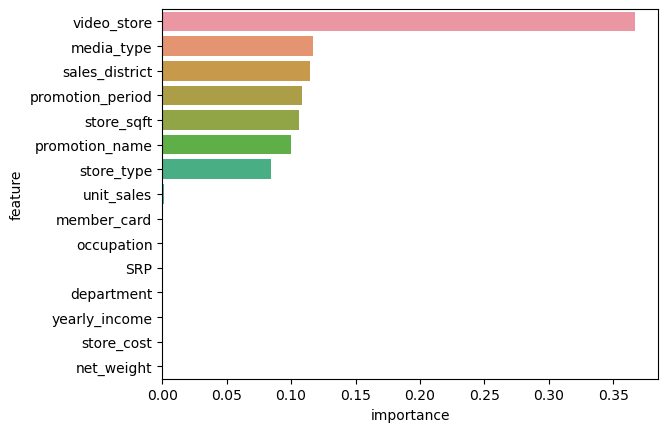

In [20]:
df_max_imp_xgbr=df_imp_xgbr.sort_values(by="importance",ascending=False)
sns.barplot(x=df_max_imp_xgbr["importance"],y=df_max_imp_xgbr["feature"])

In [21]:
ypred_train=model_xgbr.predict(X_train)
ypred_test=model_xgbr.predict(X_test)

In [22]:
mse_train=mean_squared_error(y_train,ypred_train)
mse_test=mean_squared_error(y_test,ypred_test)
print("Mean squared error for train data:",mse_train)
print("Mean squared error for test data:",mse_test)

Mean squared error for train data: 2661.0073255958323
Mean squared error for test data: 3154.4348410471835


In [23]:
# Example: Cross-validation with 3 folds
scores = cross_val_score(XGBRegressor(random_state=42), X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", -scores)

Cross-validated RMSE: [10632527.76591312 10610486.21193903 10599066.13568085]


In [24]:
print(np.min(-scores),np.max(-scores),np.mean(-scores))

10599066.135680847 10632527.765913118 10614026.704511


In [27]:
df_last.to_csv("df_last.csv",index=False)